<a href="https://colab.research.google.com/github/SimplyDifficult/ML-for-Wireless/blob/main/3.%20UCB_20_dim_user_BOGP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
P_max = 30 #in dBm

In [2]:
var = 20
number_of_cells = 4

In [3]:
!sudo add-apt-repository ppa:octave/stable
!sudo apt update
!sudo apt install octave

 The latest version of GNU Octave built for all supported Ubuntu releases. GNU Octave is normally distributed with Ubuntu, this PPA is for you if you have a need to use a newer version of Octave than what you can already get from your installed version of Ubuntu.

Simply follow the instructions below to add this PPA to your system and install the octave package. If it's not that easy or you encounter any errors, contact the team and let us know.

Much credit goes to the Debian Octave Group who maintain the official Debian packages that this work is derived from. Without their efforts to bring Octave packaging to such a high level of quality in Debian and Debian derivatives, this PPA would not be here.
 More info: https://launchpad.net/~octave/+archive/ubuntu/stable
Press [ENTER] to continue or Ctrl-c to cancel adding it.

Get:1 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InReleas

In [4]:
!wget https://www.dropbox.com/s/llve9s3hfamwyni/function_uncorrelated_rayleigh_fading_channel_model.m
!wget https://www.dropbox.com/s/d1ytzzfpxsrpbcv/main_bitchanged.m -O /content/main.m
!wget https://www.dropbox.com/s/v3y2xe56qodthnm/function_SE.m
!wget https://www.dropbox.com/s/5p0j4qdqist7ibm/main_individual_transmit_case_for_Test_phase_bitchanged.m -O /content/main_individual_transmit_case_for_Test_phase.m

--2021-09-22 01:50:43--  https://www.dropbox.com/s/llve9s3hfamwyni/function_uncorrelated_rayleigh_fading_channel_model.m
Resolving www.dropbox.com (www.dropbox.com)... 162.125.5.18, 2620:100:601d:18::a27d:512
Connecting to www.dropbox.com (www.dropbox.com)|162.125.5.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/llve9s3hfamwyni/function_uncorrelated_rayleigh_fading_channel_model.m [following]
--2021-09-22 01:50:44--  https://www.dropbox.com/s/raw/llve9s3hfamwyni/function_uncorrelated_rayleigh_fading_channel_model.m
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc4dffc6023044ecd341af2dd21c.dl.dropboxusercontent.com/cd/0/inline/BWlvz-d5KZVK13Yd7KzzPskNiO2Cn9j01PS7Q25JDLVObdFzsmrlIhgqxFWO4kyZs8cI46oykZKWVoZWn2FA61fG6kVpZ-4UVFW6fSzrvUKxmc-8jUgKZZoQrjnEIoOPeVxLet18I4HCWGvApitryUiY/file# [following]
--2021-09-22 01:50:44--  https://uc4dffc6023044ecd341af2dd21c.dl.dr

In [5]:
from numpy import arange
from numpy import vstack
from numpy import argmax
from numpy import asarray
from numpy.random import normal
from scipy.stats import norm
from sklearn.gaussian_process import GaussianProcessRegressor
from warnings import catch_warnings
from warnings import simplefilter
from matplotlib import pyplot
from scipy.optimize import minimize
import numpy as np
from scipy.io import loadmat, savemat
import numpy as np
from google.colab import files
import cv2
from scipy.optimize import dual_annealing

In [6]:
import warnings
warnings.filterwarnings('ignore')

In [7]:
#### Objective function
import random
def objective(tr_array):
  tr_in_mW = np.power(10,tr_array/10.0)
  savemat("transmit.mat", {"transmit":(tr_in_mW)})
  !octave -W main.m
  SE = loadmat('SE.mat')
  return np.sum(SE["SE"])

In [8]:
#surrogate or approximation for the objective function
def surrogate(model, X):
	#catch any warning generated when making a prediction
	with catch_warnings():
		#ignore generated warnings
		simplefilter("ignore")
		return model.predict(X, return_std=True)

In [9]:
def UCBobjective(Xsamples, X, model, beta):
  Xsamples = Xsamples[np.newaxis,:]
  mu, std = surrogate(model, Xsamples)
  mu = mu[:, 0]
  sigma = beta
  probs = mu + sigma * std
  return -probs[0]

In [10]:
#optimize the acquisition function
def opt_acquisition(X, y, model, iteration):
  #Do it 5 times
  r_min, r_max = -31.0, P_max  
  bounds = []
  for ti in range(var):
    bounds = bounds + [[r_min, r_max]]
  min_result = 9999999999999.0
  min_answer = 0
  beta = 0.2
  
  for i in range(3):
    result = dual_annealing(UCBobjective, bounds, args=(X,model,beta))
    if(result.fun<min_result):
      min_result = result.fun
      min_answer = result['x']    
  return min_answer

In [11]:
import random
def objective_FPA(tr_array):
  tr_in_mW = np.power(10,tr_array/10.0)
  savemat("transmit.mat", {"transmit":(tr_in_mW)})
  !octave -W /content/main_individual_transmit_case_for_Test_phase.m
  SE = loadmat('SE.mat')
  return np.sum(SE["SE"])

In [12]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [13]:
X = np.load("/content/drive/MyDrive/trainingx_BOGP.npy")
y = np.load("/content/drive/MyDrive/trainingy_BOGP.npy")
y_FPA = np.load("/content/drive/MyDrive/grad_trainingyFPA_BOGP.npy")

In [ ]:
X = P_max * np.ones([1,var], dtype = "float")
y = np.array([[objective(X[0].reshape((int)(var/number_of_cells), number_of_cells))]])

x_next is [ 0.04320125  0.05734519  0.02414136  0.06442972  0.02750772 -0.37283614
  0.05359236 -0.27265286 -0.36886689  0.08532152 -0.24028351 -0.33762001
  0.12500976 -0.10175191 -0.32379067  0.20577581  0.19343711  0.15111201
  0.15313332 -0.26602694]
f()=0.000000, actual=26.347
0


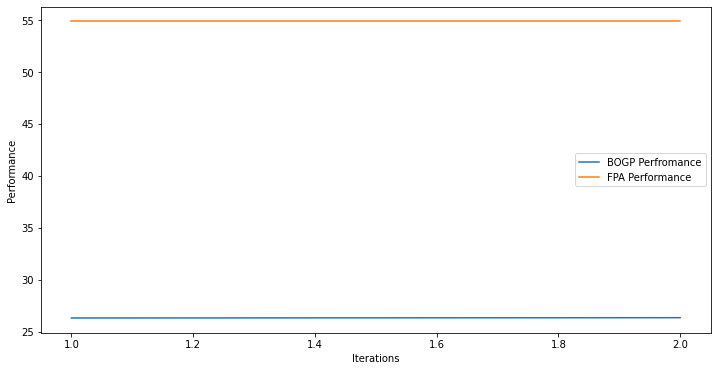

x_next is [ 30.  30.  30.  30.  30. -31.  30. -31. -31.  30. -31. -31.  30. -31.
 -31.  30.  30.  30.  30. -31.]
f()=28.963286, actual=41.668
1


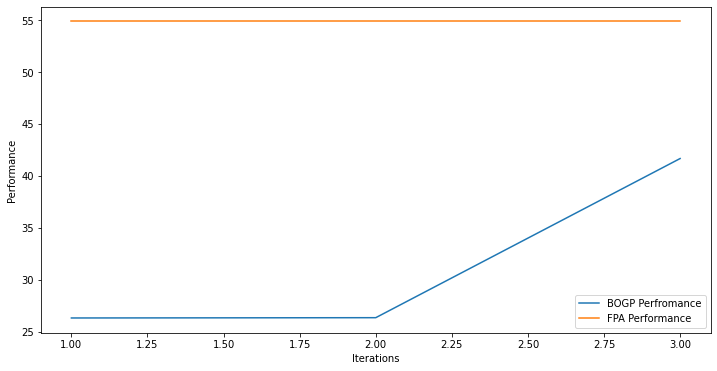

x_next is [ 30.          30.          30.          30.          30.
  -3.95820544  30.         -30.99999999 -30.99999999  30.
 -30.99999999 -30.99999999  30.         -30.99999999 -30.99999999
  30.          30.          30.          30.         -30.99999999]
f()=41.305147, actual=41.674
2


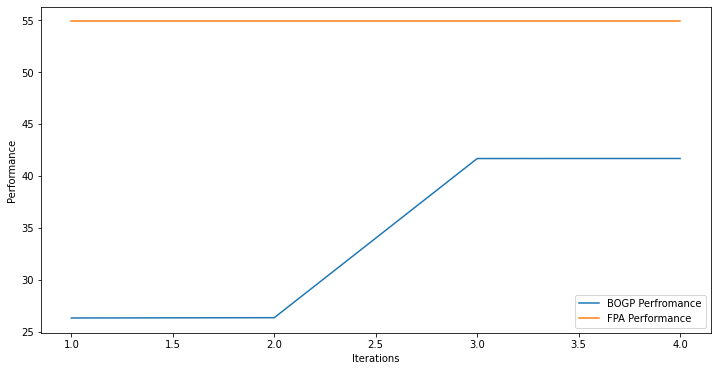

x_next is [ 29.99999999  29.99999999  29.99999996  29.99999997  29.99999997
 -15.00508021  30.         -30.99994681  -4.3681102   29.99999996
 -30.99999976 -30.99993803  29.99999997 -30.99999986 -30.99999985
  29.99999999  29.99999998  29.99999998  29.99987089 -30.9999999 ]
f()=41.393373, actual=41.669
3


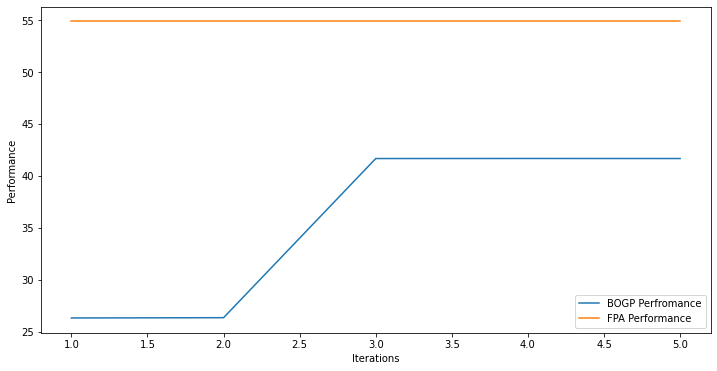

x_next is [ 29.99999798  29.99981545  29.99999815  29.99986536  29.99999799
 -17.07994341  29.99999811 -30.99999439 -21.12204499  29.99999731
 -30.99997741 -30.99994864  29.99999799 -30.99999305 -30.99994237
  29.99999752  29.99999874  29.99996477  29.99996976 -30.99999457]
f()=41.706840, actual=41.669
4


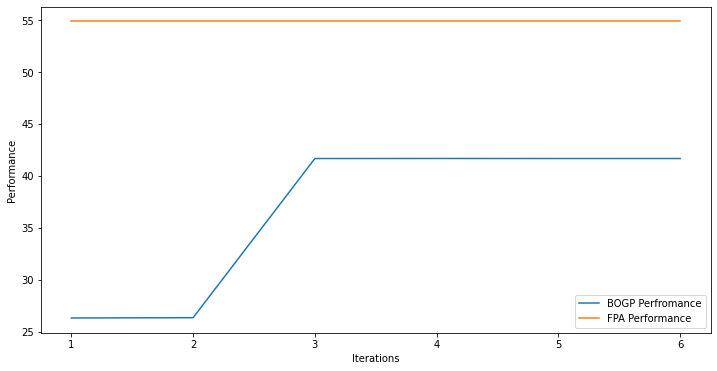

x_next is [ 29.99986909  29.99999826  29.99999783  29.99999799  29.99999812
  29.99943581  29.99976865 -30.99997116  29.99984696  29.99998566
 -30.99971434 -30.99993807  29.9998773  -30.99999367 -30.99986574
  29.99999782  29.99999713  29.99999801  29.99999819 -30.99999239]
f()=41.550768, actual=45.712
5


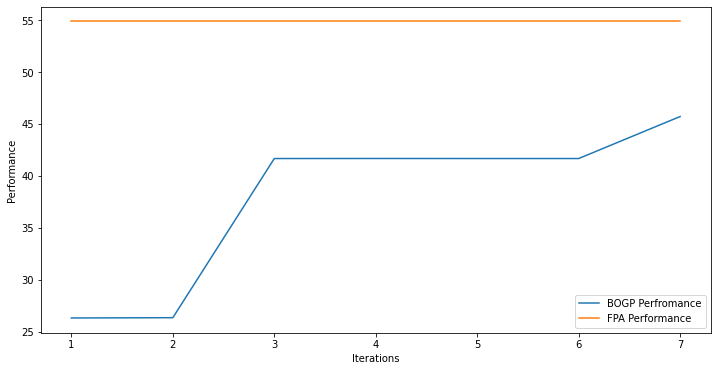

x_next is [ 29.99999729  29.99999715  29.99999748  29.99999778  29.99999747
  29.99999933  29.99988775 -30.99995888  29.9999962   29.99999748
 -30.99983178 -30.99954363  29.99999643 -30.99981021 -30.99955823
  29.99999903  29.9999494   29.99999751  29.99991226 -30.99944917]
f()=45.711573, actual=45.712
6


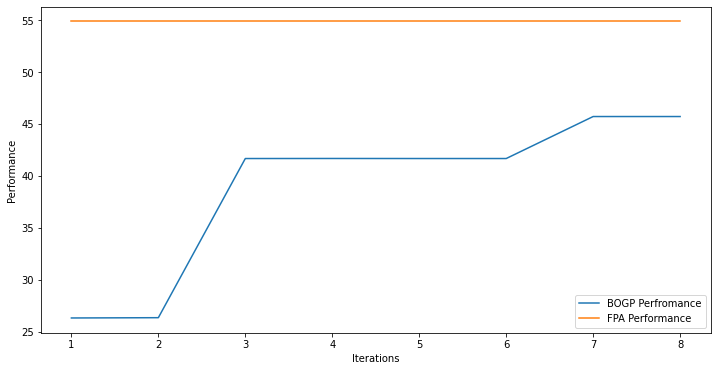

x_next is [ 29.99656211  29.9956137   29.98989999  29.90870887  29.98879713
  29.99882182  29.99682982 -30.97793669  29.99521026  29.99508951
 -30.95264784 -30.98093219  29.97756578 -30.9161558  -30.9401835
  29.94785812  29.90577975  29.99964849  29.99710949  -6.46995321]
f()=45.466873, actual=45.704
7


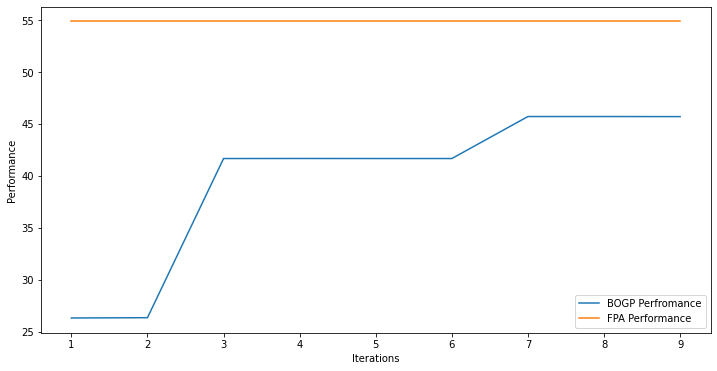

x_next is [ 29.98946941  29.86226168  29.74466714  29.99675173  29.85249656
  29.95031284  29.97796704 -30.93243832  29.99778717  29.99672586
 -30.96825364 -30.66323542  29.90559742 -30.9844435  -30.70914302
  29.60218239  29.81573048  29.90921817  29.99459134 -17.97303935]
f()=45.685987, actual=45.671
8


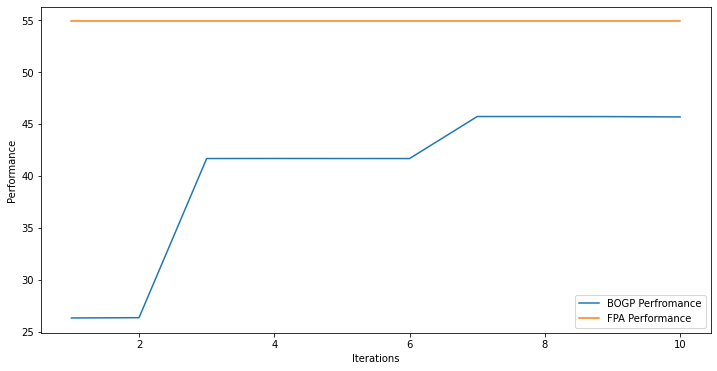

x_next is [ 29.90993402  29.86742488  29.87031593  29.58915513  29.19512698
  29.87216629  29.84881636 -30.98203466  29.64299139  29.85158197
 -30.76880202 -30.74933889  29.55535555 -30.53989803 -30.78160869
  29.59523607  29.76358472  29.86252057  29.8291772  -23.62875958]
f()=45.561218, actual=45.717
9


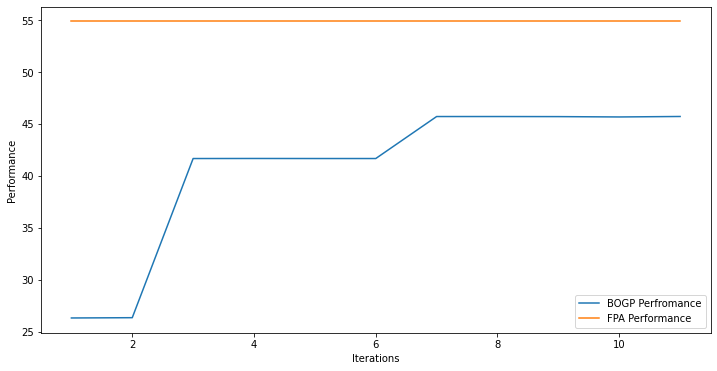

x_next is [ 29.98007791  29.98891491  29.98277422  29.99884315 -30.96864427
  29.99631819  29.99628456 -30.99311524  29.99160219  29.99909512
 -30.99238807 -30.96532768  29.98808746  -2.8652406  -30.98933186
  29.99793876  29.98829427  29.99973941  29.99340199 -14.16887467]
f()=46.778443, actual=45.240
10


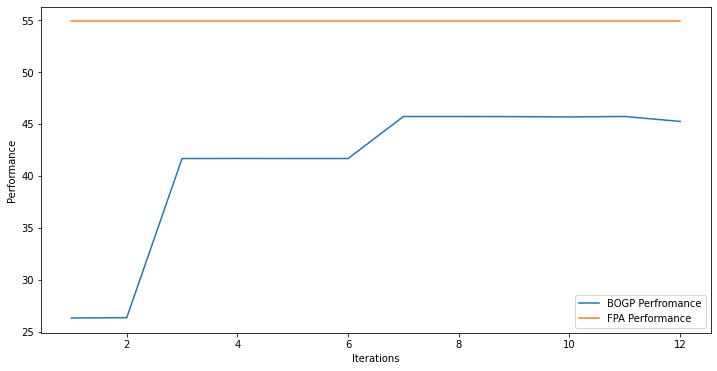

x_next is [ 29.98856574  29.99819791  29.99407415  -2.16508711  13.09996883
  29.9907305   29.97800799 -30.97834961  29.96700882  29.9997104
 -30.98208592 -30.99803853  29.74727601 -22.55424061 -30.98354131
  29.99659532  29.97351132  29.93511454  29.98053949 -15.08864186]
f()=45.857501, actual=40.859
11


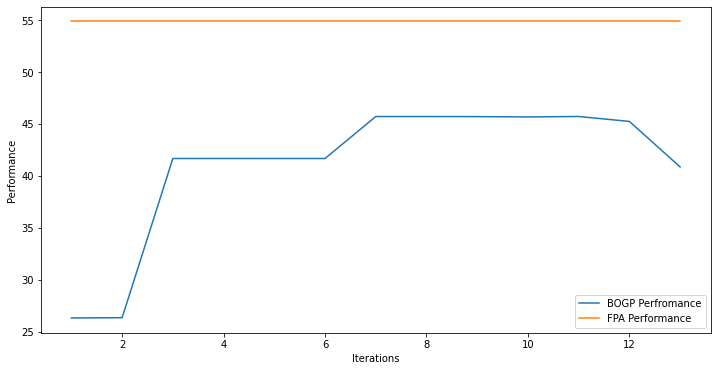

x_next is [ 29.99338436  29.98631685  29.98797403  29.99139375  24.87500785
  29.99223539  29.99741912 -30.99791322  29.98549417  29.99868246
 -30.89004463 -30.98041026 -19.51657181  -0.35793268 -30.9794578
  29.9990418   29.98293169  29.99982444  29.97209329 -10.05114399]
f()=46.118467, actual=43.013
12


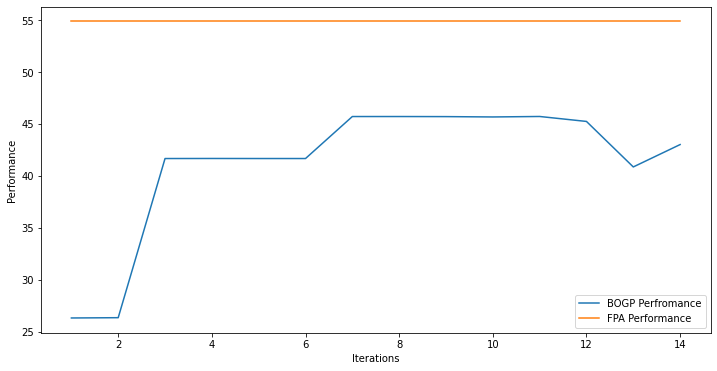

x_next is [ 29.9829494   29.96871637  29.99558921  29.99857745   2.02487208
  29.99136664  29.99356631 -30.99693207  29.98778171  29.97559084
 -13.72213735 -30.99429488  29.98598861 -30.98522483 -30.98095546
  29.98776303  29.95655269  29.98353075  23.05369505 -15.36547767]
f()=46.053496, actual=43.668
13


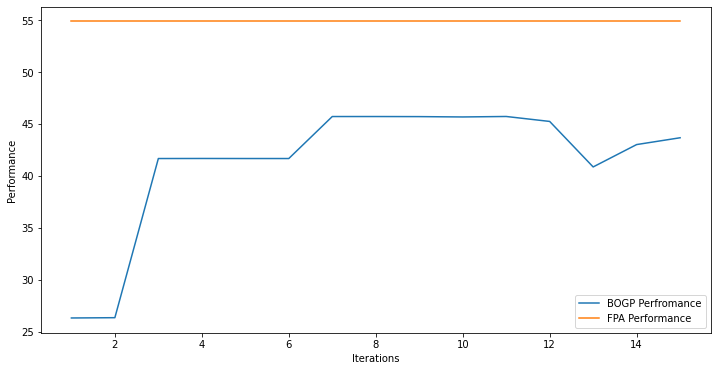

x_next is [ 29.98717951  29.98865715  29.99674231  29.99851945  28.90283658
  29.99407755  29.99527651 -30.99879031  29.98573935  29.80538975
 -30.99207306 -30.99872029  29.99912801  15.54072521 -30.99649723
  29.97765705  29.95796617  29.98212281  29.99255804 -10.3595218 ]
f()=46.133633, actual=46.359
14


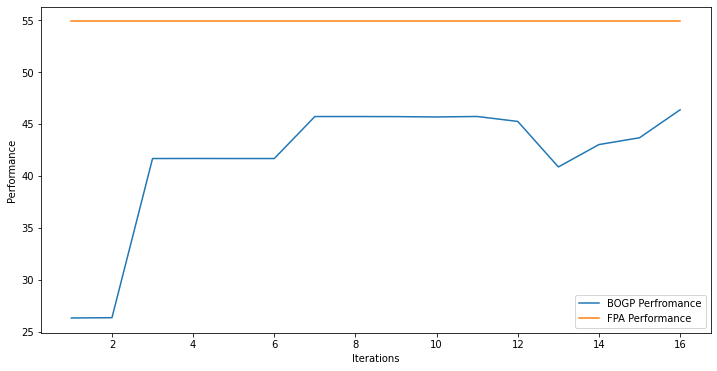

x_next is [ 29.99719912  29.97739914  29.99024586  29.99928662  26.58494388
  29.99416702  29.88228051 -30.99652089  29.98746176  14.92159739
 -30.99572066 -30.99366999  29.97487649   3.3561261  -30.99713627
  29.99955609  29.97929218  29.97941584  29.99869009 -13.61252435]
f()=46.281790, actual=44.615
15


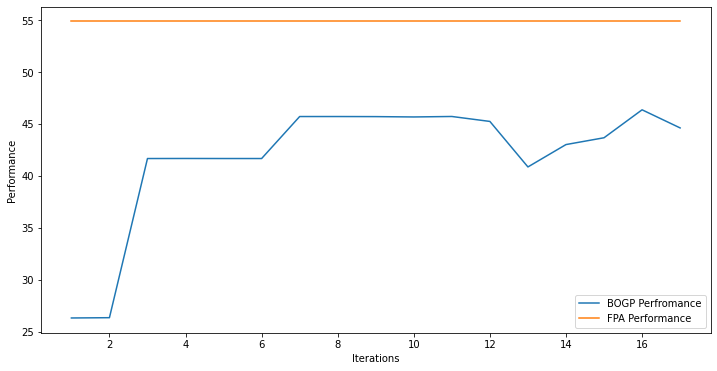

x_next is [ 29.97343417  29.99944612  29.99898092  29.99707296  28.60426311
  29.99278845  10.26178112 -30.99386833  29.99916103  29.99846913
 -30.99293208 -30.97962459  29.99443274  18.66973405 -30.9948719
  29.97755534  29.98487599  29.97697751  29.98944001   0.80038639]
f()=46.227403, actual=47.939
16


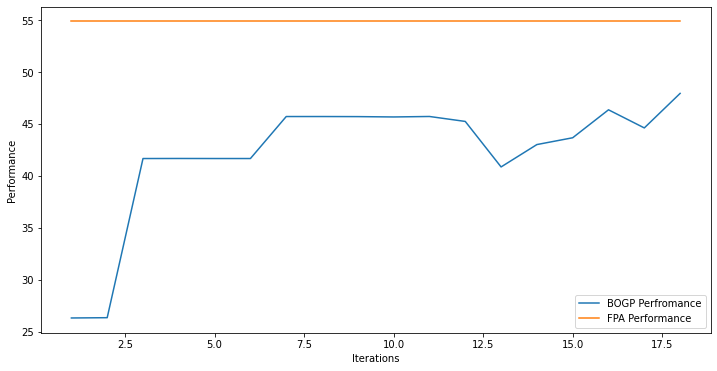

x_next is [ 29.96334743  29.99214399  29.99921594  29.99780242  29.9942416
  29.99558946 -30.99688703 -30.99270542  29.998172    29.99456916
 -30.99984364 -30.99699775  29.99296942  29.92117454 -30.99058798
  29.98869703  29.97396003  29.97461535  29.99709913  17.26599055]
f()=49.617049, actual=47.115
17


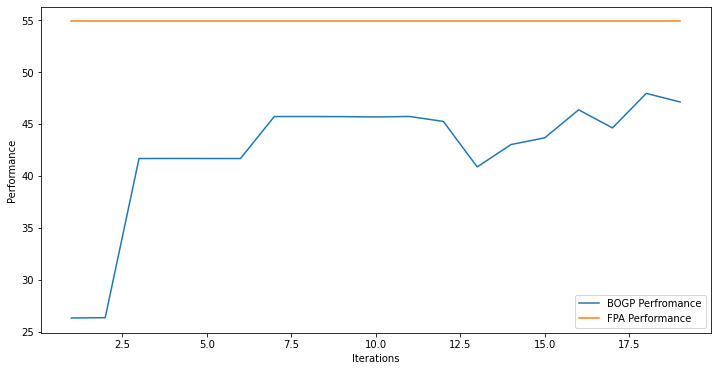

x_next is [ 29.99890495  29.95916351  29.98043088  29.99422797  25.97118107
  29.99618742  -8.83250019 -30.93383871  29.99246148  29.99432005
 -30.99401734 -30.99214957  29.99654178   9.3736213  -30.96086745
  29.95916054  29.90769518  29.9926084   29.96467312  -4.7503178 ]
f()=48.220377, actual=44.104
18


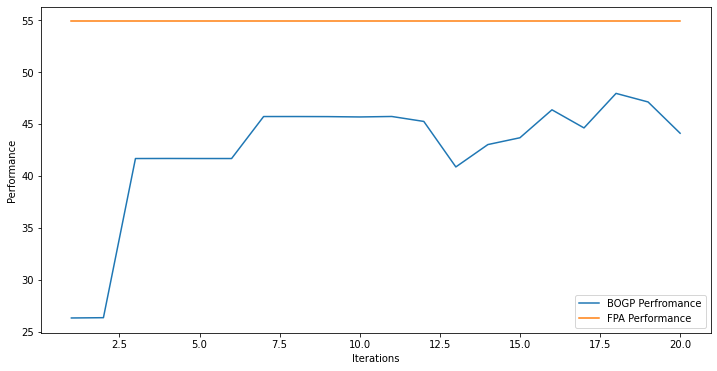

x_next is [ 29.99536201  29.99644704  29.9994622   29.99729202  29.99378243
  29.99398355  20.85162224 -30.99964214  29.99773309  29.99922916
 -30.99814306 -30.99201334  29.99377994  29.99925157 -30.99885588
  29.99954003  29.99600618  29.97774132  29.99718983  29.99951674]
f()=52.151939, actual=51.049
19


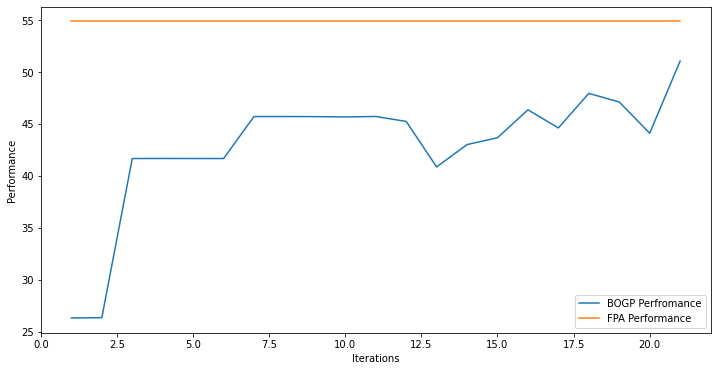

x_next is [ 29.99869564  29.97903619  29.98060413  29.99739291  29.99813781
  29.98677775  11.09659999 -30.9864674   29.96867018  29.9954964
 -30.9880426  -30.98809172  29.99764728  29.99316407 -30.98016073
  29.95167174  29.99636249  29.98804096  29.98484051  29.99559446]
f()=51.104347, actual=50.041
20


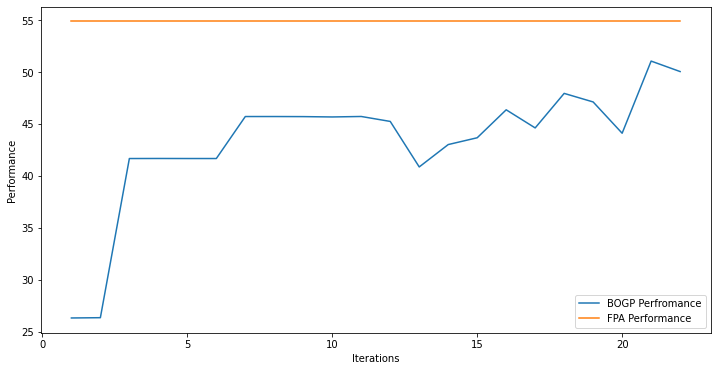

x_next is [ 29.99966026  29.99227195  29.9983021   29.99219419  29.86913078
  29.98930713  29.99932709 -30.99608475  29.97111998  29.99882504
 -30.9938563  -30.97784531  29.99329904  29.99382302 -30.99939848
  29.989554    29.91376506  29.97087275  29.99364659  29.98047653]
f()=51.623895, actual=48.786
21


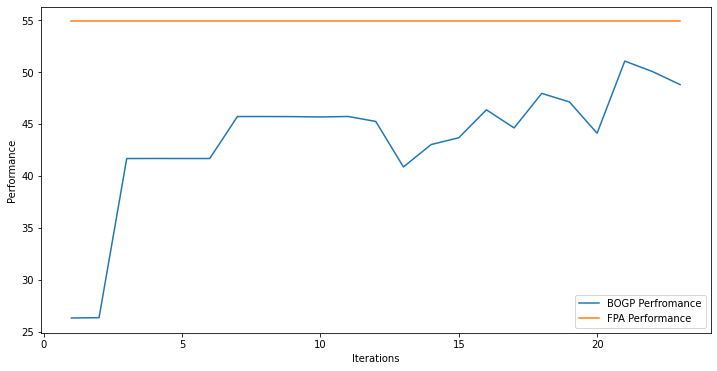

x_next is [ 29.98041652  29.99645292  29.99819282  29.99766615  29.32458482
  29.99819511  19.30979146 -30.98556877  29.93019569  29.99878476
 -30.99979503 -30.99916996  29.98898626  29.99937686 -30.98284121
  29.99331319  29.99499494  29.99521385  29.99750508  27.48311371]
f()=51.112364, actual=51.039
22


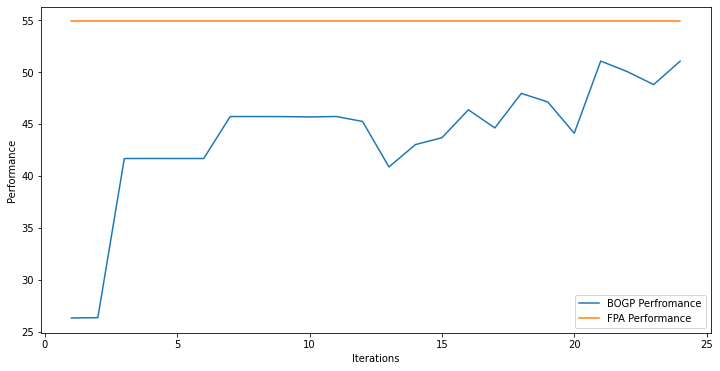

x_next is [ 29.9967459   29.99525958  29.97988457  29.9970121   29.9976717
  29.97971241  19.44041442 -30.98590284  29.98044471  29.99450231
 -30.9978982  -30.97708075  29.99175443  29.96940372 -30.98019038
  29.99424258  29.99344845  28.90494395  29.9939622   29.53128497]
f()=51.073415, actual=51.812
23


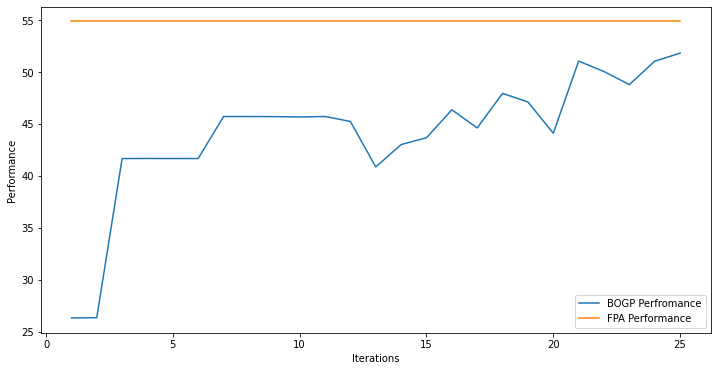

x_next is [ 29.99988077  29.99960411  29.99959906  29.99996416  29.99995128
  29.9988254   11.56232769 -30.99992418  29.99615278  29.99995538
 -30.99986411 -30.9984141   29.99993693  29.99884771 -30.99844334
  29.99996567  29.99930147 -30.99965176  29.99983781  27.08126221]
f()=65.522949, actual=50.054
24


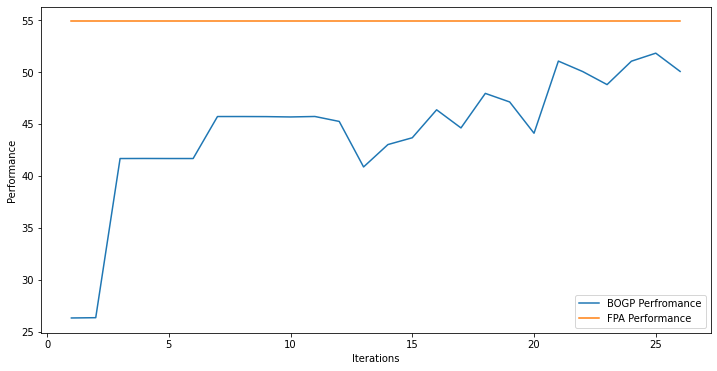

x_next is [ 29.99989407  29.99892002  29.99985817  29.99960237  29.99975998
  29.85825287  17.6051564  -30.99631618  29.28186009  29.99976026
 -30.99971542 -30.1275929   29.43501478  27.07088968 -30.68883738
  29.99919294  29.99909212   5.32696658  29.998587    28.04592542]
f()=57.202878, actual=52.790
25


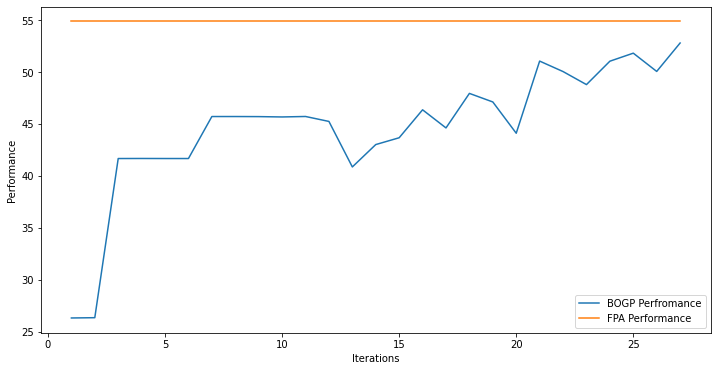

x_next is [ 30.          30.          30.          30.          30.
  30.          17.56179143 -31.          30.          30.
 -31.         -31.          30.          30.         -31.
  30.          30.           1.71829262  30.          30.        ]
f()=52.238239, actual=51.307
26


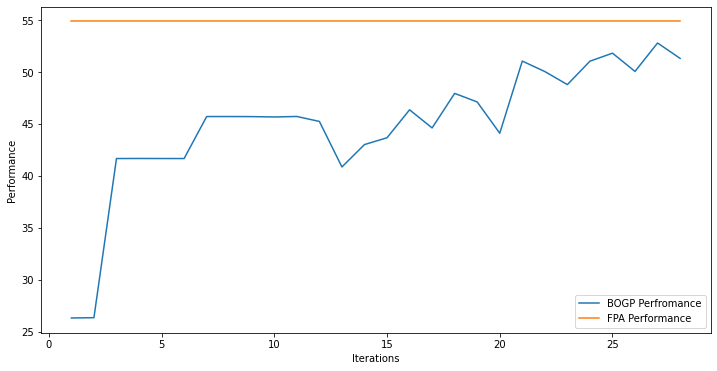

x_next is [ 30.          30.          30.          30.          30.
  30.          28.47047844 -31.          30.          30.
 -31.         -31.          30.          30.         -31.
  30.          30.          -2.59112895  30.          30.        ]
f()=51.681726, actual=49.340
27


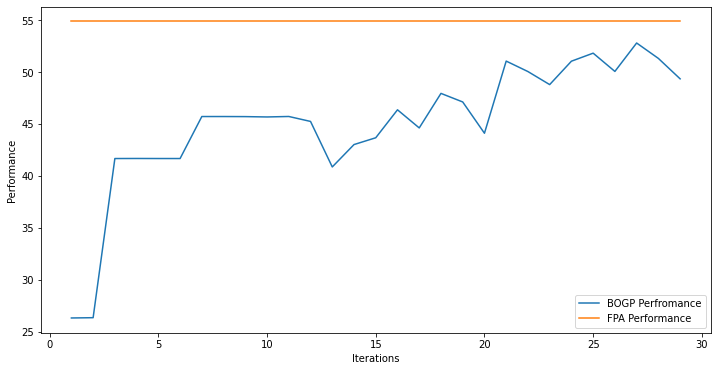

x_next is [ 29.99993739  29.99828974  29.81934951  29.9999867   29.99965231
  28.70411171  17.40692794 -30.99843883  27.24932624  29.99998698
 -30.99946909 -26.31102076  28.29395775  21.88981069 -29.25122469
  29.99901231  29.99751143  15.97018399  29.99974234  26.62452316]
f()=54.640459, actual=55.723
28


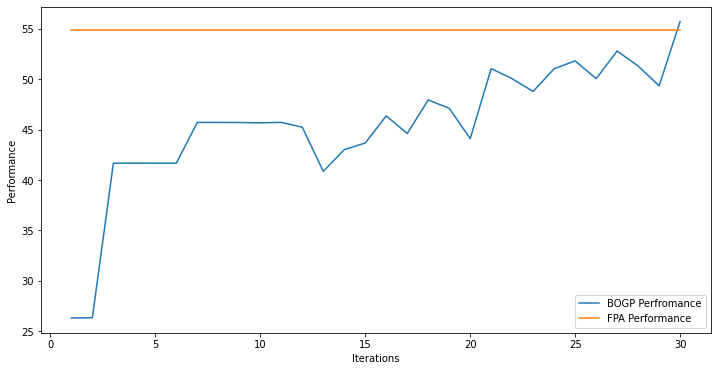

x_next is [ 29.99935793  29.99989759  29.99187402  29.99983259  29.99961482
  25.84128402  15.05749372 -30.99758695  22.74835937  29.99991737
 -30.99993973 -15.45528038  26.76593319  16.47081518 -25.86688506
  29.99860288  29.99831987  11.81858007  29.99835058  25.89434356]
f()=55.928465, actual=55.210
29


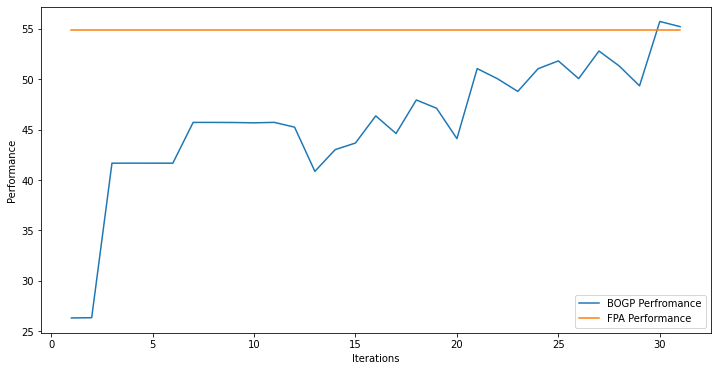

x_next is [ 29.997219    29.99972904  28.28009841  29.99820279  29.99974483
  27.48889875  17.26093428 -30.9988695   25.54646302  29.99977084
 -30.99924743 -24.93814709  27.3192907   18.6341153  -26.83075497
  29.99945365  29.99784991  15.80630461  29.99800614  27.33033411]
f()=55.788326, actual=55.787
30


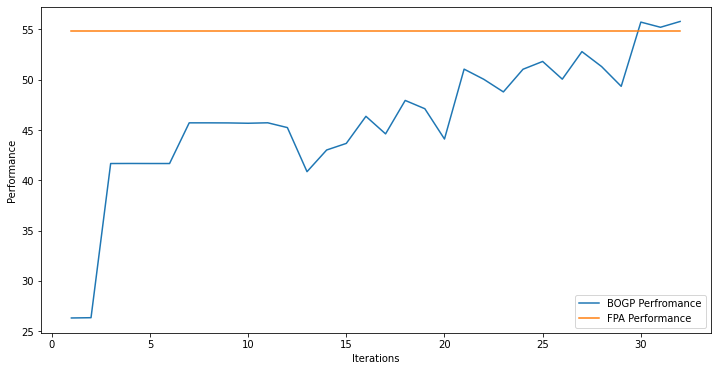

x_next is [ 29.9994772   29.99999414  28.67477981  29.99992714  29.9990724
  27.7898862   17.27609387 -30.9818889   25.87788646  29.99953244
 -30.99987054 -23.67696348  27.45326494  18.77530905 -30.22961406
  29.99718076  29.99797344  15.87309407  29.99879103  27.27643545]
f()=55.784903, actual=55.775
31


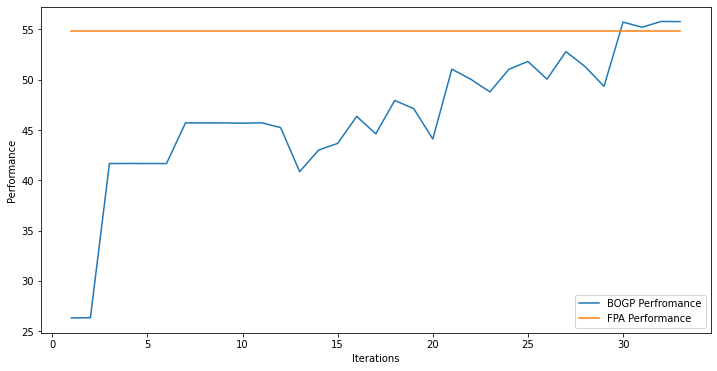

x_next is [ 30.          30.          30.          30.          30.
  29.99999995  16.88634597 -30.99999999  24.93187725  30.
 -31.         -24.25544956  27.34271283  17.12308764 -27.70670813
  30.          30.          15.12728133  30.          26.76212116]
f()=55.890669, actual=55.130
32


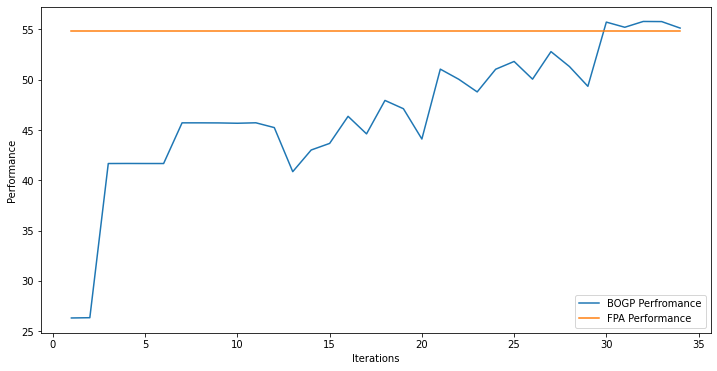

x_next is [ 29.99890422  29.99957734  25.12126801  29.99991599  29.9999654
  17.90594429  16.31216341 -30.99656934  29.62471485  29.99938498
 -30.9976188  -21.76412232  27.45064958  20.50924887 -27.8730545
  29.9997609   29.99916472  14.19903376  29.99974044  25.94668547]
f()=56.478951, actual=54.640
33


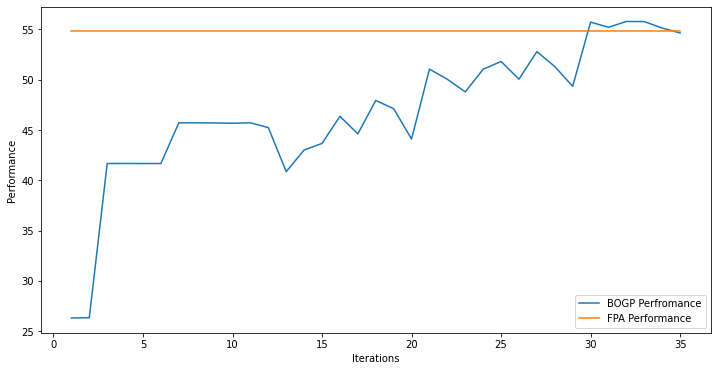

x_next is [ 30.          30.          26.60152981  30.          30.
  25.29923456  17.0195707  -31.          20.86648219  30.
 -31.         -22.91265203  27.02107352  22.78329344 -29.09281131
  30.          30.          15.59629803  30.          26.71167886]
f()=56.073439, actual=55.530
34


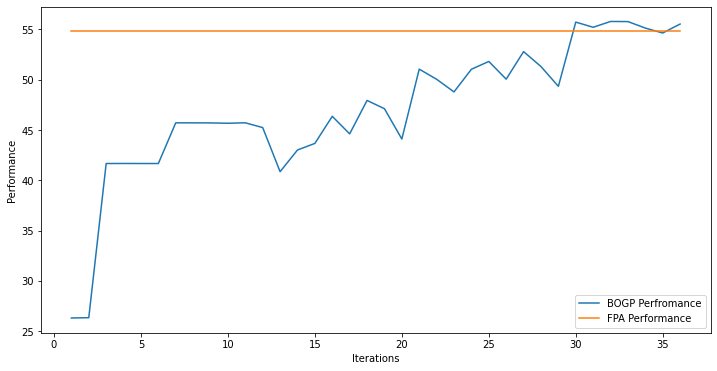

x_next is [ 30.          30.          27.90332966  30.          30.
  26.68153471  17.34269824 -30.99999997  26.05461505  30.
 -31.         -22.68497438  27.27021176  21.17307812 -28.55967264
  30.          30.          16.05575422  30.          27.04275489]
f()=55.847480, actual=56.089
35


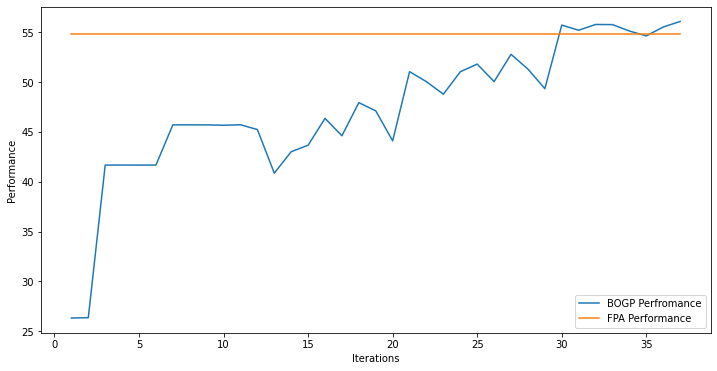

x_next is [ 30.          30.          26.04068227  30.          30.
  27.98477026  17.57740446 -30.99999999  27.33547074  30.
 -31.         -21.31797421  27.1010645   22.12433972 -27.63174389
  30.          30.          16.24980643  30.          27.55186642]
f()=56.100912, actual=56.066
36


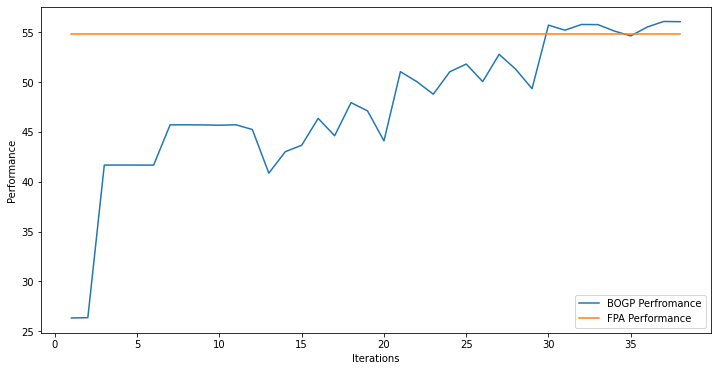

x_next is [ 29.99884987  29.99885139  27.52579402  29.99909116  29.99976599
  26.63125204  17.97006787 -29.8677643   27.11405009  29.99830187
 -30.99834971 -23.05299854  27.04580436  22.01495373 -27.95143971
  29.99887362  29.99085022  16.68642845  29.99995029  28.70464182]
f()=56.128182, actual=56.341
37


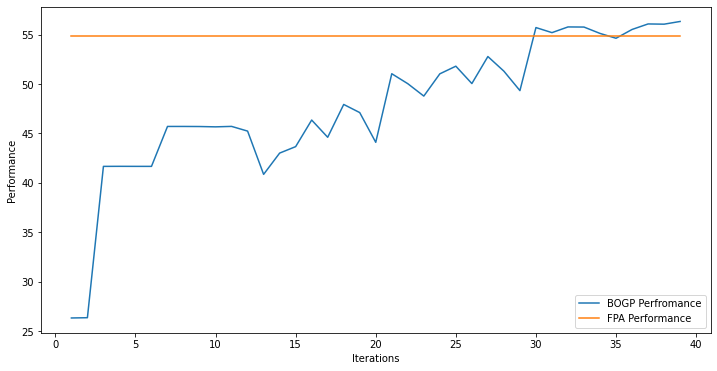

x_next is [ 29.99953622  29.99696833  27.68967061  29.99954921  29.99920247
  26.46124383  17.97098638 -25.77942875  27.12069339  29.99956408
 -30.99939429 -22.42580925  26.52837099  22.07864177 -27.67499299
  29.99994928  29.99901678  16.47184588  29.99790056  29.33758674]
f()=56.413518, actual=56.636
38


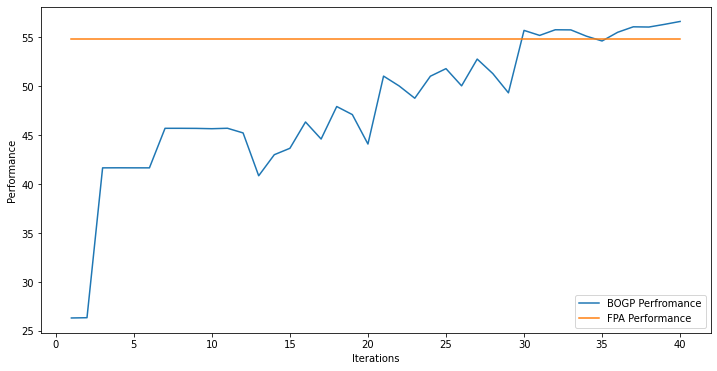

x_next is [ 29.99711572  29.99634775  27.22975247  29.99995204  29.99993004
  26.53400696  17.80433234 -23.74035619  26.85000227  29.99949835
 -30.99936364 -21.67699231  27.69024642  21.82160557 -27.40817473
  29.99834461  29.99783234  16.17466847  29.99986369  28.97974243]
f()=56.629794, actual=55.884
39


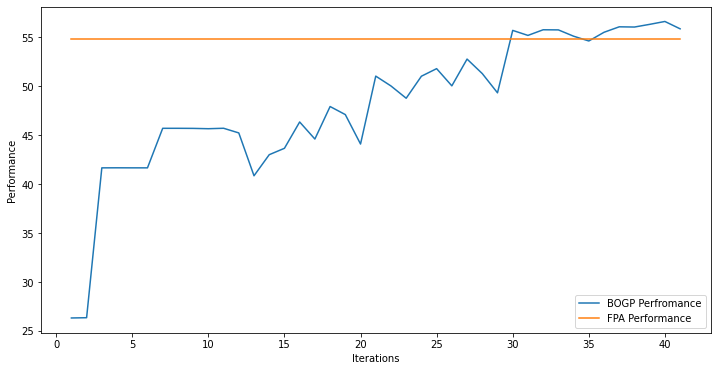

x_next is [ 30.          30.          30.          30.          30.
  25.66255914  16.29314824 -26.72794415  27.36350828  30.
 -31.         -19.87540237  14.12354828  23.04199956 -27.13451941
  30.          30.          14.46283646  30.          30.        ]
f()=57.585951, actual=57.583
40


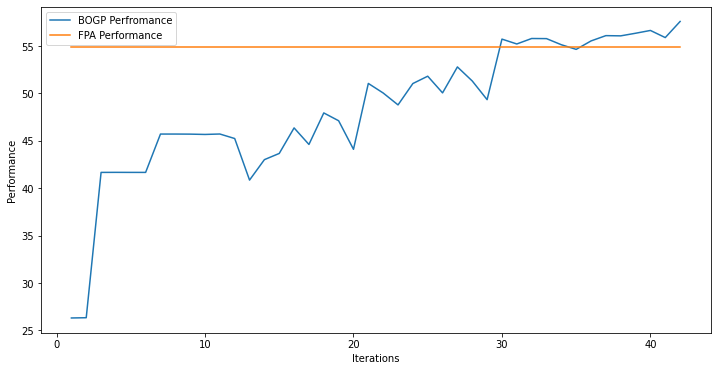

x_next is [ 29.99549291  29.99996561  28.53968064  29.99995506  29.99941851
  26.38596393  17.51939    -26.58623325  28.06558903  29.99912954
 -30.9988212  -23.68815788  17.92763074  22.73381933 -28.3086525
  29.99905226  29.99607964  15.80893944  29.99740165  29.26852898]
f()=57.794092, actual=58.260
41


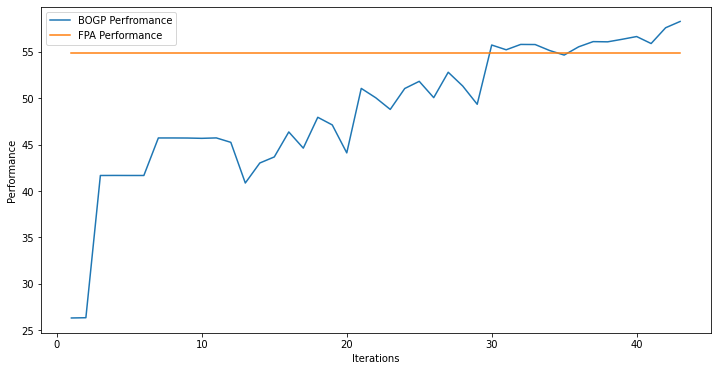

x_next is [ 18.58989327  29.81066439  29.21835428  24.95507219  28.03803225
  22.71385088  24.49368404 -29.99676321  24.29741109  28.33102773
 -29.32116689 -20.46365504  26.7976399   28.79550558 -21.0021061
  29.91318468  27.07717029 -30.31378238  27.97812611  28.95833405]
f()=48.617434, actual=47.480
42


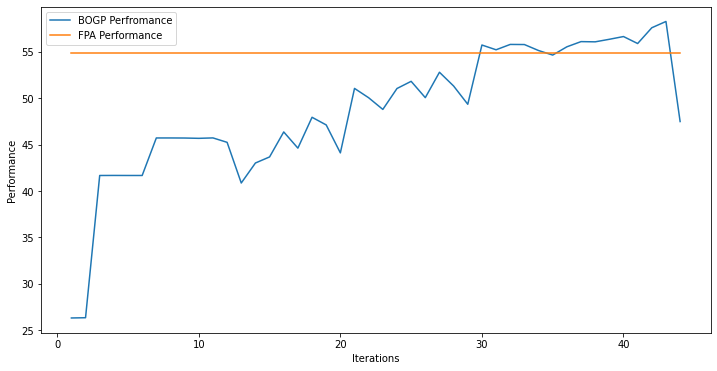

x_next is [ 29.99964582  29.99884105  27.26521137  29.99815645  29.99855471
  26.82232006  17.69328998 -26.08623141  28.62407151  29.99894343
 -30.99941957 -25.71786578  16.67703005  22.57586839 -29.11714076
  29.99777464  29.99987807  15.94578809  29.99771717  28.33379797]
f()=58.321311, actual=58.040
43


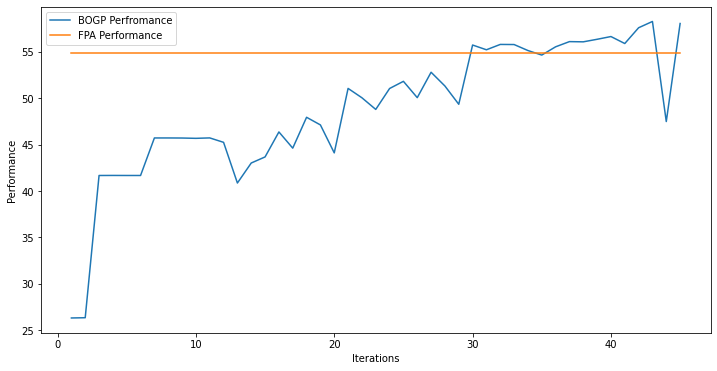

x_next is [ 29.99953043  29.99333339  29.48290525  29.99966562  29.99977399
  26.23944302  18.00733298 -26.89212779  28.27864929  29.9995173
 -30.99861912 -24.11679897  18.24505215  22.83385479 -28.35971458
  29.98975597  29.99688615  16.29775949  29.99371794  29.36982683]
f()=58.266057, actual=58.428
44


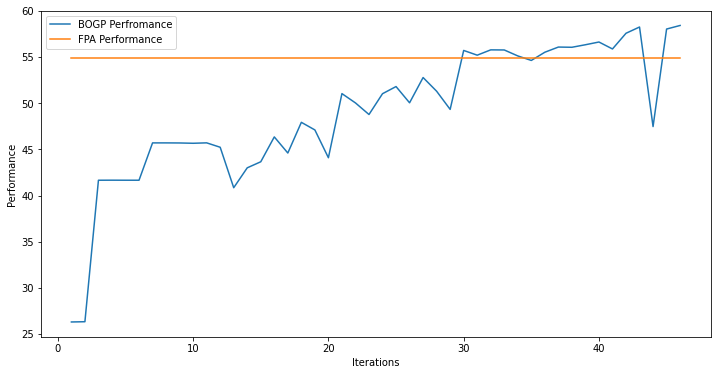

x_next is [ 29.99696542  29.99414153  29.99635856  29.99733347  29.99903619
  25.76448498  19.31270393 -27.11548574  28.9409771   29.9957555
 -30.9988668  -24.81691631  17.9492047   22.99033686 -28.21309798
  29.98820305  29.99805858  17.17536133  29.99613796  29.3507505 ]
f()=58.507760, actual=58.473
45


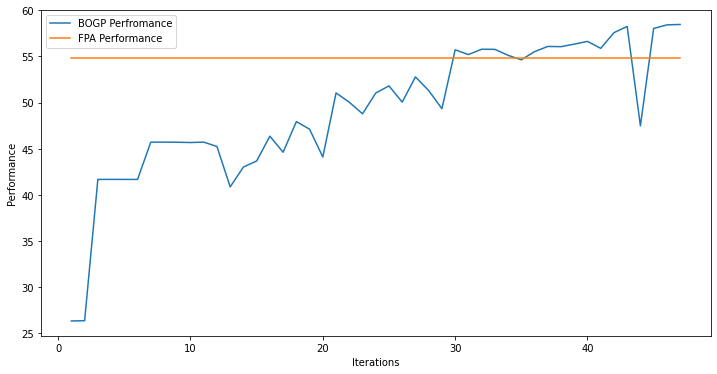

x_next is [ 29.998809    29.16264325  29.99897516  29.99640177  29.99974729
  26.03948006  18.49055745 -27.14142465  28.71468681  29.99940182
 -30.99643576 -24.90074536  18.12215206  23.08739802 -28.58447407
  29.98359938  29.99998121  16.94051663  29.9979421   29.46154306]
f()=58.470690, actual=58.387
46


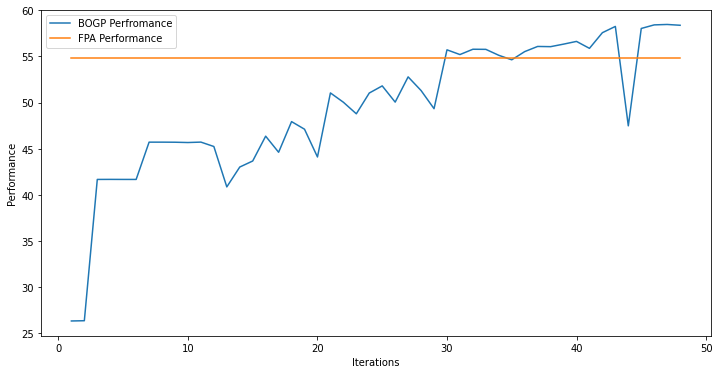

x_next is [ -4.74314635  23.4023341   11.61144671  26.45640924  22.17132789
  17.19857679 -11.78479892   7.04866337  15.17348513  -1.88562762
  -9.95644771 -12.85077966  16.93994828  28.7208775    0.20517641
  22.48738782  18.59816891  -5.85704601  15.86925768  21.38380511]
f()=49.402917, actual=41.977
47


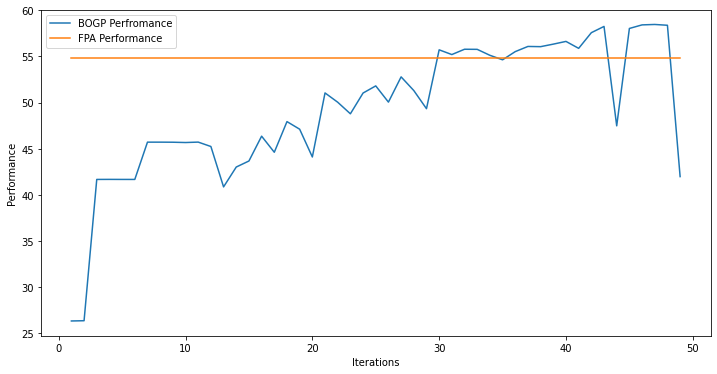

x_next is [ 29.99838005  29.99978798  29.99975328  29.99988554  29.99972628
  26.0302009   18.6790009  -27.02912036  28.64481284  29.99940071
 -30.99495491 -24.79119591  18.10099318  23.08614842 -28.39909478
  29.99983469  29.99564344  16.88208565  28.09871394  29.37724476]
f()=58.407303, actual=58.750
48


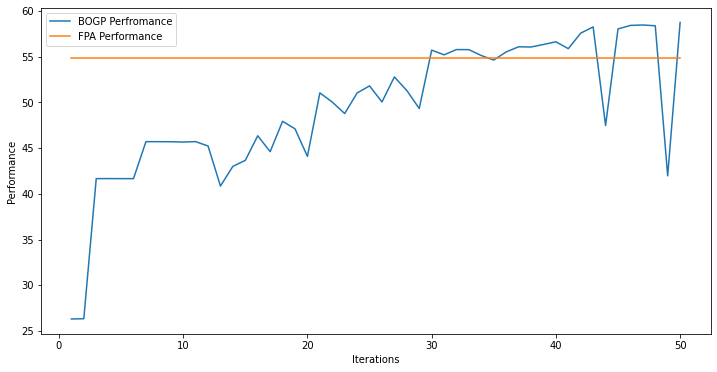

x_next is [ 29.99739833  29.9996043   29.99976639  29.99895798  29.99922798
  25.87870998  18.69895626 -26.94764     28.75924333  29.99955995
 -30.99934421 -24.8761556   17.44050292  22.98163244 -28.3093949
  29.99940495  29.99950934  16.72368772  23.92737999  29.09782108]
f()=58.893683, actual=58.678
49


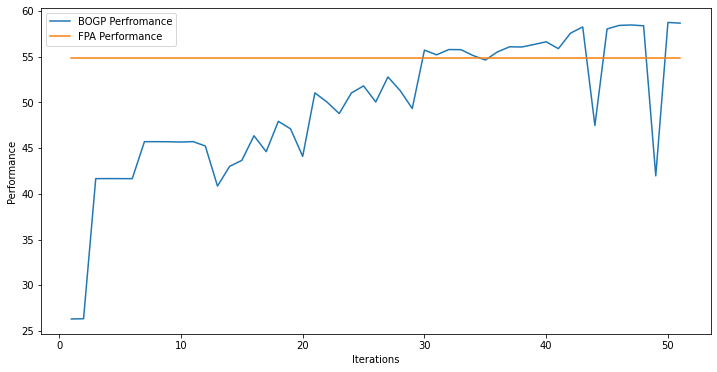

x_next is [ 29.99847712  29.99976023  29.99519027  29.99833739  29.99881698
  26.13354236  18.50918086 -27.06035613  28.43288404  29.99843425
 -30.99277531 -25.00997727  18.11296588  23.70332521 -28.62680324
  29.99605943  29.98846896  17.10795049  26.52324931  29.58647799]
f()=58.805709, actual=58.758
50


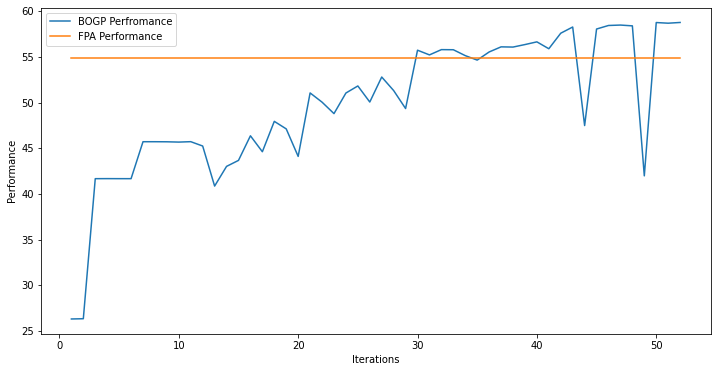

x_next is [ 29.9809806   29.99886617  29.9989942   29.99953333  29.99974467
  26.04658606  18.80261737 -26.96708556  28.89566999  29.99869098
 -30.99449598 -24.65021703  18.07197613  22.40276819 -28.22271717
  29.9999178   29.99944318  16.59134695  26.59870575  28.89785136]
f()=58.808473, actual=58.903
51


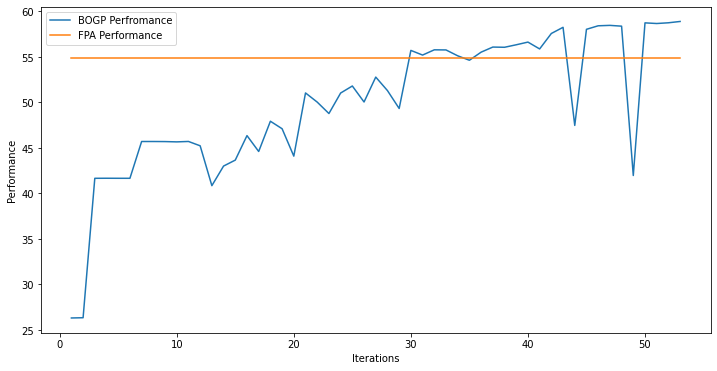

x_next is [ 29.35071295  29.99770464  29.99937324  29.99837359  29.99895833
  26.36922493  19.08328351 -27.00703148  29.36510815  29.99951562
 -30.99950806 -24.20593581  18.20364556  21.79243642 -28.22835153
  29.99585919  29.99213217  16.52305223  26.36049347  28.07065961]
f()=58.914970, actual=58.934
52


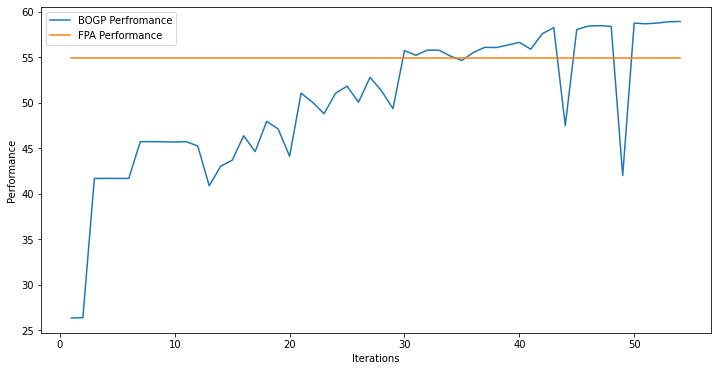

x_next is [ 18.12767976 -11.342437    -5.01232963   1.71623726  -3.10367761
  20.67781722 -19.85193129  26.18146653  11.86954295  25.08625193
  23.38800156   2.38761474 -11.31443852   3.08119843   1.81027903
  19.29302765 -18.92748893  23.85376032  -2.62464251  -1.43074137]
f()=50.135244, actual=30.832
53


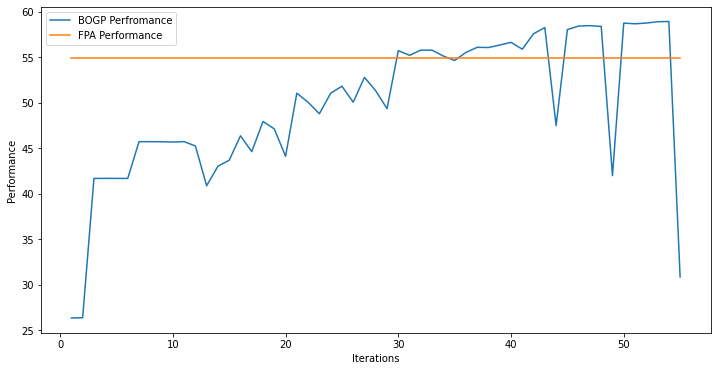

x_next is [ 29.98698776  29.99905242  29.99984992  29.99831562  29.99959936
  26.41238659  19.09122359 -26.9640435   29.36914064  29.99920688
 -30.99321422 -24.19813966  18.22101997  21.72554596 -28.24367482
  29.99910503  29.20912616  16.56609671  26.27605237  28.06570979]
f()=58.917211, actual=59.173
54


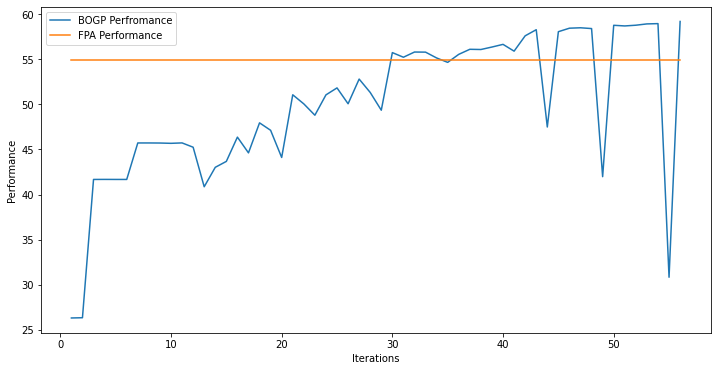

x_next is [ 29.99979174  29.99987845  29.99986392  29.99951066  29.99989095
  26.61814811  18.92421745 -26.70028407  29.99937298  29.99994686
 -30.99964123 -23.03380481  16.7335318   21.07946079 -28.23429996
  29.99988347  19.55365205  15.76300701  24.82401522  26.67656522]
f()=59.869127, actual=59.207
55


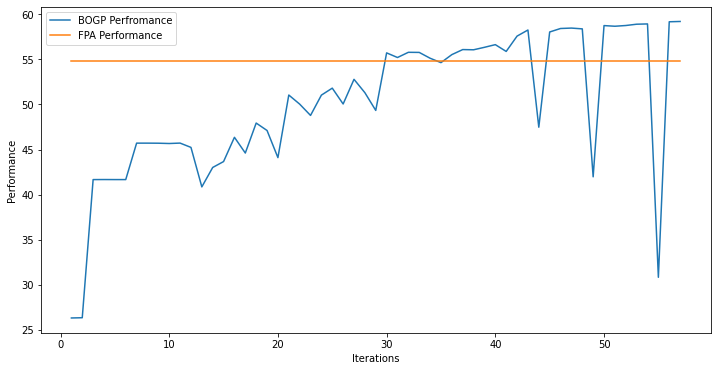

x_next is [ 29.99886916  29.99925792  29.99972088  29.99895093  29.99986396
  26.98493884  19.27377269 -26.92269482  29.86647765  29.99709885
 -30.99714269 -23.39663112  18.00413291  21.74041646 -28.55246734
  29.99736048  24.85060432  16.7847838   25.87334333  27.04485503]
f()=59.560513, actual=59.651
56


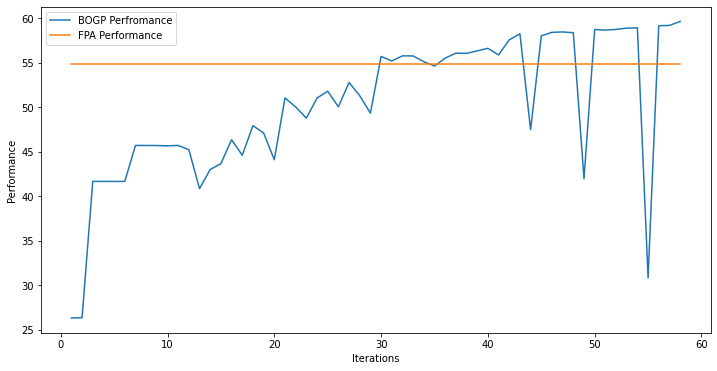

x_next is [ 29.99922175  29.99989014  29.99981129  29.99883932  29.99973089
  27.07692723  19.2595491  -26.95274328  29.94075424  29.99832791
 -30.09827736 -23.371877    17.96366761  21.88488585 -28.6010384
  29.99662425  24.68500762  16.83551999  25.91632713  26.96553826]
f()=59.629910, actual=59.650
57


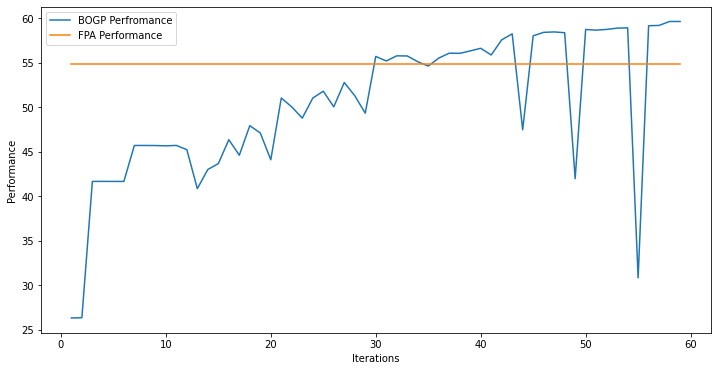

x_next is [ 29.99782537  29.99357654  29.99709331  29.9988121   29.9972564
  27.15460741  19.42356127 -26.92485095  29.93798793  29.99761171
 -30.66939481 -23.14756924  18.00457053  21.71384911 -28.96482363
  29.99916855  24.70576144  16.9381319   25.79172483  27.10793259]
f()=59.649299, actual=59.603
58


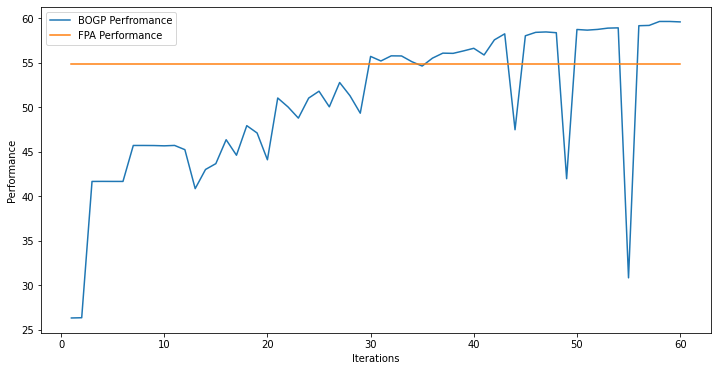

x_next is [ 29.99916137  29.99868899  29.99937061  29.99943397  29.99839091
  26.8530596   18.83063521 -26.95814468  29.79677194  29.99592998
 -30.59105181 -24.02332811  17.95669624  22.45329398 -26.99512897
  29.99929637  24.52072579  16.63338874  25.95843731  26.22599139]
f()=59.723069, actual=59.723
59


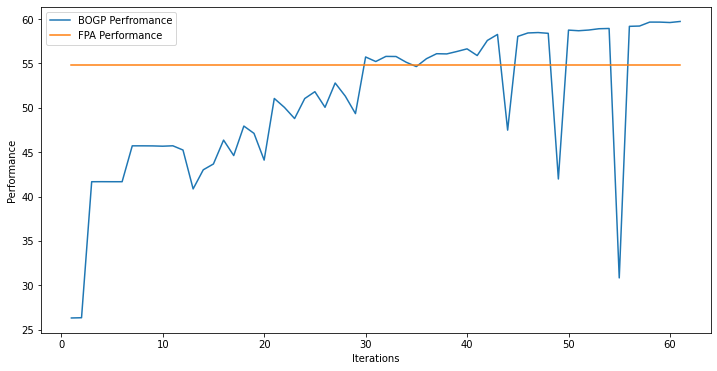

x_next is [ 29.99997036  29.993813    29.99817331  29.99807299  29.99677698
  26.73487054  18.61922695 -26.91934398  29.9933417   29.99733794
 -30.51514742 -24.31231568  18.09720882  22.13881769 -27.06257916
  29.99995821  24.49630176  16.68865306  26.07111658  26.86724678]
f()=59.719047, actual=59.767
60


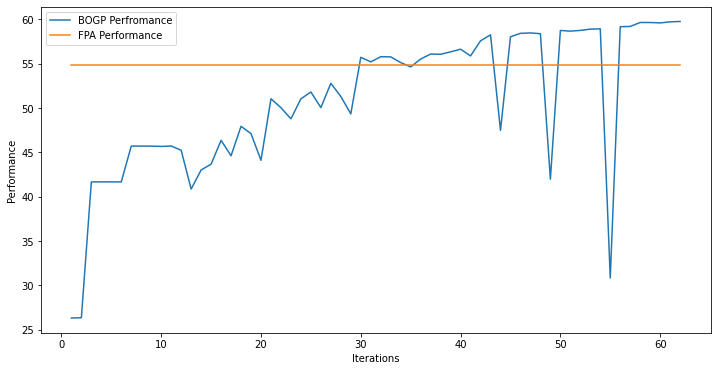

x_next is [ 29.99655775  29.99759387  29.99881239  29.99766792  29.99920248
  26.89359467  18.30691755 -27.02471608  29.9961459   29.99850465
 -30.41865586 -24.63530899  18.11892616  21.91617138 -26.763198
  29.98332863  24.29584449  16.89562133  26.05058707  27.45903153]
f()=59.777550, actual=59.787
61


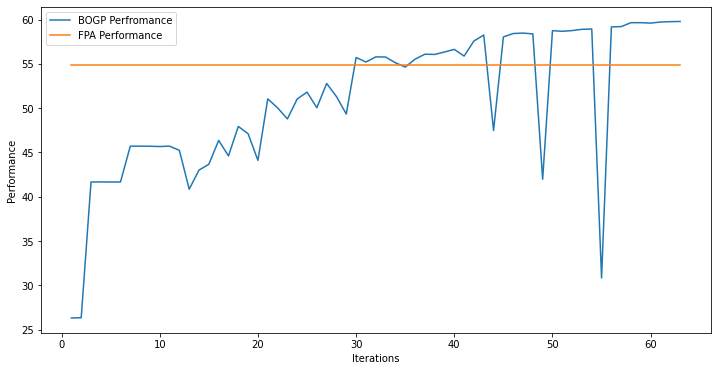

x_next is [ 29.99603331  29.99848204  29.99598521  29.99984539  29.99961462
  26.88345094  18.3345219  -26.86599005  29.98063378  29.99806283
 -30.51332636 -24.60704594  18.18481928  21.88842157 -26.75987675
  29.47247316  24.32242287  17.05809722  26.08113368  27.58842142]
f()=59.767890, actual=59.722
62


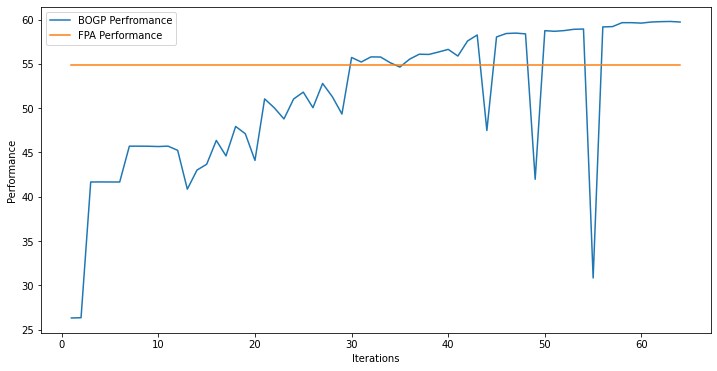

x_next is [ 29.99906049  29.99976028  29.99866021  29.99631558  29.999245
  26.90086157  18.29494961 -27.30429963  29.99173773  29.99881055
 -30.46007235 -24.6169907   18.12308794  21.95221261 -26.70095584
  29.99598752  24.31754823  16.89036205  26.07704596  27.47583154]
f()=59.788567, actual=59.790
63


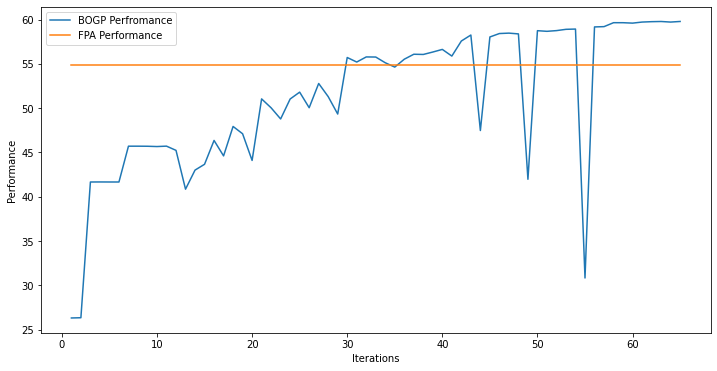

x_next is [ 29.99417752  29.9978429   29.9937389   29.99787839  29.99687267
  26.65427501  17.98097023 -27.32989281  29.99557644  29.98268711
 -30.46515702 -24.58143641  18.02958439  21.80309156 -26.87541969
  29.99464888  24.28745538  17.14957995  26.05087993  27.30285471]
f()=59.781343, actual=59.804
64


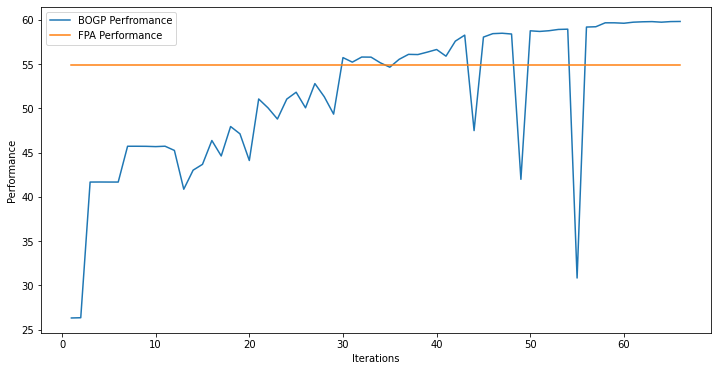

x_next is [ 29.99841412  29.9942264   29.99015047  29.99995379  29.99901454
  26.5157933   17.9012953  -27.41635046  29.96612807  29.99579534
 -30.31821143 -24.60513669  18.01689132  21.49896008 -26.70524755
  29.99961578  24.31987588  17.19243622  25.92092717  27.2015225 ]
f()=59.803325, actual=59.809
65


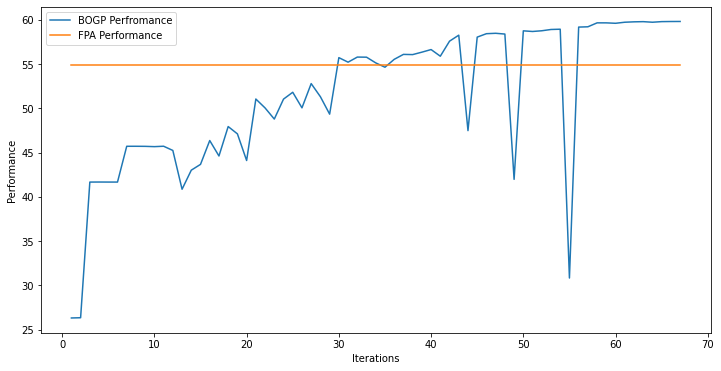

x_next is [ 29.97868885  29.99688535  29.98950565  29.99488872  29.9684693
  29.99224171  29.81460459 -30.99783483  29.99381114  29.98138544
 -30.97941555 -30.99232953  29.98387979  29.99088072 -30.97699325
  29.96826081  29.94652844 -30.75539818  29.98614278  29.99986778]
f()=51.547556, actual=48.753
66


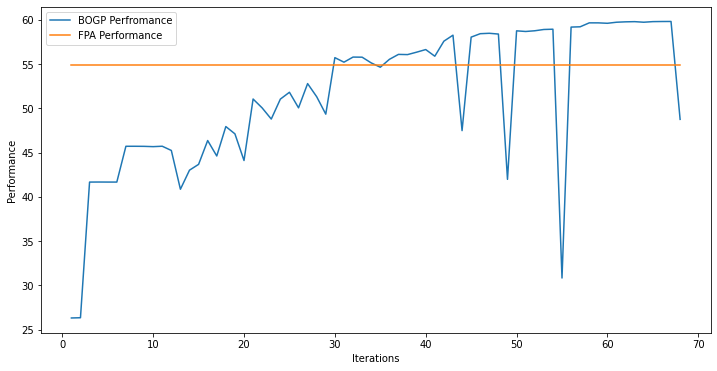

x_next is [ 29.99705684  29.99813307  29.99141723  29.99792182  29.99768706
  26.67262822  17.87259111 -27.34658637  29.98737644  29.99671814
 -30.41088378 -24.46056442  18.03533595  21.27858661 -26.81771844
  29.99491817  24.43278187  17.33206029  26.03528767  27.10073157]
f()=59.806270, actual=59.790
67


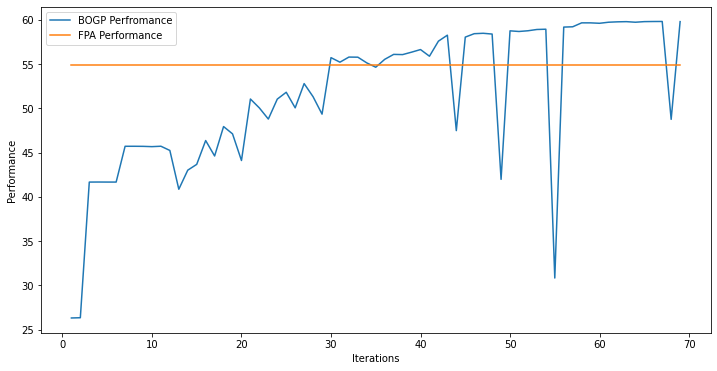

x_next is [ 29.99055934  29.99835678  29.99767811  29.99783547  29.99517492
  25.88895209  17.98900473 -27.45192733  29.58727341  29.9856271
 -30.18503837 -24.82012508  18.06548865  21.8199131  -26.77624329
  29.99903476  24.08646358  17.19752057  25.833765    27.33739909]
f()=59.816650, actual=59.767
68


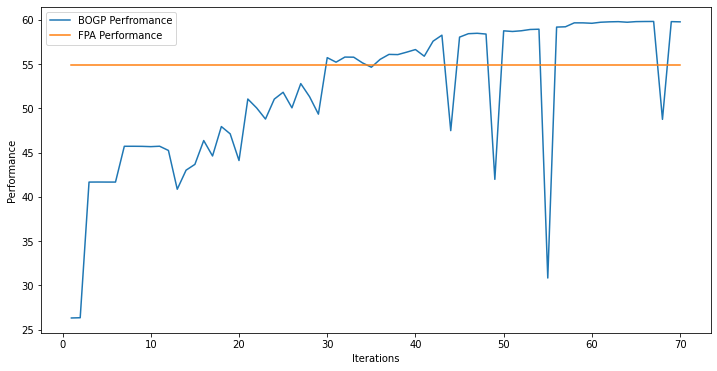

x_next is [ 29.99926168  29.99805138  29.99388654  29.99298506  29.99598763
  26.7952202   17.12889972 -27.63681183  29.9983557   29.98744573
 -30.26924534 -24.54125562  17.59720169  21.93395707 -26.55071375
  29.99724355  24.00900564  16.43826901  24.96203798  27.09056402]
f()=59.821529, actual=59.951
69


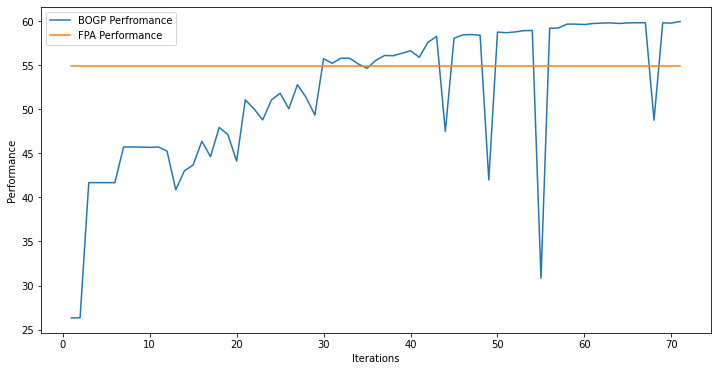

x_next is [-29.74447319   5.1911866  -10.83306575 -13.48137799 -23.52298387
  20.94909077 -26.75207679  24.69175473  -7.43383952  -8.15527928
  26.45332575 -12.88856455  -9.23026155  19.16916501 -19.2254076
 -20.010849    -2.82068347 -26.06414583 -23.48784731  12.07827896]
f()=51.858736, actual=17.907
70


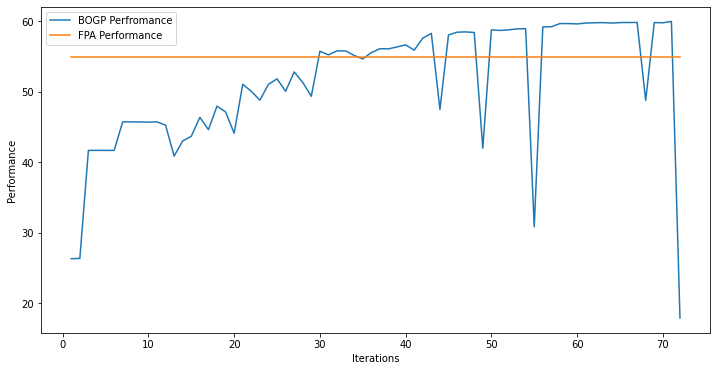

x_next is [ 29.99988701  29.99987819  29.99561948  29.99943064  29.99778404
  26.9460002   15.73454237 -27.68900328  29.99997887  29.99827273
 -29.97613576 -24.42368787  17.39162787  21.95610855 -26.35234482
  29.99994476  23.69012954  15.64166604  24.04879223  26.79794987]
f()=59.990906, actual=60.074
71


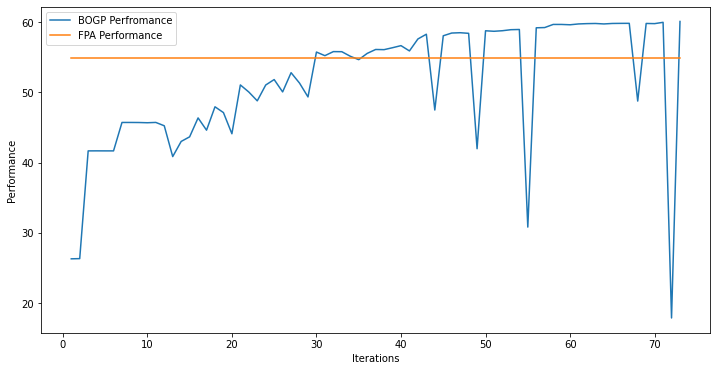

x_next is [ 29.99942258  29.99982349  29.999349    29.99749968  29.99583333
  27.09158068  14.15294662 -27.75199866  29.99939604  29.99967392
 -29.464805   -24.27913742  17.04045319  22.12048152 -25.77901147
  29.99873372  22.87754364  14.92931867  23.14338284  26.37123642]
f()=60.093607, actual=60.061
72


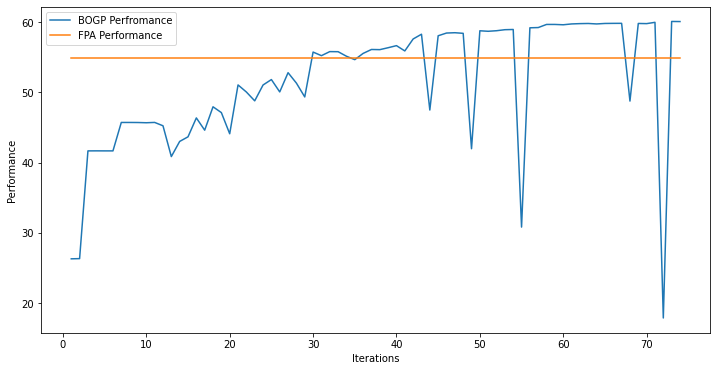

x_next is [ 29.9938969   29.99998187  29.99907099  29.9980126   29.99988763
  26.99016771  15.01760368 -27.69104048  29.99725301  29.99721083
 -29.90069655 -24.51233823  17.53559406  21.97223596 -26.47419529
  29.99760705  23.40156186  15.10009596  23.69085973  26.51515925]
f()=60.085150, actual=60.093
73


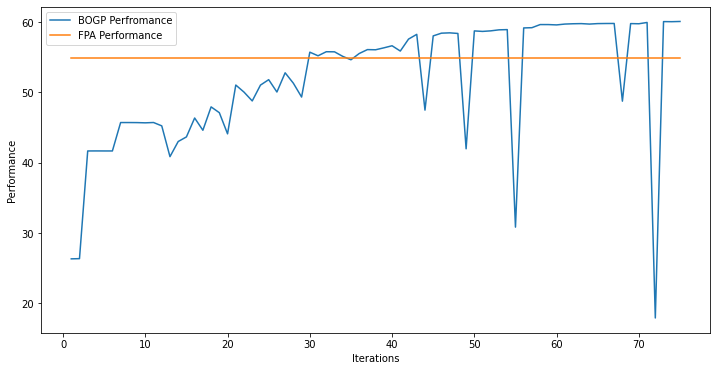

x_next is [ 29.99918009  29.99079624  29.99382642  29.99698898  29.99966641
  27.00842966  14.93312715 -27.70784607  29.99562068  29.99649276
 -29.89473486 -24.54709105  17.67830501  21.98739756 -26.51431211
  29.99764819  23.47295151  15.24731596  23.63823532  26.43758394]
f()=60.091197, actual=60.101
74


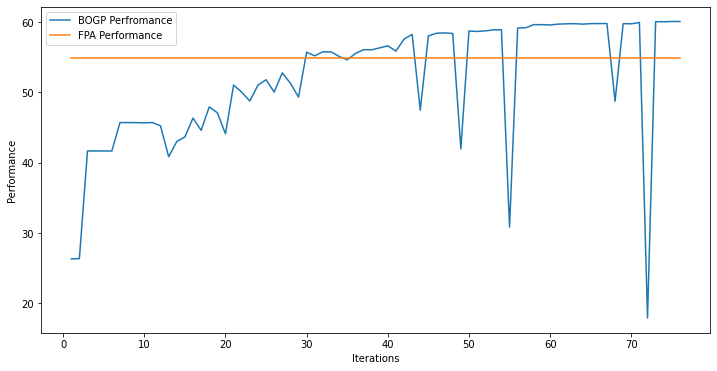

x_next is [ 29.99533306  29.99954431  29.99589644  29.99898849  29.99410531
  27.14787649  14.96082631 -27.75936327  29.99733899  29.98062665
 -29.82031332 -24.19535604  18.11342665  22.32190074 -26.49031002
  29.9978139   23.50328729  15.63085854  23.3508195   26.38677421]
f()=60.105751, actual=60.082
75


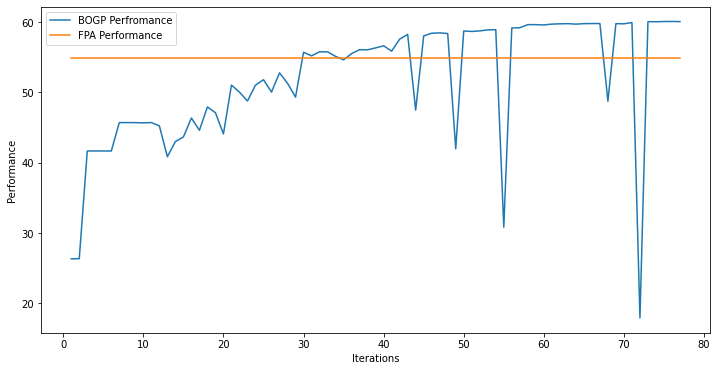

x_next is [  7.75070004  25.77946012  27.01583341  28.36203484  22.85046411
   8.43470543 -28.95926793   4.07442854  -0.66254852  28.24660321
 -20.52063506 -29.62075439 -13.93667799  28.8469169   19.83734669
  23.19745219 -16.69504074 -12.07143063 -24.88550272  -4.55271291]
f()=54.750498, actual=33.856
76


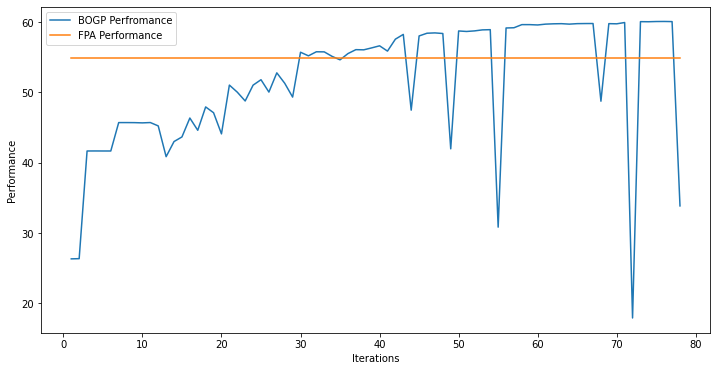

x_next is [ 29.99803955  29.9998512   29.99422629  29.99883001  29.99654252
  27.25416442  14.65159289 -27.72125939  29.99620759  29.99750982
 -29.76206664 -25.26970481  17.52292875  21.89254109 -26.60862346
  29.99845229  23.48191513  15.61895903  23.54193548  26.11574933]
f()=60.111858, actual=60.102
77


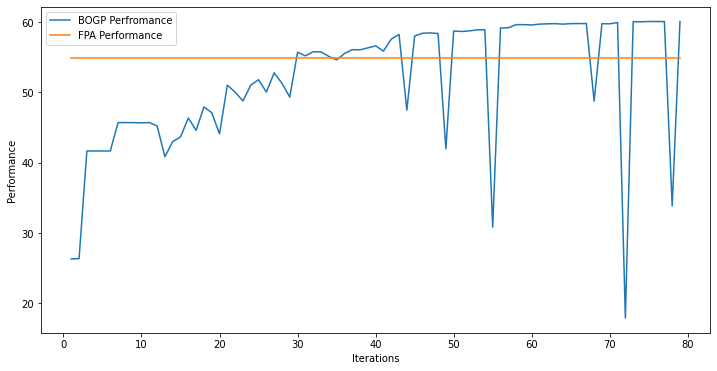

x_next is [ 29.9883722   29.99593238  29.99421281  29.99755879  29.99587988
  29.99118566  29.99428321 -30.99909202  29.9948488   29.99130029
 -30.99859077 -30.99483247  29.90989106  29.99287143 -30.99575748
  29.99193603  29.99353736  29.98480057  29.99961411  29.99855365]
f()=51.821647, actual=48.837
78


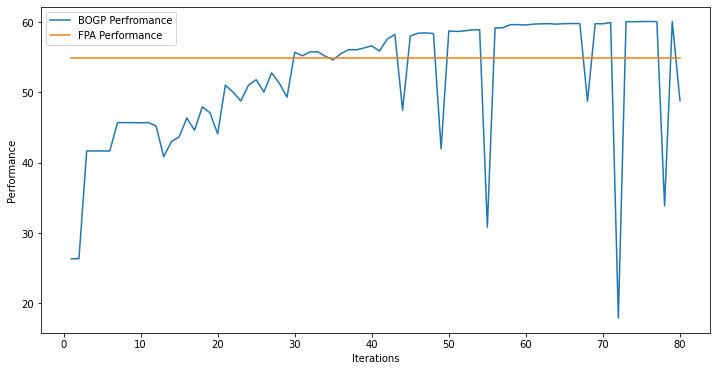

x_next is [ 30.          30.          30.          30.          30.
  26.98512866  14.72184957 -27.70769819  30.          30.
 -29.84159175 -24.82066355  17.68278656  21.85161809 -26.514453
  30.          23.60686663  15.58855639  23.65234368  26.26627962]
f()=60.112315, actual=60.123
79


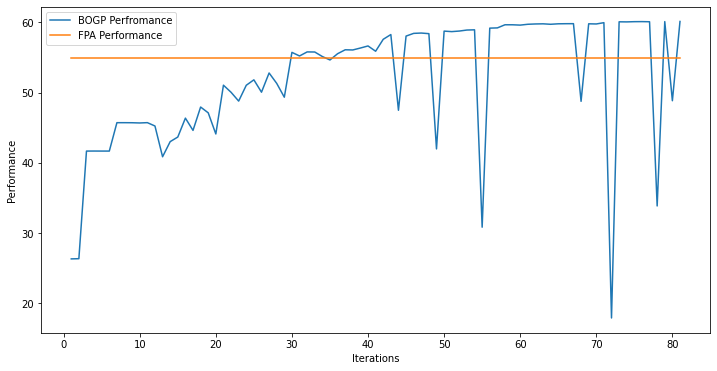

x_next is [ 29.91909395  29.96197186  29.90866784  29.96644239  29.98283192
 -30.88342113  29.98972454 -30.97806178  29.98747932  29.96656823
 -30.95347831  29.99140895 -30.9560764  -30.85670065 -30.98552355
  29.92320998  29.95253812  29.89031532  29.99597019  29.99762611]
f()=67.674493, actual=42.954
80


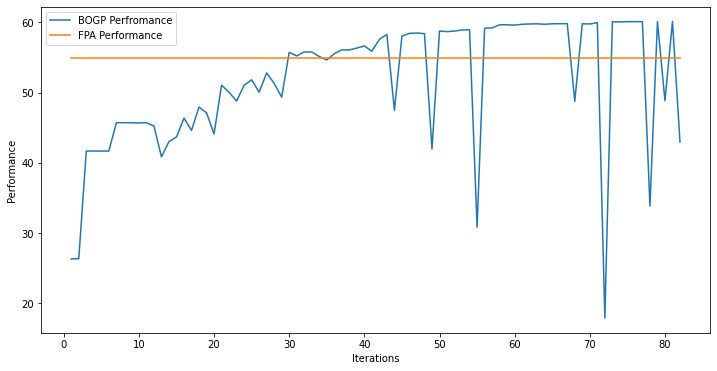

x_next is [ 29.99478991  29.99958717  29.99937105  29.99773188  29.99656421
  26.54117185  14.3413884  -27.54282996  29.99545903  29.99642745
 -29.82234906 -24.63558075  17.62247933  21.55058036 -26.31679255
  29.99856691  23.56695958  15.75839984  23.68591427  26.04870013]
f()=60.129700, actual=60.142
81


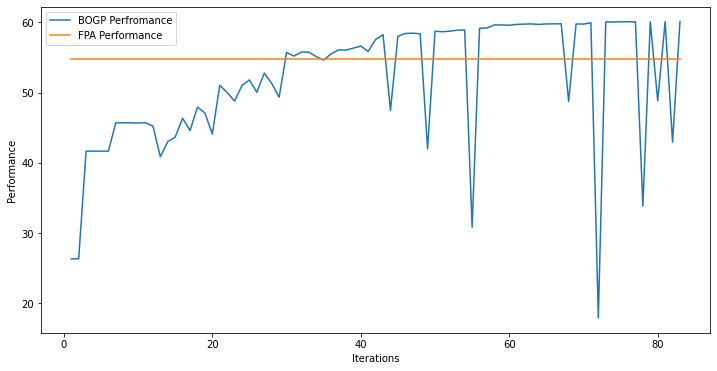

x_next is [ 29.99853746  29.99604315  29.99899699  29.99956449  29.9971296
  26.38644142  14.20589386 -27.37031641  29.99760334  29.98886484
 -29.79943417 -24.71732792  17.60717961  21.55209982 -26.44353997
  29.99766674  23.48545976  15.73535151  23.63908887  25.97117179]
f()=60.142526, actual=60.141
82


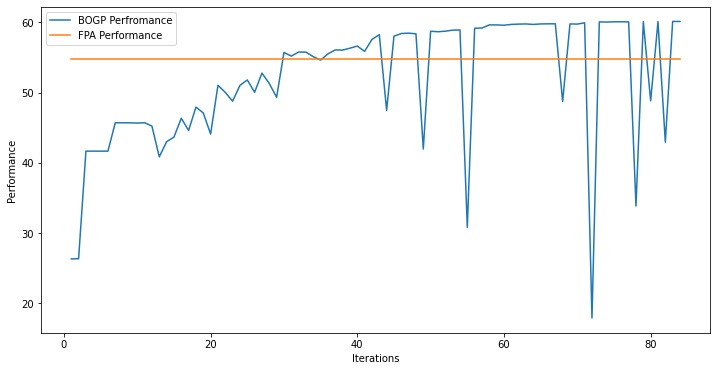

x_next is [  5.15198085  12.69997153   3.78766331  14.63187572 -25.74507522
 -11.12588774   2.65080212 -14.38709811 -28.49759364  13.6582967
  -6.81235843 -25.5624256   25.7910956   11.29644324  28.91837886
  29.70308337 -28.01548916  26.28669411  10.871324     0.10654384]
f()=51.977862, actual=28.966
83


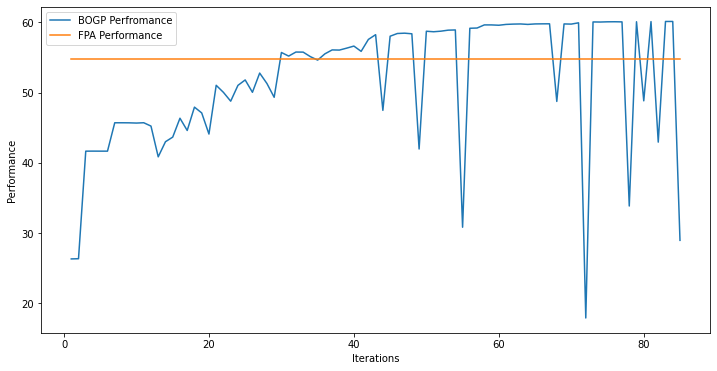

x_next is [-23.06819971  -8.24009817  26.79028835 -22.74170543  -2.32578001
  14.37370794  28.22709094   6.94695851  -7.09247698 -28.64418237
  -7.19578509   4.49383423 -19.79381904 -12.40435363   4.33841736
  26.51404986 -14.20746104  -2.34079358 -23.00500825 -11.86736283]
f()=51.705833, actual=21.391
84


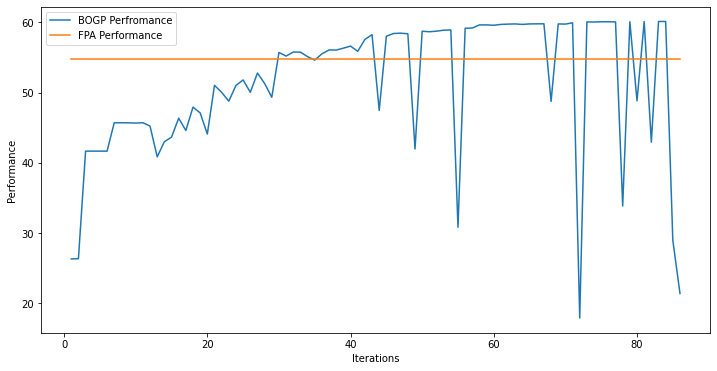

x_next is [ 29.99810187  29.99110049  29.98855482  29.99987303  29.99823091
  26.34674223  14.30044125 -27.5006095   29.99374962  29.99009244
 -29.87093955 -24.63257402  17.71403534  21.37548394 -26.20608964
  29.99112866  23.6021187   15.71995501  23.69489158  25.88590031]
f()=60.140270, actual=60.146
85


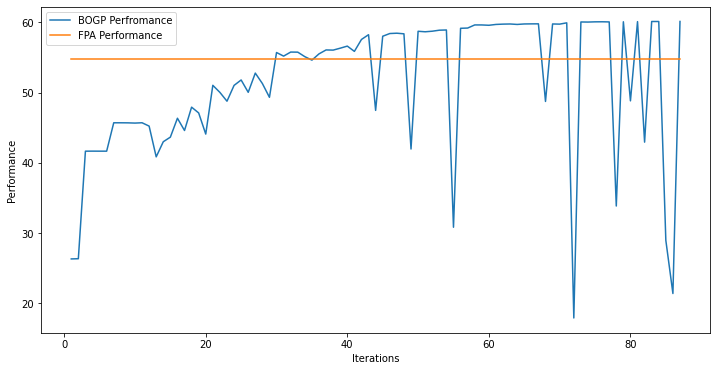

x_next is [ 30.          30.          30.          30.          30.
  26.31059194  14.28916655 -27.51115837  30.          30.
 -29.94273367 -24.73970705  17.73400811  21.29158971 -26.022014
  30.          23.59247745  15.62558262  23.57329084  25.7544958 ]
f()=60.151829, actual=60.154
86


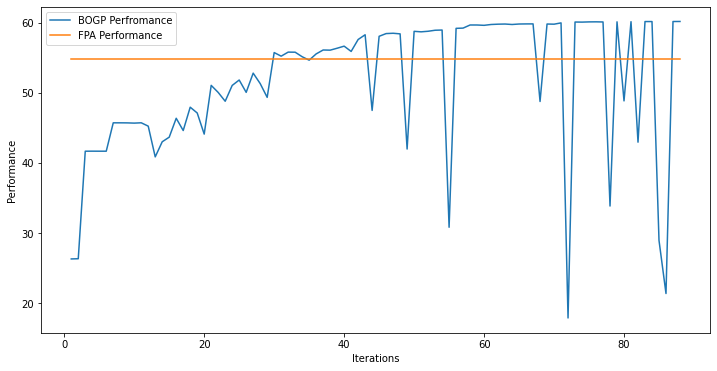

x_next is [ 29.9977457   29.99911512  29.99565367  29.99669899  29.99806019
  26.30438595  14.0282581  -27.52870226  29.9898669   29.99586399
 -30.37959802 -24.71861613  17.69127483  21.44837211 -25.801251
  29.99943586  23.58362668  15.47823007  23.44104234  25.58113378]
f()=60.147170, actual=60.160
87


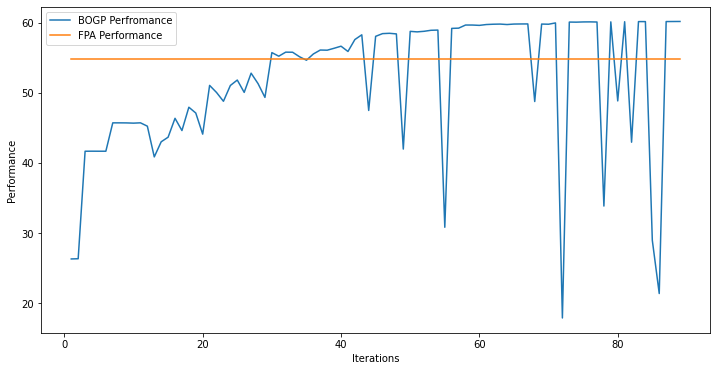

x_next is [ 29.99244204  29.99947164  29.99359297  29.99968942  29.99980813
  26.32047908  13.97380096 -27.55071534  29.99438139  29.9980694
 -30.41858852 -24.66998748  17.57623146  21.49488858 -25.8432332
  29.99718697  23.53547581  15.55975677  23.41131356  25.51715984]
f()=60.160425, actual=60.157
88


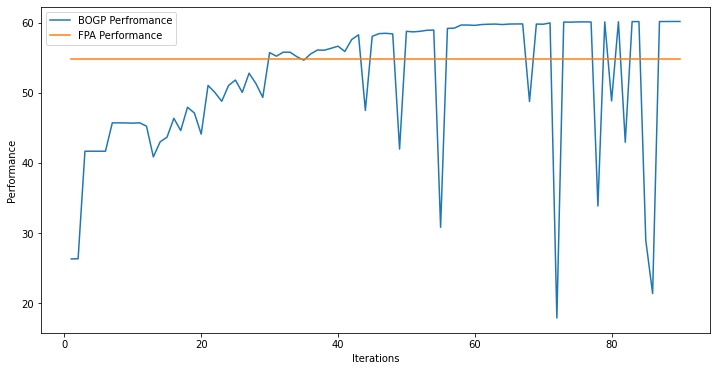

x_next is [ 29.99918759  29.99804593  29.99916207  29.99725037  29.99585952
  26.33031354  13.99259778 -27.27975747  29.99333741  29.96869473
 -30.52079445 -24.9456696   17.85209533  21.55886914 -25.66405869
  29.99466925  23.48653655  15.61325608  23.67150519  25.85973188]
f()=60.160956, actual=60.142
89


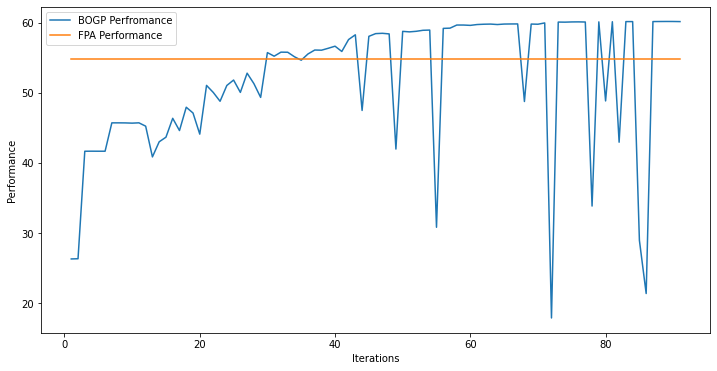

x_next is [ 29.99843703  29.99434563  29.99862442  29.99425643  29.99788865
  26.2071639   13.80637449 -27.55144184  29.99566694  29.99543089
 -30.39226672 -24.64333306  17.68570669  21.20633796 -26.03846717
  29.99967258  23.92435481  15.2511212   23.16110148  25.5471414 ]
f()=60.162217, actual=60.183
90


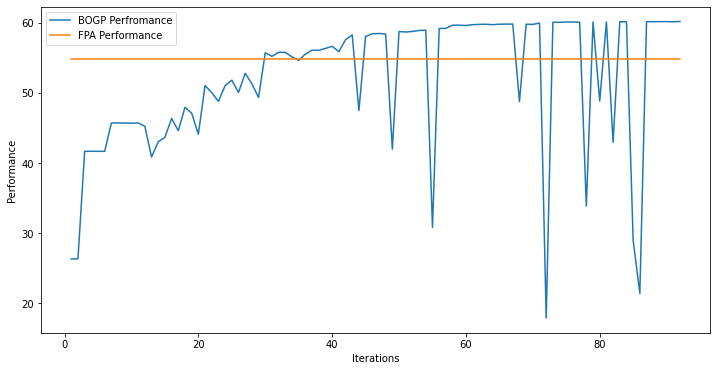

x_next is [ 29.99486745  29.99613547  29.99866943  29.99812841  29.99655139
  26.28727389  13.50074783 -27.66375425  29.98970875  29.99234909
 -30.48815902 -24.53806763  17.52319772  20.76242601 -26.05185798
  29.99878101  23.91705331  15.13224621  22.69064415  25.80518398]
f()=60.186117, actual=60.174
91


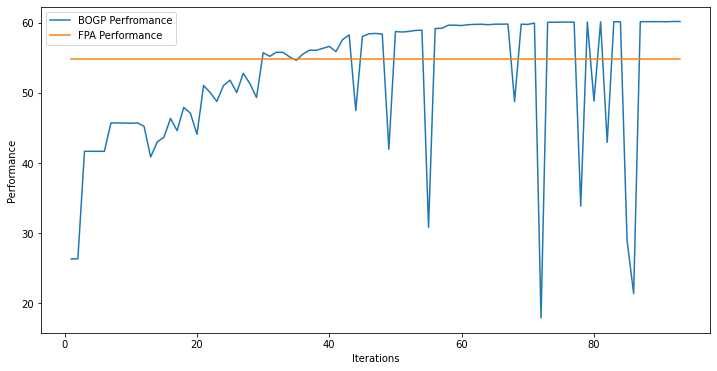

x_next is [ 30.          30.          30.          30.          30.
  30.          17.39658101   6.20262731  30.          30.
 -31.          -2.07549686  10.40162101   5.29657683 -31.
  30.          -7.38431526  14.19681582  -1.05333236  30.        ]
f()=64.352515, actual=49.621
92


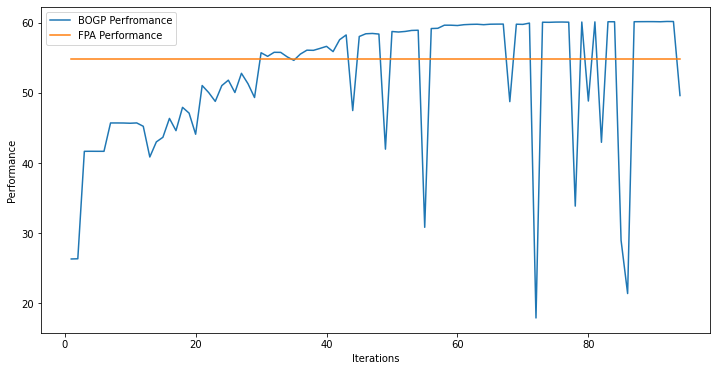

x_next is [ 29.99963407  29.99805101  29.99521981  29.999169    29.99805747
  26.19436336  13.70665549 -27.36417636  29.99302801  29.9959905
 -30.37338264 -24.62037695  17.5368547   21.12546079 -26.04562324
  29.99850654  24.2560766   15.06921626  22.92906282  25.50166111]
f()=60.186309, actual=60.193
93


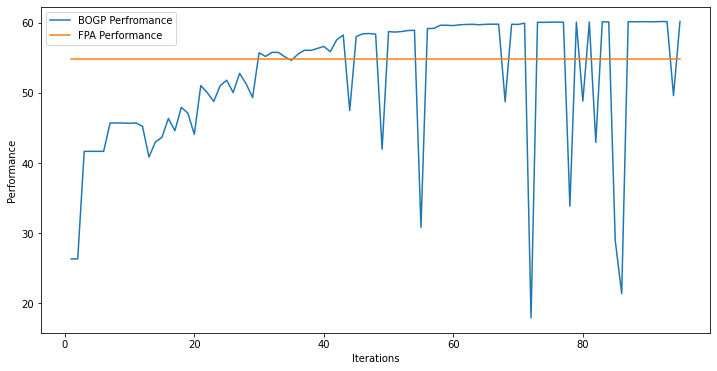

x_next is [ 30.          30.          30.          30.          30.
  26.30219968  13.71497348 -27.26037223  30.          30.
 -30.32281494 -24.57893942  17.51430439  21.17109131 -26.01783209
  30.          24.35260082  15.10627509  22.97894596  25.4558408 ]
f()=60.195300, actual=60.194
94


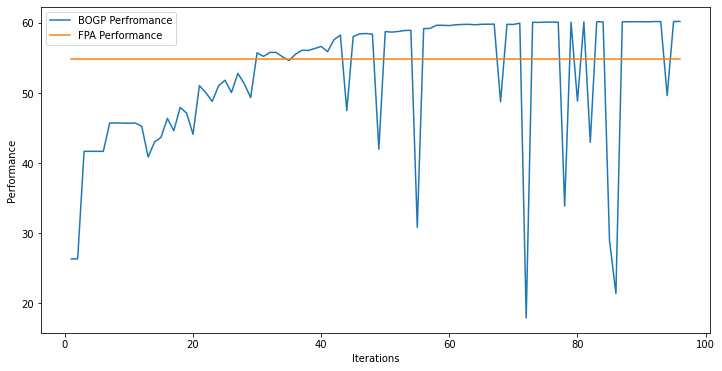

x_next is [ 29.99865771  29.99250126  29.99979966  29.99290933  29.99952408
  26.12012124  13.63390279 -27.43462424  29.98225634  29.97004856
 -30.27119789 -24.59951388  17.36078686  21.18189174 -25.97144909
  29.99294732  24.32547778  15.05036709  22.84720729  25.27650579]
f()=60.189048, actual=60.192
95


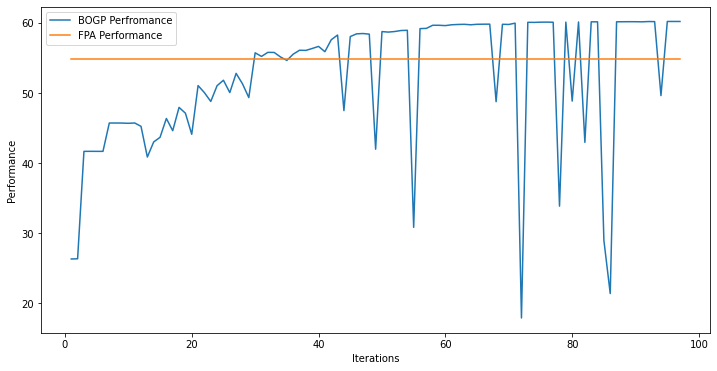

x_next is [  2.59602368   3.97165391  17.01673493  -1.82319785 -18.48991039
 -21.74676099  -1.9296374   23.01080959   8.04973929  -2.33854573
  13.48315415  22.8396921   29.56344747 -19.36494481 -17.87476916
  -7.30529554 -24.40644405  -3.59975522   2.2422933    5.61256601]
f()=28.496104, actual=24.534
96


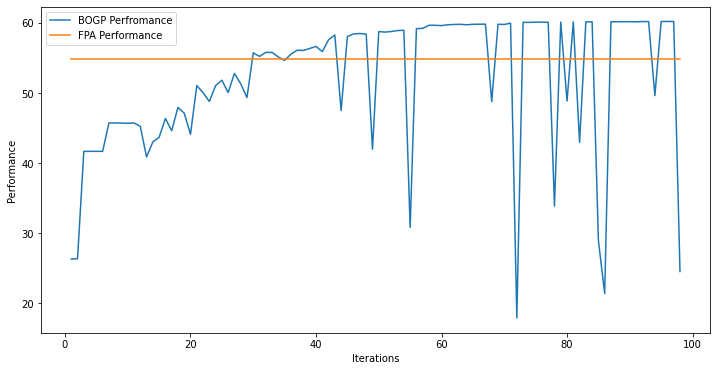

x_next is [ 29.9965019   29.99356087  29.99746924  29.98446962  29.99852982
  26.12192646  13.45225129 -27.36232492  29.99248091  29.97801568
 -30.34182148 -24.7166778   17.37455934  21.16449435 -25.88523254
  29.99765572  24.34970557  14.89132621  22.85533258  25.23769067]
f()=60.190856, actual=60.191
97


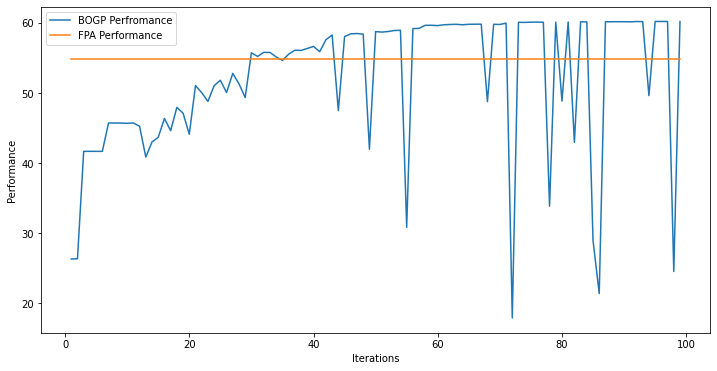

x_next is [ 30.          30.          30.          30.          30.
  26.14311368  13.67829214 -27.3876101   30.          29.50795085
 -30.23150274 -24.65790099  17.4396679   21.15527288 -25.96842715
  30.          24.34694349  15.02270048  22.92043728  25.3800118 ]
f()=60.186040, actual=60.164
98


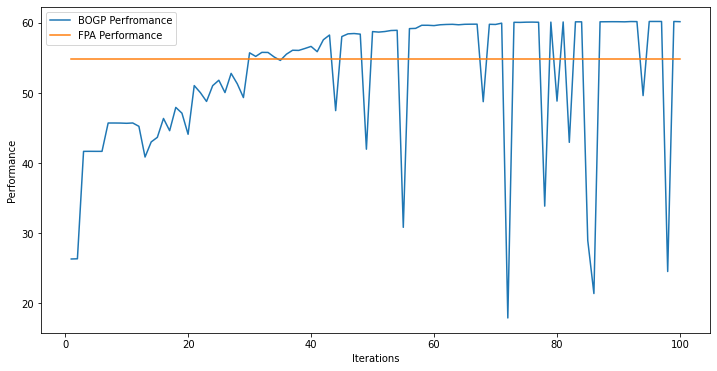

x_next is [ 29.99870384  29.99961586  29.99880704  29.99856302  29.99865592
  26.04276204  13.54450469 -27.34470477  29.99767463  29.99783367
 -30.17137591 -24.63809236  17.3776028   21.13614962 -26.04032644
  29.99405391  24.36850715  15.0528377   22.82692347  25.29575125]
f()=60.195039, actual=60.194
99


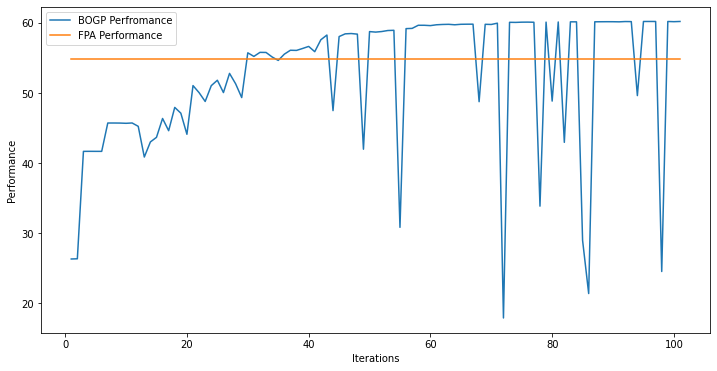

x_next is [ 29.99678544  29.99986589  29.99395253  29.99843457  29.9986989
  26.10592722  13.59561054 -27.47767267  29.99627492  29.99851516
 -30.29586104 -24.65274448  17.38650891  21.20711499 -25.91109319
  29.99765595  24.37676472  15.1173153   22.88100734  25.29446698]
f()=60.195170, actual=60.196
100


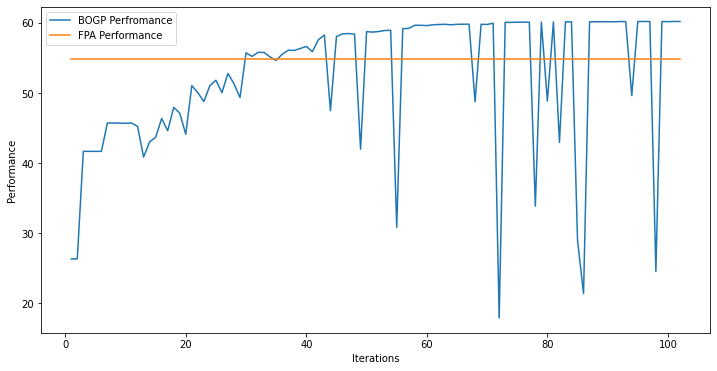

x_next is [ 29.99692966  29.99864252  29.99806737  29.99987915  29.99696762
  26.0497789   13.58274212 -27.50048093  29.99573387  29.998821
 -30.28180523 -24.6054291   17.44308735  21.16850796 -25.87204355
  29.99966805  24.39208551  15.0651614   22.90401234  25.37478652]
f()=60.195720, actual=60.197
101


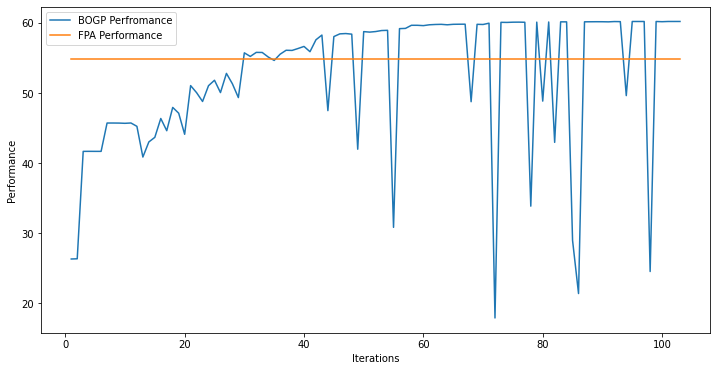

x_next is [ 29.99716244  29.99551216  29.99681985  29.99444594  29.9990622
  26.10713558  13.71546736 -27.57670152  29.99492302  29.99663431
 -30.20534103 -24.54467668  17.4262664   21.27233495 -25.88699445
  29.99188915  24.43092417  15.02768818  22.92366808  25.43183384]
f()=60.195211, actual=60.196
102


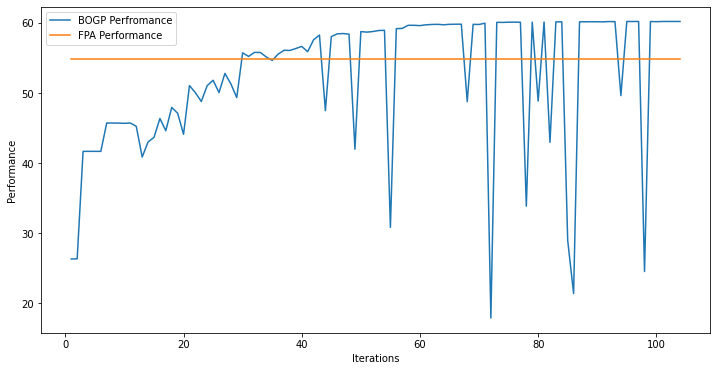

x_next is [ 29.99387097  29.99913735  29.99651852  29.99867447  29.99959287
  26.10819485  13.60462177 -27.48527799  29.99711142  29.99851731
 -30.22138603 -24.62546931  17.38900016  21.32971538 -25.91389408
  29.99922792  24.39493701  15.00486085  22.8614259   25.35246569]
f()=60.197385, actual=60.196
103


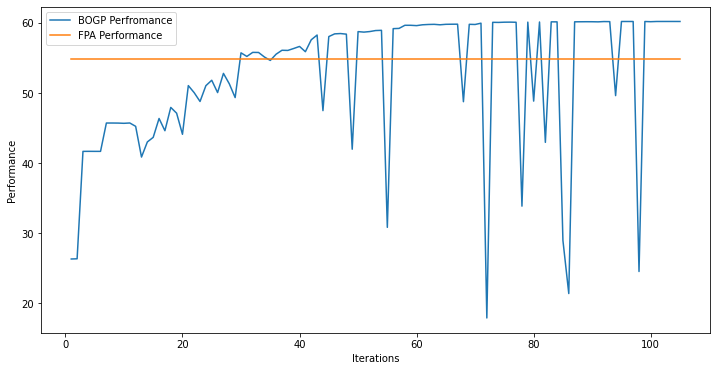

x_next is [ 30.          30.          30.          29.99151347  30.
  26.01739414  13.72195444 -27.52668966  29.98643866  30.
 -30.10422018 -24.44949038  17.28230829  21.15313315 -25.98792196
  30.          24.5630984   14.88513937  22.96218932  25.265289  ]
f()=60.196541, actual=60.194
104


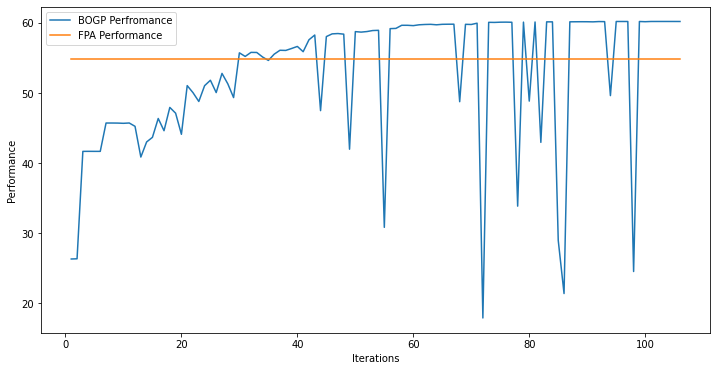

x_next is [ 29.99990719  29.99991346  29.99976265  29.99987341  29.99978812
  29.99999474  29.99997359 -30.9999396   29.99981051  29.99998224
 -30.99996735 -30.99986167  29.99994015  29.9999191  -30.99963703
  29.99961773  29.99990149  29.99959433  29.99965855  29.99994505]
f()=52.581160, actual=48.795
105


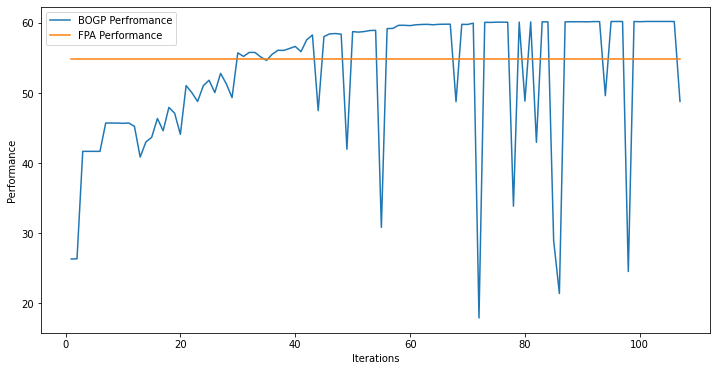

x_next is [ 29.99714681  29.99872955  29.99365251  29.99815548  29.99925482
  26.14489227  13.77383902 -27.49451261  29.99728419  29.98575184
 -30.13038116 -24.52937698  17.42577612  21.07221854 -25.81964718
  29.99139854  24.41972005  14.94700179  23.01740103  25.48635111]
f()=60.195424, actual=60.193
106


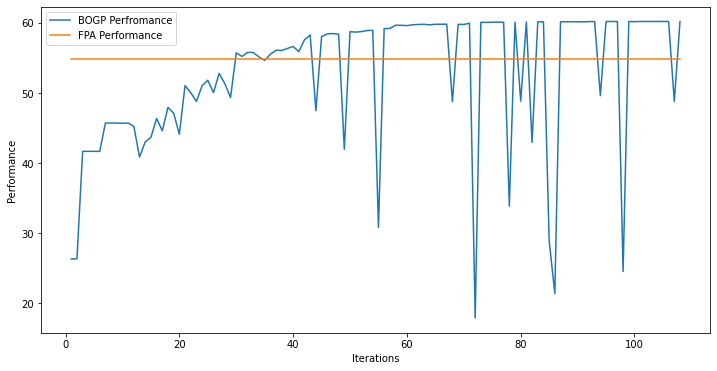

x_next is [ 22.5802289  -27.19027963  -0.28469615  25.77497797  -6.3897217
 -13.04433331  -8.04527567  17.39979151  -5.57903012 -20.21774575
 -25.98096255 -16.24137429  23.27871245  18.49494456  -9.14813804
  24.66625527  26.67274278  25.36999087 -14.98816223  29.47847198]
f()=52.616792, actual=35.185
107


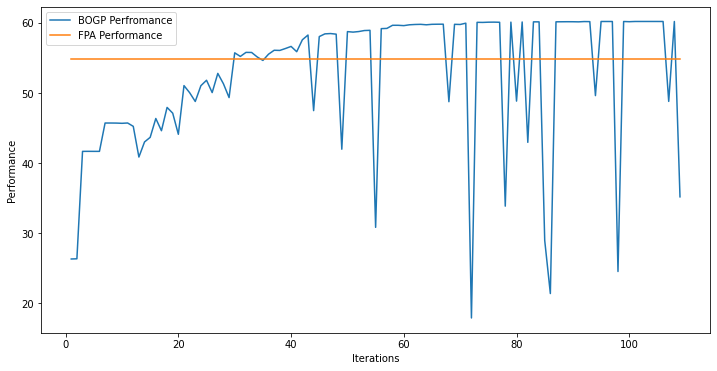

x_next is [ 29.99734979  29.99847111  29.99424731  29.99761492  29.99664459
  26.00400937  13.69165183 -27.6141449   29.99903418  29.99712914
 -30.30285485 -24.50009716  17.42805382  21.28426095 -25.80968368
  29.99915371  24.43961039  15.08322895  22.93080026  25.42998295]
f()=60.197233, actual=60.198
108


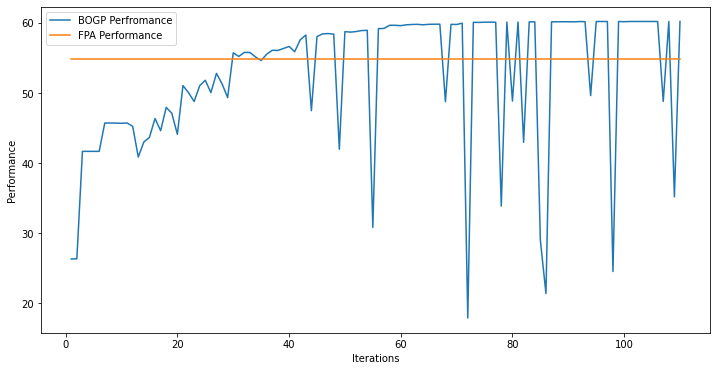

x_next is [ 19.96714838  29.51163717  27.70533432  20.01906126  21.43509029
  28.68860209  26.90224273 -30.70535291  29.43005222  25.39061856
 -27.33623127 -28.19211639  29.67007218  23.23607309 -29.04204051
  25.84098573  26.89604453  21.93460809  26.4887306   27.1399543 ]
f()=52.526941, actual=47.981
109


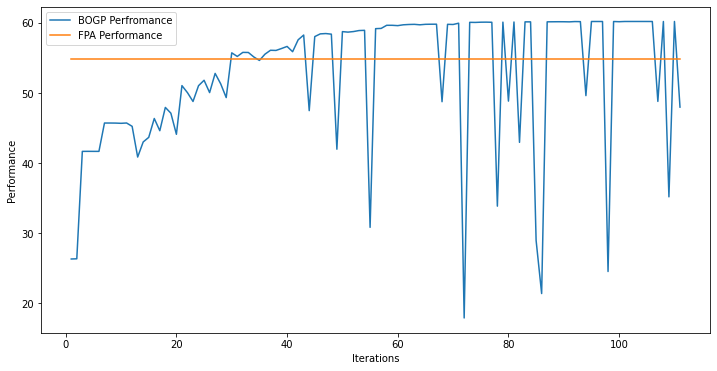

x_next is [ 30.          30.          30.          30.          30.
  26.01307373  13.72652696 -27.61926838  30.          30.
 -30.31861261 -24.48185795  17.47499147  21.25532745 -25.8801402
  30.          24.52013305  15.11445223  22.94055825  25.44647649]
f()=60.200065, actual=60.200
110


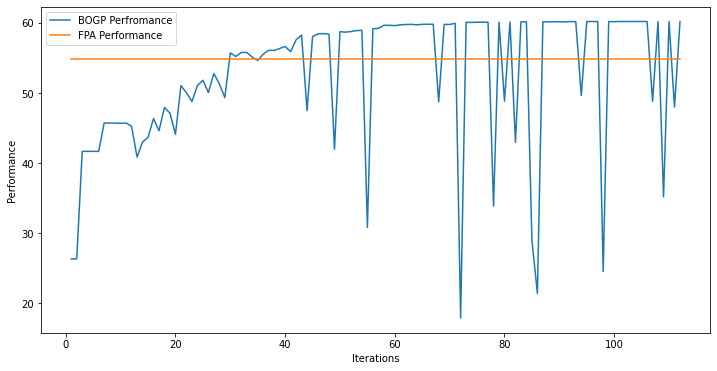

x_next is [ 30.          28.22098953  30.          30.          27.92511518
  22.04384862  12.59328464 -20.39729872  27.16377731  30.
 -30.31483241 -21.67286669  11.06793232  17.39866549 -24.81638693
  30.          20.4588655   13.656723    19.55428986  26.43871928]
f()=61.247895, actual=58.197
111


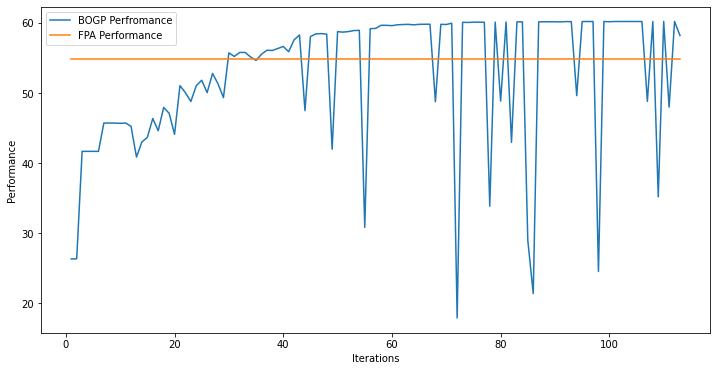

x_next is [ 30.          30.          30.          30.          30.
  26.01394385  13.74489366 -27.61975289  30.          30.
 -30.33018691 -24.48520736  17.492514    21.25531109 -25.89486351
  29.99791324  24.54424989  15.12546433  22.93965071  25.45154895]
f()=60.200215, actual=60.201
112


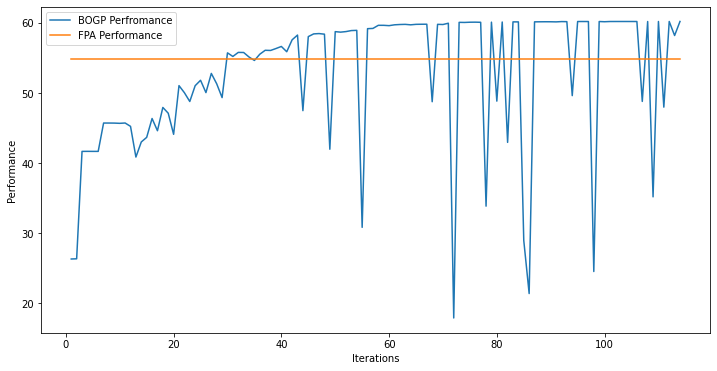

x_next is [ 30.          30.          30.          30.          30.
  25.94172359  13.9201599  -27.55400308  30.          30.
 -30.38153835 -24.61607251  17.61757494  21.26445613 -25.82527704
  30.          24.63610791  15.14279209  22.80899974  25.39670183]
f()=60.204002, actual=60.203
113


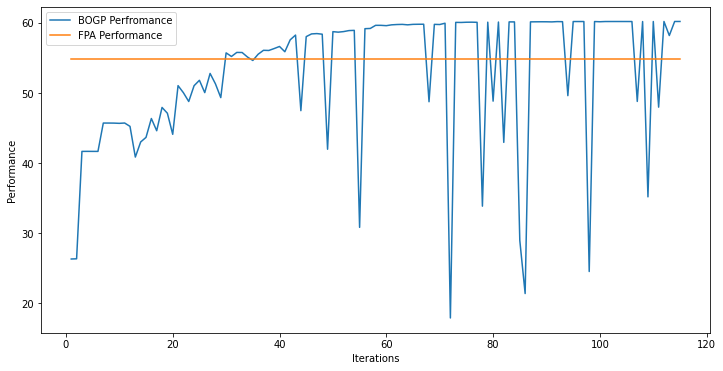

x_next is [ -2.32797848 -18.22535147  -3.31066231   3.95945275  -9.92176187
  10.12267345   2.02597938   5.41560929  26.55436706  -6.38156952
 -22.20929656 -26.74961777  28.3171337  -16.5846035   -2.42996548
   6.24074837 -11.00268664   8.74876655  26.15482256  -3.3388774 ]
f()=44.423121, actual=27.151
114


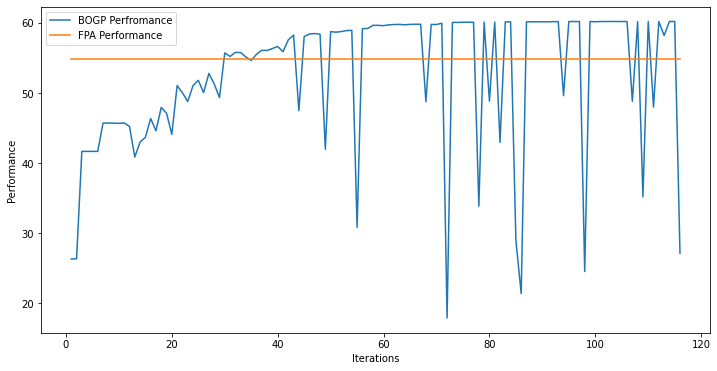

x_next is [ 29.99541489  29.99798318  29.99811683  29.99947201  29.99763151
  25.92457642  13.89061901 -27.57452382  29.99659963  29.99019634
 -30.39383107 -24.70681158  17.58719245  21.16228831 -25.79894149
  29.98130501  24.6215673   14.98764393  22.74531881  25.33243009]
f()=60.199055, actual=60.200
115


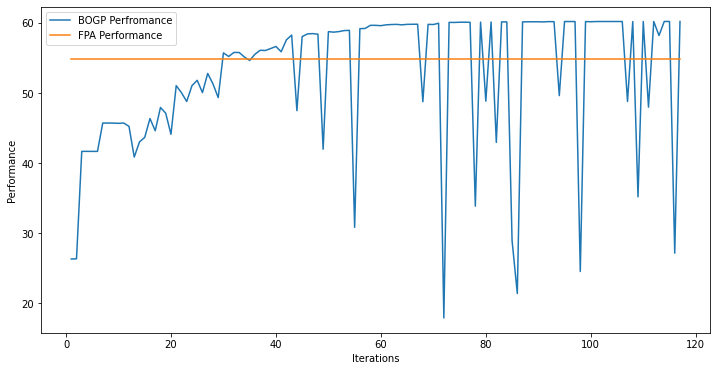

x_next is [ 30.          30.          30.          30.          30.
  25.95732789  13.89279259 -27.58454253  30.          30.
 -30.39563214 -24.6139109   17.5901423   21.25663829 -25.85777432
  30.          24.63300953  15.12751359  22.84576849  25.41732969]
f()=60.203144, actual=60.203
116


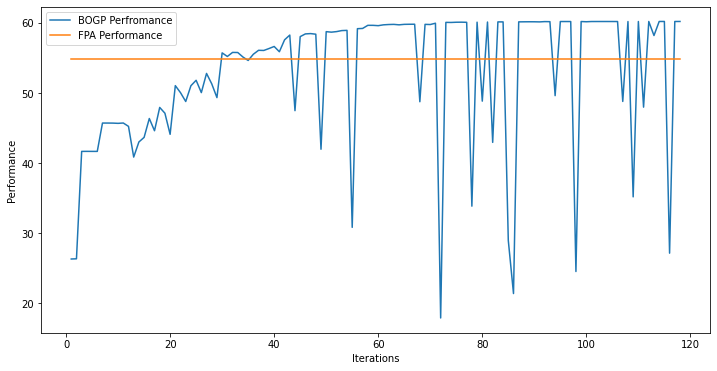

x_next is [ 29.99791321  29.99632069  29.99904232  29.9982906   29.99737867
  25.94946358  13.81607375 -27.6624767   29.99994704  29.99582834
 -30.31901381 -24.53226275  17.61113642  21.18834511 -25.92337818
  29.99780241  24.61334485  15.05881937  22.77753415  25.36206892]
f()=60.201088, actual=60.202
117


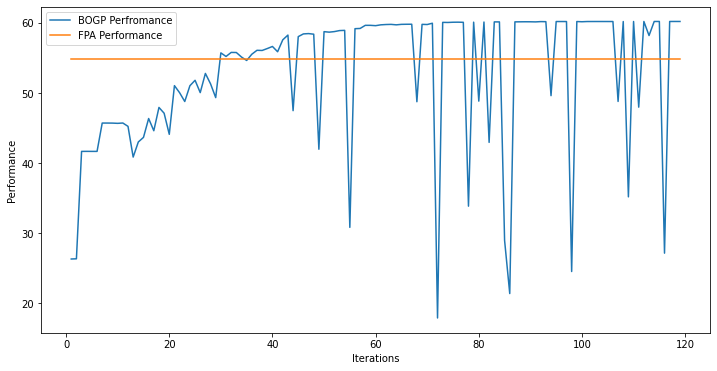

x_next is [ 30.          30.          30.          30.          30.
  25.95990304  13.8252968  -27.62116776  30.          30.
 -30.33884147 -24.50407681  17.6739418   21.21998787 -25.84312831
  30.          24.61811513  15.09142121  22.71239795  25.29195247]
f()=60.204058, actual=60.203
118


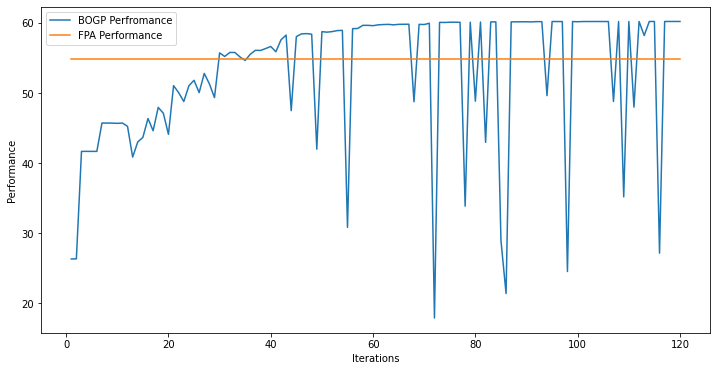

x_next is [ 29.99968241  29.99764181  29.99822736  29.99412595  29.99971522
  25.94751322  13.72978096 -27.61164555  29.99969261  29.99959964
 -30.28920602 -24.54143444  17.63289987  21.1108106  -25.83833704
  29.99945836  24.60405408  15.04057403  22.59889046  25.30537454]
f()=60.202333, actual=60.202
119


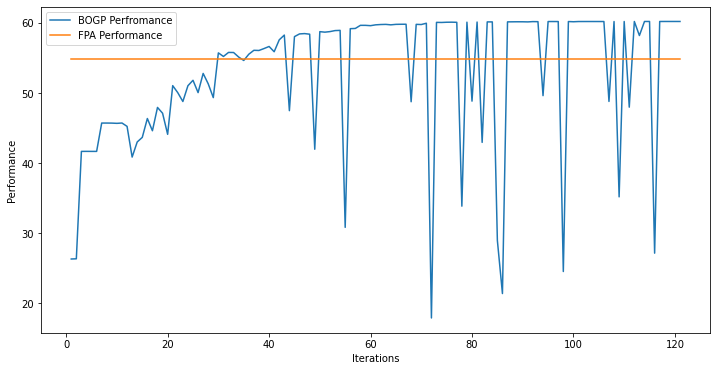

x_next is [ 29.99916738  29.9958056   29.98759331  29.977721    29.99764041
  25.93798844  13.74597355 -27.51120128  29.98997951  29.99777632
 -30.31887932 -24.50874864  17.57782029  21.20824645 -25.92323415
  29.99642395  24.58911154  15.20643185  22.70792785  25.35395305]
f()=60.199655, actual=60.203
120


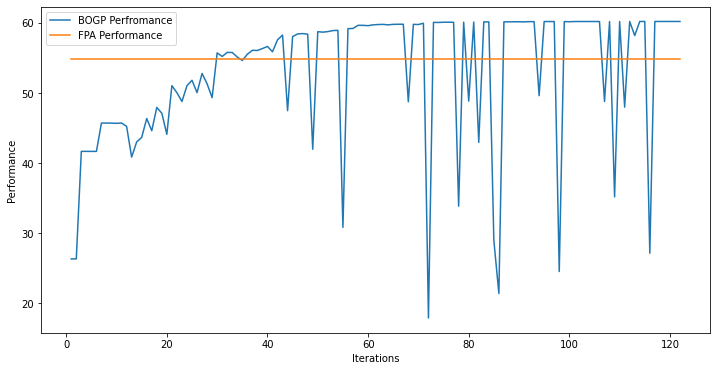

x_next is [ 29.99959077  29.99646664  29.99995171  28.58185693  29.99822836
  25.83054061  13.68708071 -27.50491333  29.9952628   29.99664955
 -30.35619294 -24.53621863  17.57305424  21.27744173 -25.80240828
  29.99925904  24.50859108  15.14555316  22.6255425   25.32123121]
f()=60.217800, actual=60.298
121


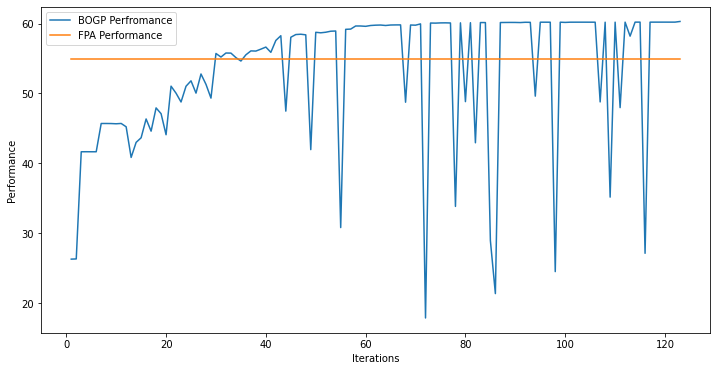

x_next is [ 30.          30.          30.          27.51059687  30.
  25.85355944  13.58158041 -27.44497859  30.          30.
 -30.3355727  -24.53253788  17.44574845  21.23976414 -25.77788879
  30.          24.35525309  15.0759385   22.58376396  25.3288878 ]
f()=60.319948, actual=60.321
122


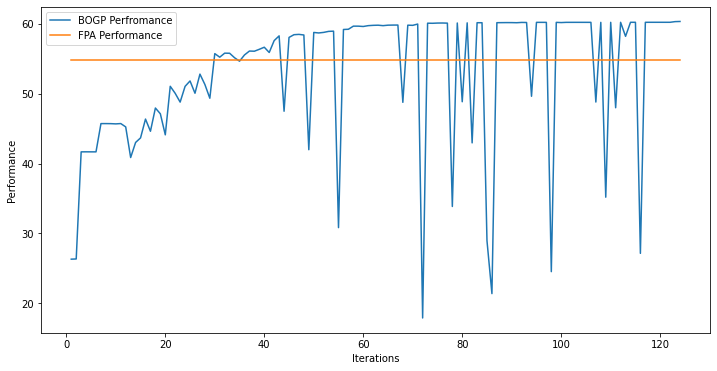

x_next is [ 30.          30.          30.          27.46226842  30.
  25.85148335  13.56737588 -27.44045844  30.          30.
 -30.33486107 -24.5310066   17.43390339  21.23629899 -25.77112776
  30.          24.34225701  15.06793308  22.57213895  25.32509997]
f()=60.321442, actual=60.321
123


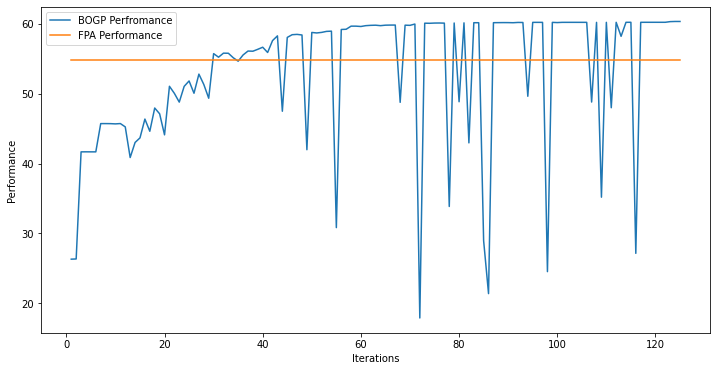

x_next is [ 30.          30.          30.          27.56189231  30.
  25.89024708  13.67612528 -27.4595341   30.          30.
 -30.33206089 -24.54620978  17.49634276  21.26208608 -25.83828543
  30.          24.40560226  15.12479059  22.68050345  25.37673436]
f()=60.321918, actual=60.323
124


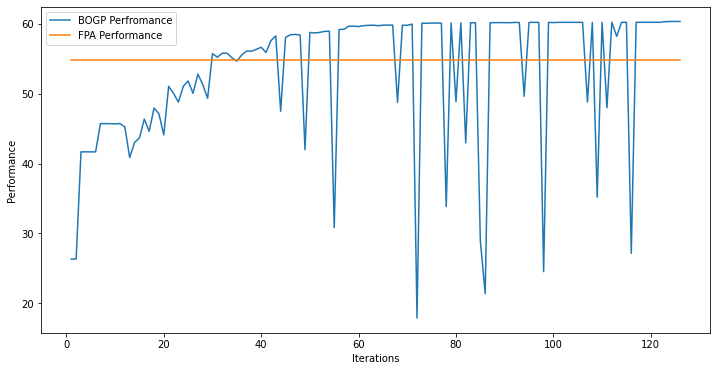

x_next is [ 29.99864587  29.99838416  29.99348712  27.55035996  29.99925812
  26.01269099  13.72854636 -27.54252235  29.99905304  29.99756138
 -30.33973089 -24.51639739  17.47260807  21.34060684 -25.95559247
  29.99742235  24.42059008  15.20349415  22.78572101  25.49905386]
f()=60.322709, actual=60.322
125


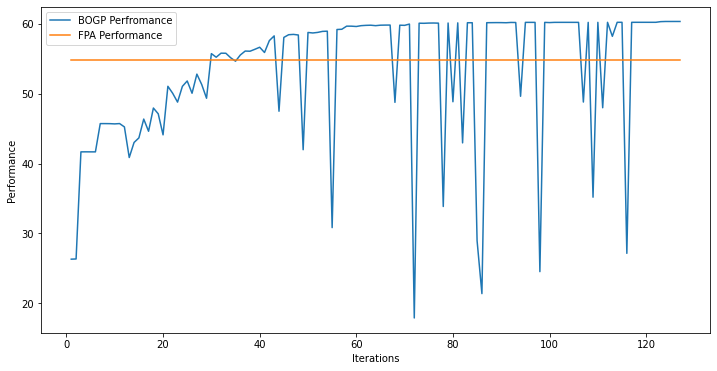

x_next is [ 24.60807641 -17.71684021 -14.55627273 -21.30206935  -9.77774323
  22.12944134 -26.29678758  -5.07593095  -2.03624563  27.58703481
  -7.22469081  -2.9776835   15.73546138  -2.21354263   3.01828883
  -7.96499331  25.3699766  -13.09358303 -16.25883332 -13.87827323]
f()=53.186968, actual=30.224
126


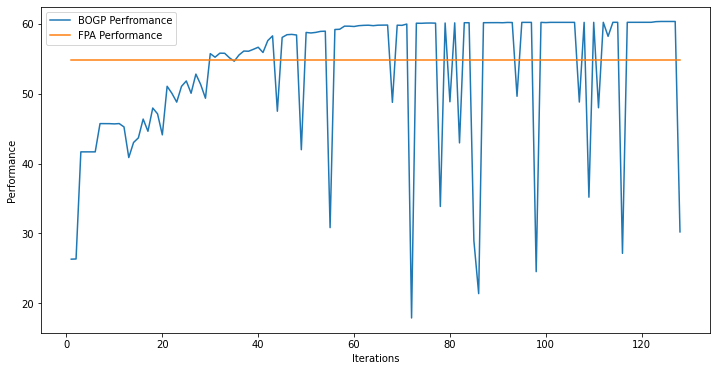

x_next is [ 29.99969453  29.99938579  29.99702653  27.52107508  29.99899462
  26.0088669   13.75780477 -27.49055967  29.99549639  29.99686616
 -30.37021515 -24.53507526  17.49443419  21.30346351 -25.8676485
  29.99991391  24.43878911  15.14102792  22.73187652  25.40271013]
f()=60.322911, actual=60.323
127


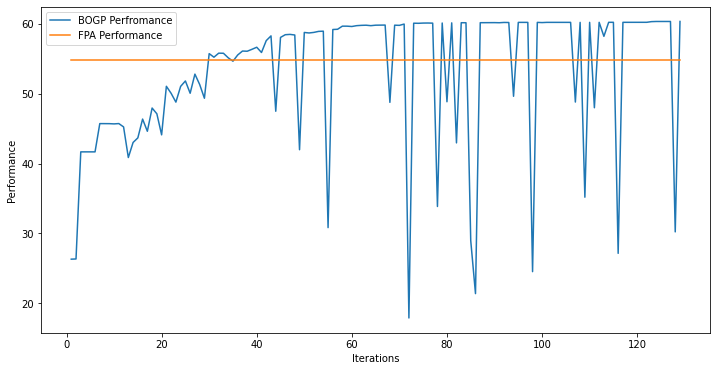

x_next is [ 24.28171597  28.4891288   -9.06348008 -12.81319366  21.35601023
  18.57499337  24.69319848   8.0768878    8.09035109  13.07408769
   8.74004144 -26.72849794  14.02051419  10.35833237  -7.34285728
 -10.1508609    7.89696389  28.42141988   6.10711565  -1.69660838]
f()=53.063808, actual=26.502
128


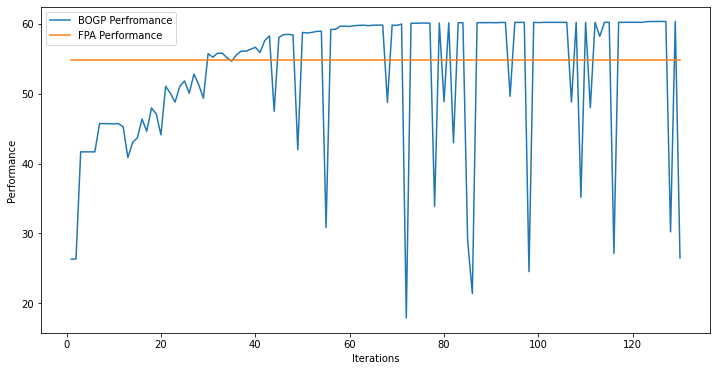

x_next is [ 29.99918189  29.99826576  29.9999584   27.45230733  29.99991947
  25.97949266  13.89473232 -27.49627482  29.99474954  29.99909134
 -30.26494725 -24.66431235  17.55197283  21.34887607 -25.84641198
  29.99275974  24.36060586  15.06839259  22.88799876  25.42337021]
f()=60.322182, actual=60.322
129


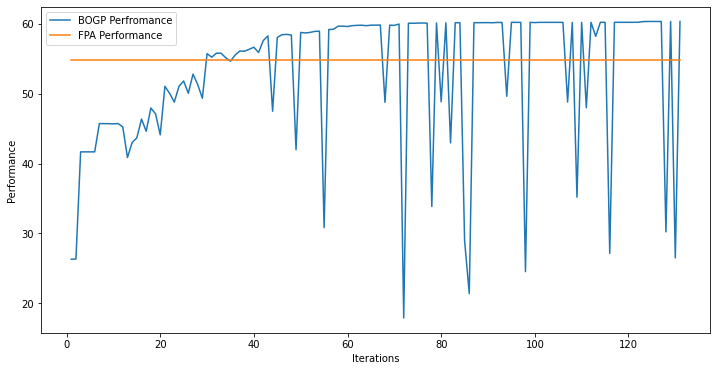

x_next is [ 29.92334942  29.97116193  29.92478248  27.48718789  29.96333446
  25.08924324  13.46101588 -27.56973172  29.94474302  29.9501694
 -29.83118904 -24.29725583  17.49700671  20.86013125 -26.33128808
  29.96563121  23.67331549  15.25434154  22.53180294  25.46040472]
f()=60.253016, actual=60.281
130


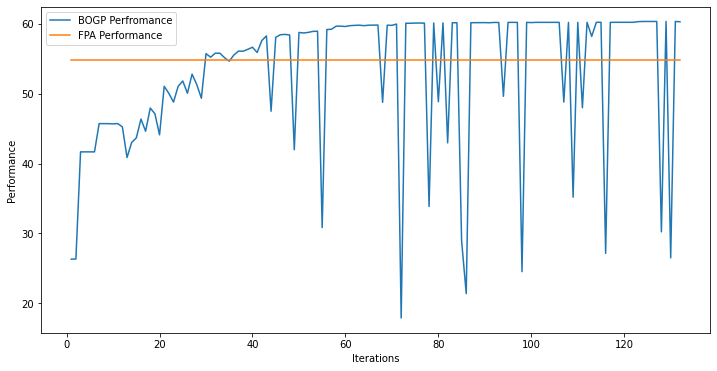

x_next is [ 14.42363171  -4.30499074 -20.22199465   1.89607472  24.52461658
  19.98653981  20.12861564  10.64889371  -7.56588722  15.78362404
 -18.02300325  -5.7594879   13.81883575  20.60227653  22.51806192
  -4.67052112 -20.02711223  -3.30521271  21.91328374 -16.55199212]
f()=24.283235, actual=37.738
131


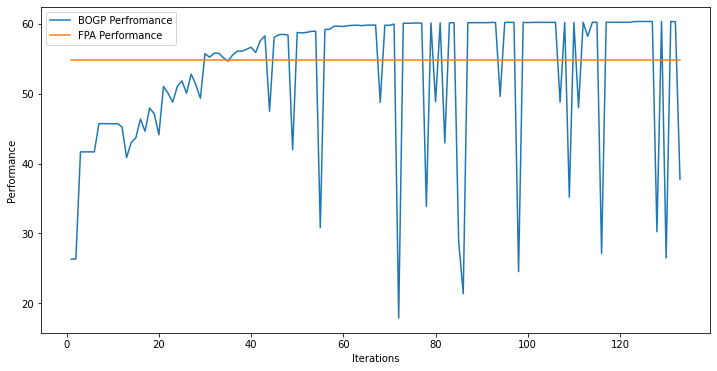

x_next is [ 30.          30.          30.          27.41146401  30.
  25.87075663  13.94652596 -27.53036102  30.          30.
 -30.2976601  -24.38905243  17.59618261  21.12841122 -26.11848011
  30.          24.30706967  15.17947255  22.74599424  25.35584327]
f()=60.327651, actual=60.321
132


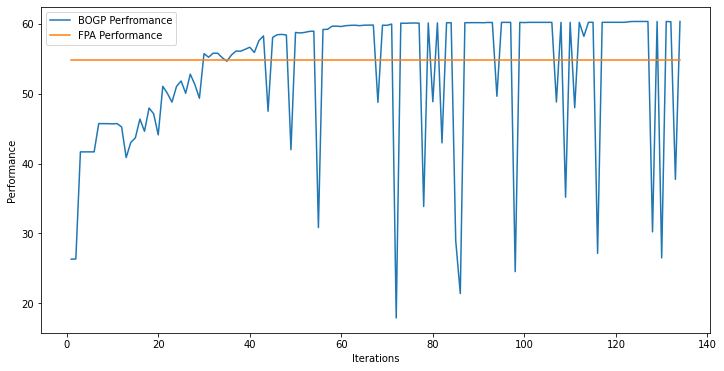

x_next is [ 30.          30.          30.          27.50117021  30.
  25.96861126  13.80827627 -27.47941133  30.          30.
 -30.31273307 -24.58710052  17.55070854  21.29958304 -25.87460317
  30.          24.40365695  15.19332856  22.80642033  25.44187287]
f()=60.324437, actual=60.324
133


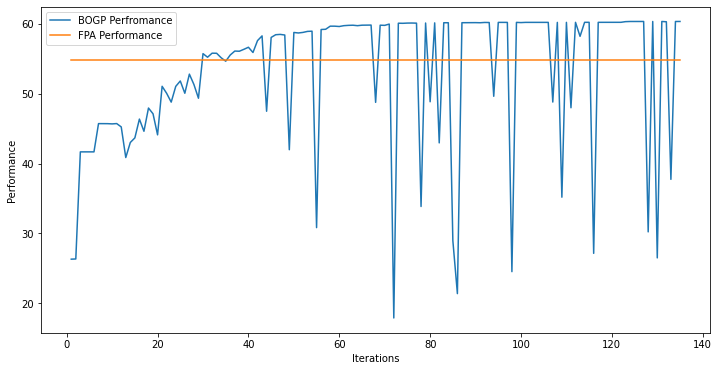

x_next is [ 29.99721701  29.9998166   29.99008074  27.50793647  29.99849471
  25.98256952  13.82108971 -27.52729828  29.99237738  29.99405249
 -30.31144596 -24.62163288  17.44286227  21.36281844 -25.92189863
  29.99487291  24.4783565   15.20259449  22.85971318  25.39889605]
f()=60.321664, actual=60.322
134


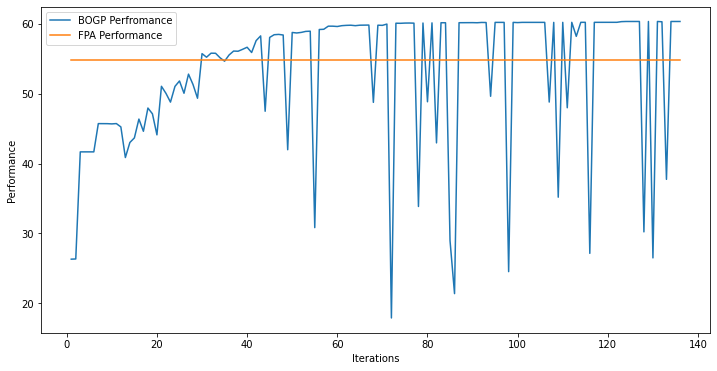

x_next is [ 29.86065623  29.89944913  29.90438868  29.64751554  29.88743784
  29.94025223  29.75047354 -30.82096508  29.71695659  28.92668109
 -30.93131343 -30.31699259  29.83119703  29.73951655 -30.99506874
  29.93444053  29.95850674  29.26237185  29.22842686  29.96806509]
f()=53.021831, actual=49.017
135


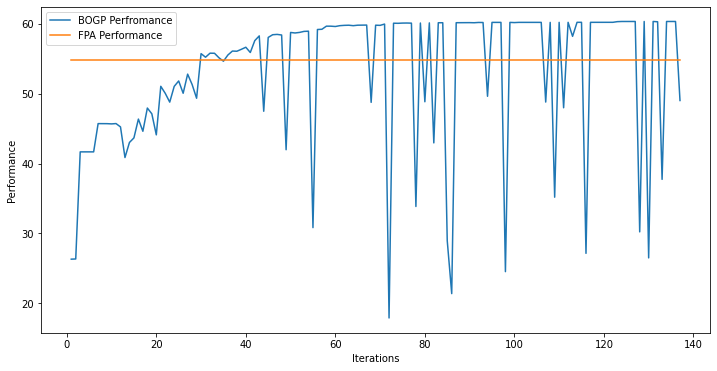

x_next is [ 30.          30.          30.          27.49889886  30.
  25.94659902  13.8145704  -27.49789714  30.          30.
 -30.29339596 -24.61042804  17.48890418  21.31038057 -25.91032287
  30.          24.44764325  15.19504083  22.8340769   25.37599543]
f()=60.324630, actual=60.324
136


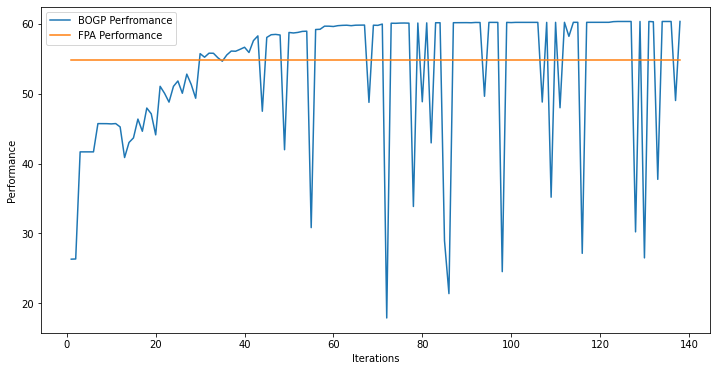

x_next is [ -2.62060562  -4.27223823 -17.71903288  15.13012547 -22.13660526
 -25.84216557  18.38184553  21.51531811 -17.78554201  19.73344245
   4.19944499  29.72213607  -1.97763581  -0.34723032 -11.6900802
   0.7980557  -12.9889889  -28.89572961 -28.80426765  -5.9550233 ]
f()=53.045866, actual=23.422
137


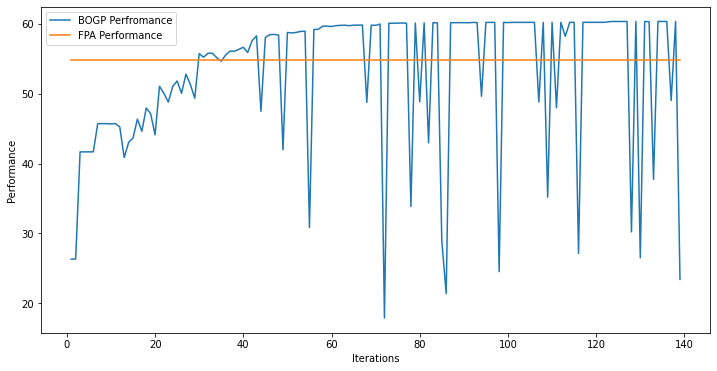

x_next is [ 30.          30.          30.          27.47916629  30.
  25.8807579   13.90624803 -27.49854416  30.          30.
 -30.42005014 -24.62458463  17.49333808  21.38387221 -25.84498347
  30.          24.44786883  15.21510764  22.81843466  25.52790882]
f()=60.325525, actual=60.323
138


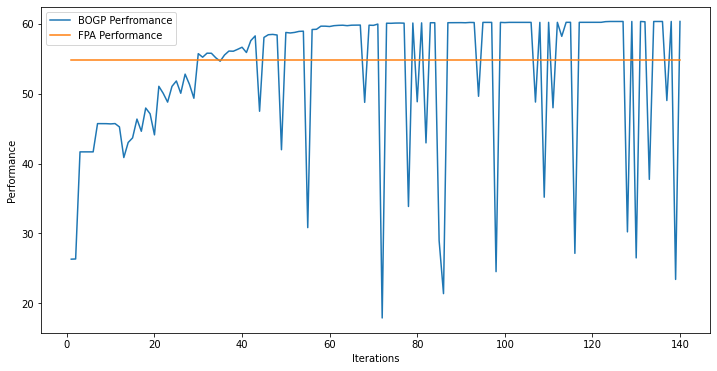

x_next is [ 30.          30.          30.          27.51563471  30.
  26.03195052  13.81869832 -27.47839487  30.          30.
 -30.27714665 -24.61817918  17.53712544  21.35470419 -25.86537932
  30.          24.45972006  15.21304351  22.84105302  25.44687936]
f()=60.324502, actual=60.325
139


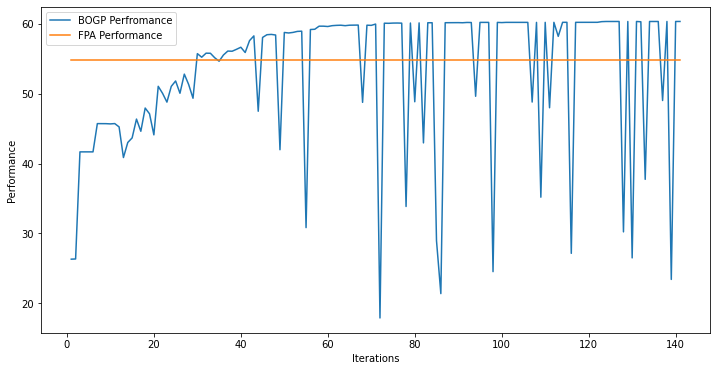

x_next is [ 30.          30.          30.          27.51513258  30.
  26.0355742   13.82113208 -27.47413314  30.          30.
 -30.26824701 -24.61670108  17.53928186  21.35980355 -25.86479978
  30.          24.46573228  15.2148319   22.83939017  25.44901496]
f()=60.324554, actual=60.325
140


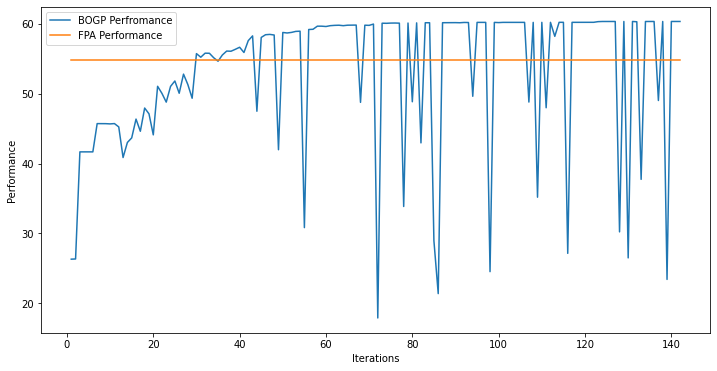

x_next is [ 30.          30.          30.          27.49319945  30.
  26.00581865  13.84003751 -27.43805686  30.          30.
 -30.19211803 -24.55820294  17.54244539  21.3817389  -25.87661915
  30.          24.46903336  15.2043345   22.79501663  25.45981521]
f()=60.324920, actual=60.324
141


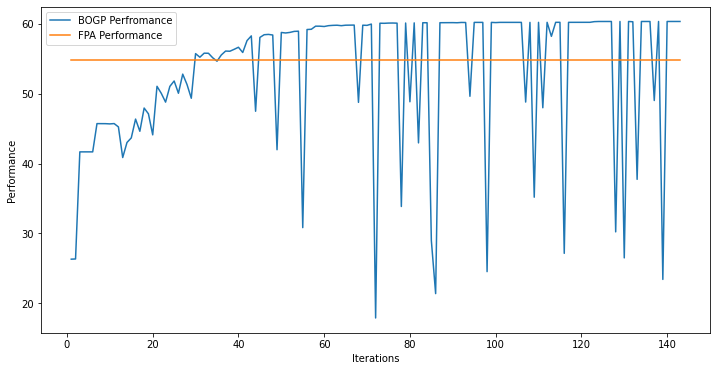

x_next is [ 29.99452827  29.99320302  29.99617071  27.39242517  29.99795591
  25.96614446  13.63213967 -27.3801487   29.98184363  29.99445246
 -30.27290486 -24.51398859  17.4369046   21.48033401 -25.9034873
  29.99885896  24.41424313  15.19834671  22.64843499  25.36569385]
f()=60.319511, actual=60.321
142


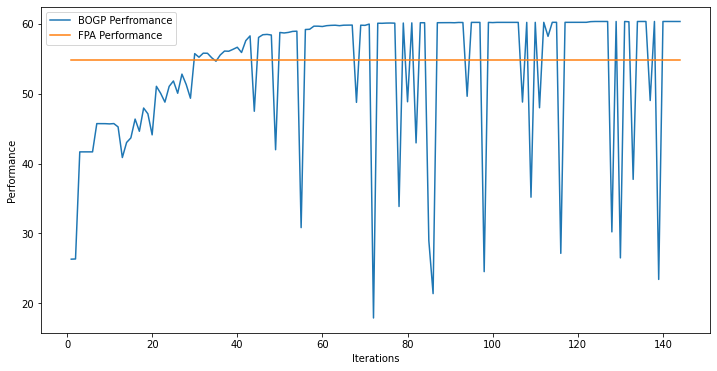

x_next is [ 29.98155762  29.99297448  29.96695472  27.15473844  29.99575723
  25.91513335  13.6958232  -27.48300697  29.99927318  29.99319345
 -30.28166653 -24.70341604  17.65975907  21.38894202 -26.18561377
  29.94674117  24.1961349   15.11841569  22.77024905  25.4728738 ]
f()=60.315099, actual=60.319
143


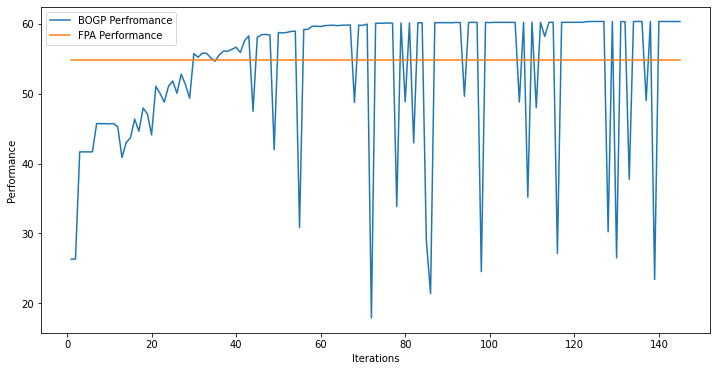

x_next is [ 29.97084399  29.98708372  29.99856991  27.17688299  29.99875958
  25.73828821  13.47881649 -27.29455244  29.98501094  29.97477361
 -30.34455867 -24.7663167   17.57689245  21.32430139 -26.14464504
  29.968822    24.1534687   15.10240476  22.64756031  25.53770735]
f()=60.316887, actual=60.319
144


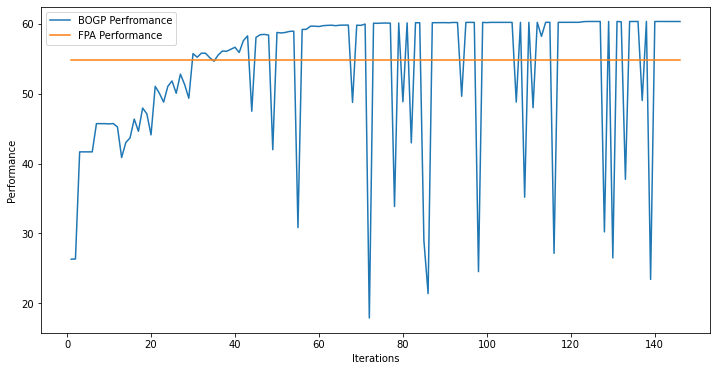

x_next is [ 30.          30.          30.          27.37778309  30.
  25.86588674  13.71063045 -27.32688723  30.          30.
 -30.28796604 -24.76654383  17.67013579  21.27860692 -26.16317313
  30.          24.45632956  15.13431713  22.66877239  25.50470403]
f()=60.327724, actual=60.325
145


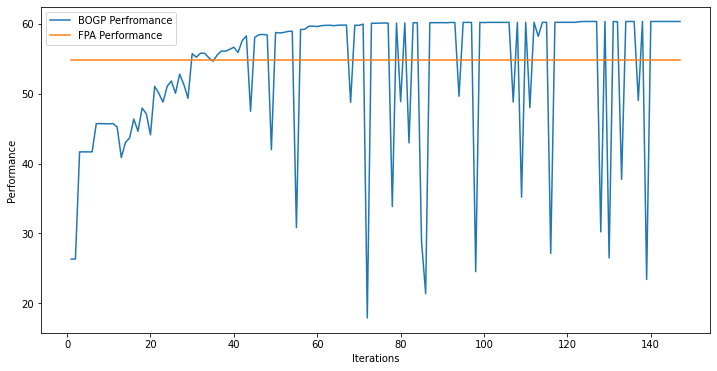

x_next is [ 29.95516398  29.99883868  29.96580346  27.40467677  29.99453582
  26.09523726  13.59413523 -27.54597959  29.97016789  29.99656235
 -30.36358552 -24.7080925   17.52837692  21.0603851  -26.08629746
  29.97964706  24.16380657  15.13921479  22.6840667   25.60748278]
f()=60.314842, actual=60.322
146


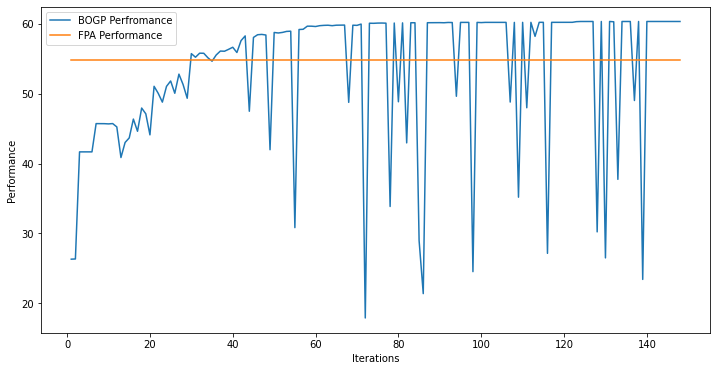

x_next is [ 29.41619571   3.38120436  22.32412843  24.70042415  26.39978875
  13.04685065 -22.45511559 -25.91780071  29.58248543  27.09689763
 -27.5039379   19.21333199 -24.83378825  25.48947015  -7.6195985
  27.65135194 -20.77538011  22.40783108 -26.79735173  25.78126474]
f()=57.038813, actual=42.478
147


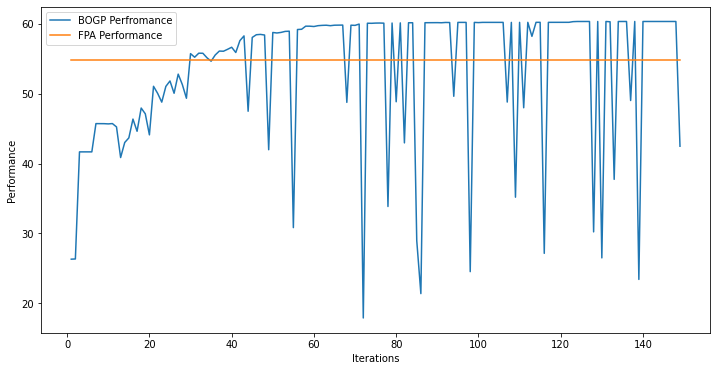

x_next is [ -3.50158761  27.97753311 -24.69300004   9.9815702   17.58215201
  19.83957615 -21.34763435   1.3877941   12.56410133 -29.53063226
   8.68807997  11.95222671   4.85225113 -10.42190255 -16.05924659
  17.27181442 -28.1872981  -15.66631934  -6.57963961  26.94755366]
f()=34.328753, actual=30.990
148


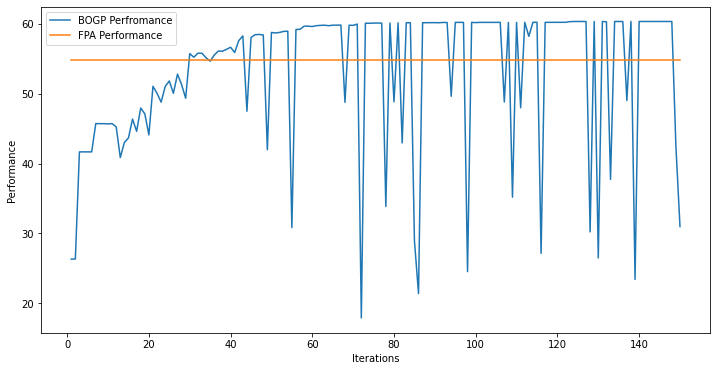

x_next is [ 30.          30.          29.99999997  27.24859346  30.
  26.08922912  13.69331137 -27.38370741  29.99999999  30.
 -30.21870866 -24.9240922   17.45168997  21.15534755 -26.13814595
  30.          24.16195053  15.23092487  22.60460471  25.61812513]
f()=60.330304, actual=60.316
149


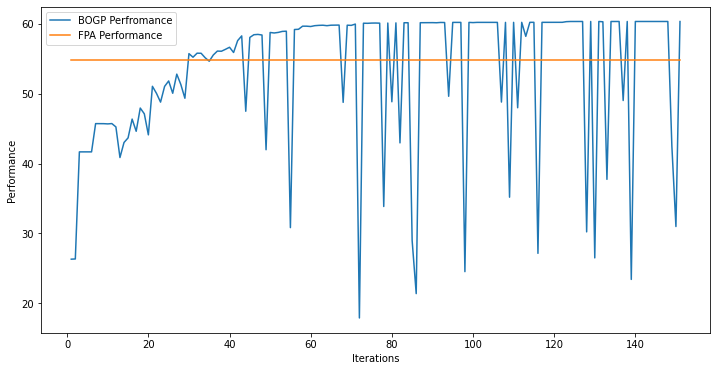

x_next is [ 29.70855872  30.          30.          27.30824476  30.
  25.92421061  13.40908036 -27.45927215  29.99999999  30.
 -30.41942253 -24.58007769  17.76396848  21.12747347 -26.11363772
  30.          24.38230181  15.05177134  22.81526344  25.57263323]
f()=60.331789, actual=60.370
150


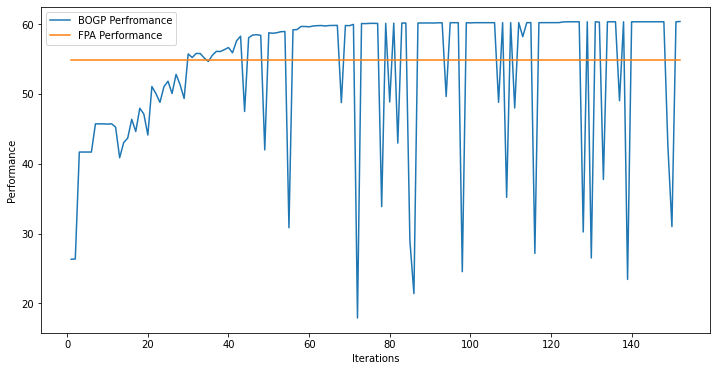

x_next is [ 26.84768435  29.99433305  29.98365042  26.86922205  29.99661822
  25.81175354  12.64454156 -27.43142639  29.99820961  29.99656771
 -30.36229977 -24.25141844  17.40923886  20.97137396 -25.87585592
  29.99932892  24.06029227  14.67760431  22.30833681  25.25954976]
f()=60.509709, actual=60.553
151


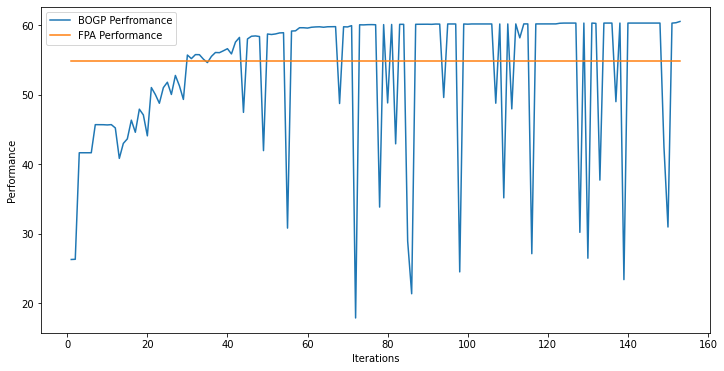

x_next is [ 26.43564466  29.99723524  29.9710241   26.88195681  29.99523338
  25.67817355  12.27911014 -27.41883336  29.99132125  29.99482215
 -30.32602552 -24.35133014  17.11585471  21.04230602 -25.76904631
  29.98244902  23.70507502  14.69458873  21.94142898  25.13581988]
f()=60.549150, actual=60.556
152


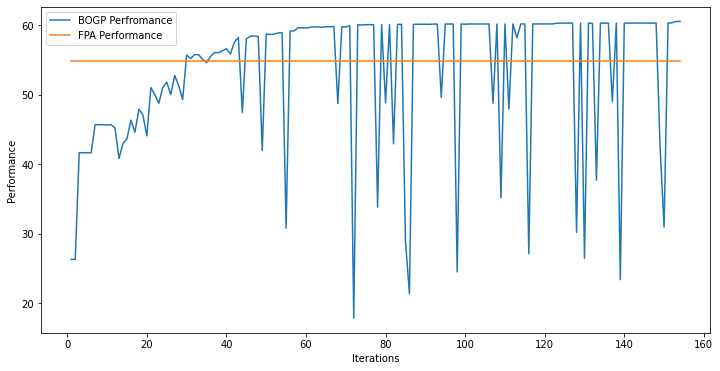

x_next is [ 26.41028075  30.          30.          26.86909276  30.
  25.73145629  12.36473265 -27.39096672  30.          30.
 -30.33978485 -24.31229645  17.22672122  20.97244513 -25.68477228
  30.          23.692294    14.66463787  22.0152769   25.10921368]
f()=60.561464, actual=60.556
153


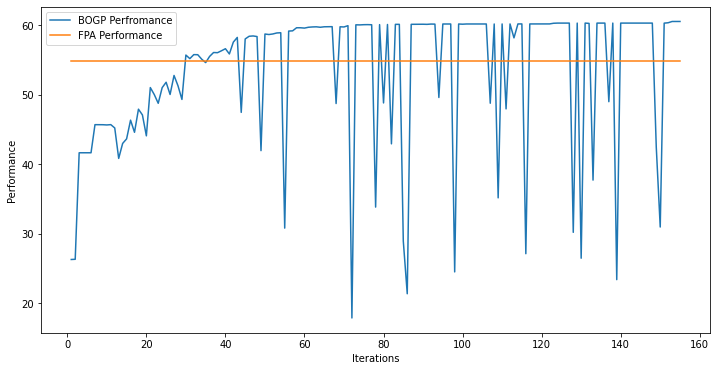

x_next is [ 26.55944693  30.          30.          26.83524756  30.
  25.64540612  12.24297911 -27.69996518  30.          30.
 -30.33838573 -24.41753299  17.05032072  21.13196333 -26.00064714
  30.          23.87661919  14.71788522  21.95439686  25.26565713]
f()=60.563095, actual=60.554
154


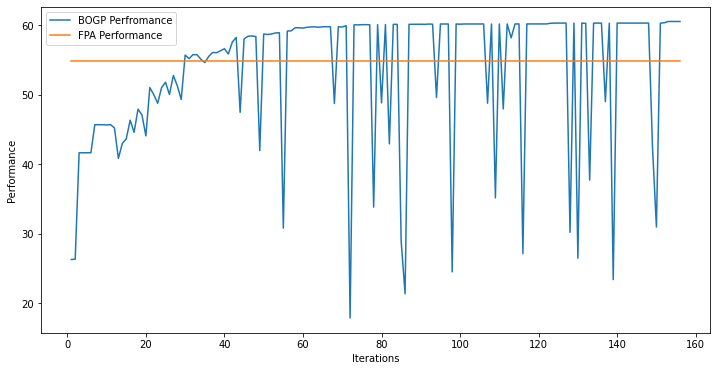

x_next is [ -3.59514185  26.31258091 -28.02871579   3.83542848 -25.75304774
   5.50460665 -29.01346648 -20.60586058  26.06730522   7.84661718
  -4.02243556   7.43852756 -28.40317703  18.93324685  23.90710365
   1.38075091 -17.41537267 -29.04192861 -14.38873817  -0.88744869]
f()=53.352453, actual=27.334
155


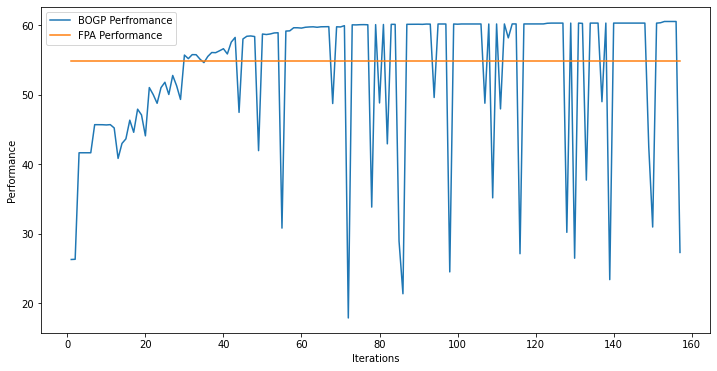

x_next is [ 26.46674255  29.99695627  29.96980456  26.84196235  29.99862536
  25.57480332  12.09215846 -26.83778624  29.9999983   29.99797194
 -30.19191064 -24.43253397  16.97577223  21.14340368 -25.84860097
  29.98444546  23.85433155  14.62683807  21.99101827  25.16515219]
f()=60.560820, actual=60.547
156


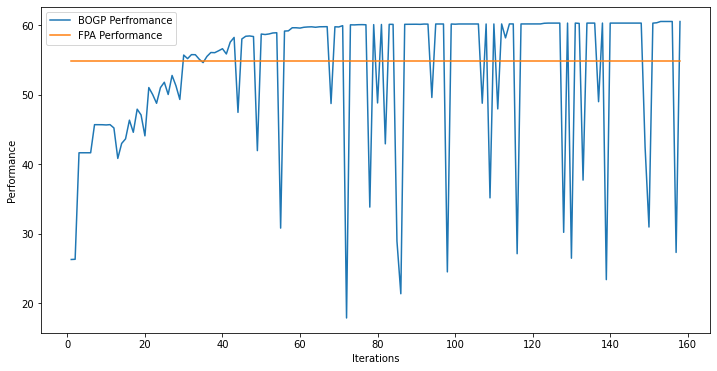

x_next is [ 26.74442647  29.99999999  29.94706426  26.23902927  30.
  25.67892392  12.5677694  -27.3913605   29.95380637  29.98799987
 -30.23569871 -24.18283217  17.12530809  21.1267624  -25.91460916
  29.99999999  22.9240789   14.86724798  21.98924835  25.07609807]
f()=60.527182, actual=60.551
157


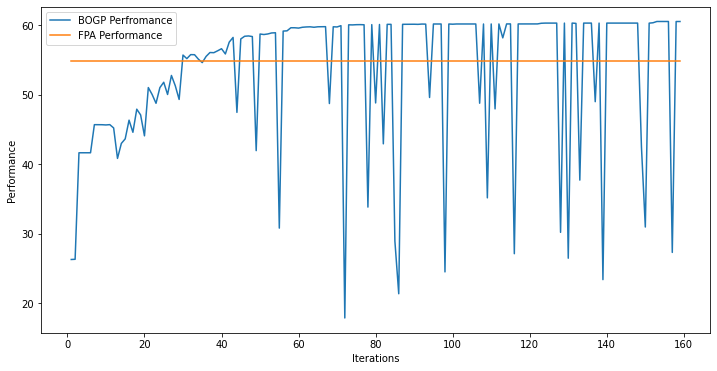

x_next is [ -2.18733751   0.10200189 -23.48966835 -17.27475153  26.72287202
  23.13984449   4.48715201  19.04292469  19.37312865  -8.20340039
  -7.5987619   -1.95077629  10.32953778 -26.3781331    6.72076993
  26.33740389 -29.16355128  28.0350687   -9.63893824   9.56567962]
f()=53.278976, actual=32.408
158


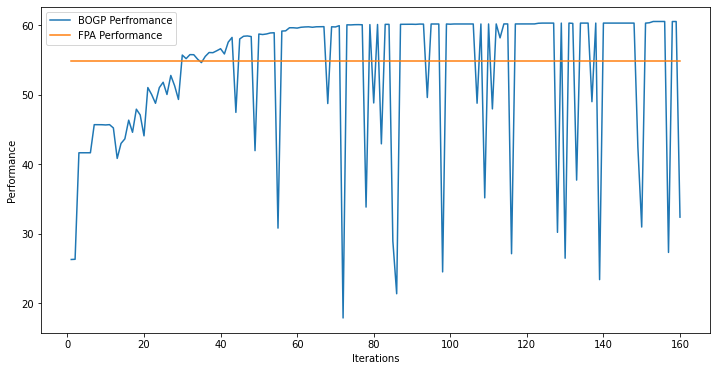

x_next is [ 26.67290881  30.          30.          26.78864578  30.
  25.68711219  12.51544193 -27.28360192  30.          30.
 -30.32984572 -24.15998384  17.03618679  21.18703083 -25.98774852
  30.          23.48080399  14.90928712  21.90356889  25.11366842]
f()=60.568181, actual=60.572
159


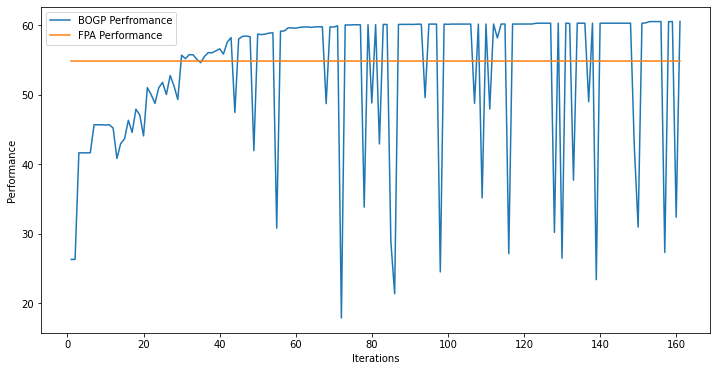

x_next is [ 26.64792634  30.          30.          26.84581182  30.
  25.70508204  12.57545194 -27.21802276  30.          29.97637569
 -30.34918149 -24.0789187   17.28009225  21.30052264 -26.04094582
  30.          23.45387088  14.96257563  21.85259618  25.10077479]
f()=60.568791, actual=60.560
160


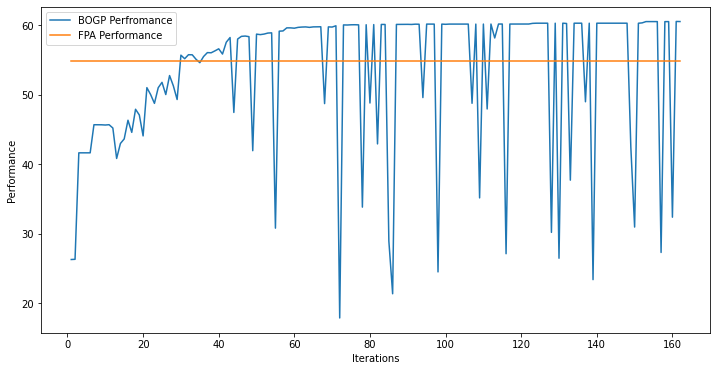

x_next is [ 26.67063308  29.98871777  29.9962344   26.5163921   29.97958347
  25.51704836  12.1502893  -27.13009492  29.97539947  29.99394751
 -30.64296109 -23.91904602  16.48411292  20.83026604 -25.90198755
  29.99003797  23.4339097   14.8401228   21.79825384  24.82681146]
f()=60.561087, actual=60.559
161


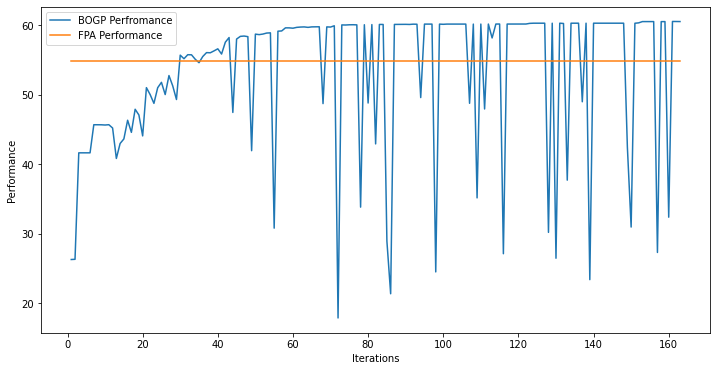

x_next is [ 26.59115852  30.          29.84166606  26.81441463  30.
  25.63279538  12.46064844 -27.35212073  30.          29.97130344
 -30.38969301 -24.00187623  16.50546551  20.89009703 -25.82915735
  29.99992313  23.31023999  15.07222909  21.83559537  25.0700701 ]
f()=60.568371, actual=60.575
162


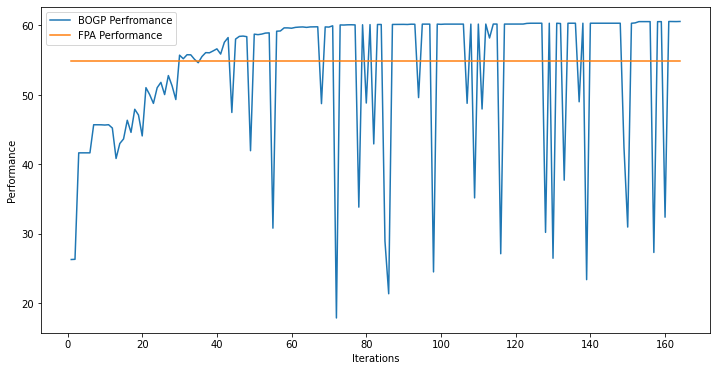

x_next is [ 18.26116916  29.53966085  29.73209729 -21.66679901 -30.88470137
  22.93971657  16.21842899  14.53566277 -29.62169594  18.6979555
 -15.82710669  15.05775403  -5.01331031  28.28108094  -4.61635237
 -21.33394187  27.22615392  26.38060748  28.6095361   23.87782679]
f()=53.329395, actual=37.394
163


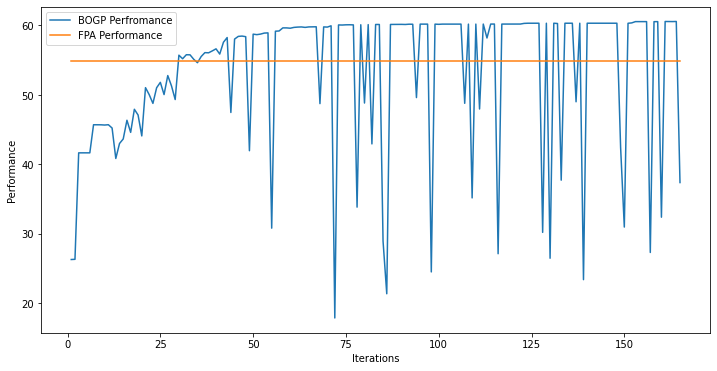

x_next is [ 26.30502832  29.99157201  29.99882221  26.52315492  30.
  25.77786205  12.26820661 -27.41957454  29.96412307  30.
 -30.05528874 -23.66429917  16.00220409  20.81253507 -25.87719346
  30.          23.10482682  14.9675186   21.70010865  24.97695654]
f()=60.564883, actual=60.570
164


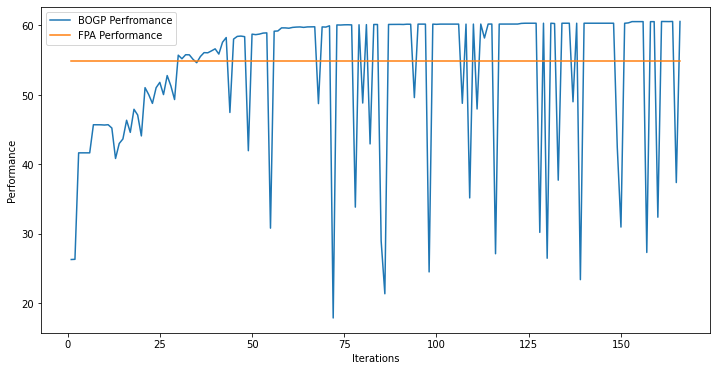

x_next is [ 26.17327136  29.96043117  29.89383535  27.06535092  29.97874778
  25.84426258  12.32796811 -27.54860338  29.98581511  29.88405717
 -30.20375634 -23.69743074  16.09584968  20.65005807 -25.22652901
  29.97235905  23.24041394  14.80796882  21.9583854   25.02584793]
f()=60.544558, actual=60.576
165


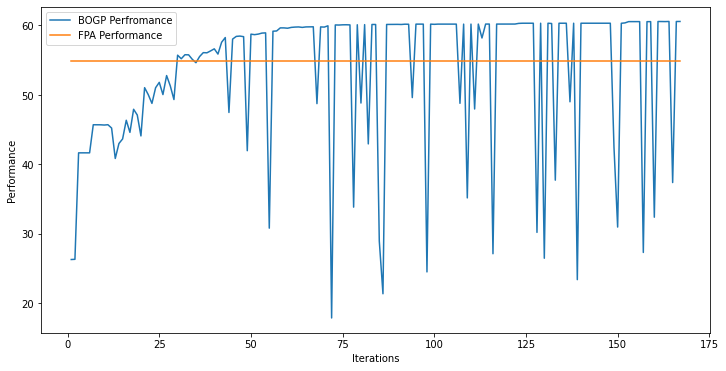

x_next is [ 26.2088488   29.9932542   29.99629234  27.10991112  29.99364916
  25.74832014  12.33440086 -27.44382787  29.96234174  29.99201057
 -30.46479616 -23.6706416   16.14902387  21.10974789 -25.22884907
  29.99336055  23.17108494  14.61785412  22.17650922  25.0213688 ]
f()=60.590002, actual=60.592
166


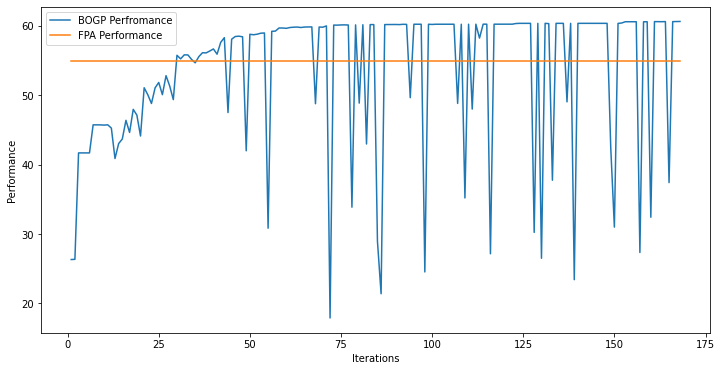

x_next is [ 26.12058931  29.9884677   29.97371385  27.03438839  29.99400946
  25.75014173  12.35603693 -27.44005377  29.98929616  29.99886743
 -30.35898208 -23.61840448  15.98255814  20.91196131 -24.86588741
  29.98861899  23.12565666  14.83532979  21.97235139  25.04218863]
f()=60.591211, actual=60.590
167


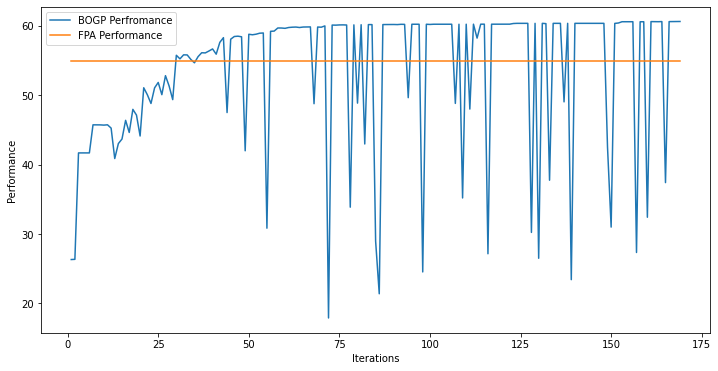

x_next is [ 26.16008625  29.99177076  29.9351111   27.21274637  29.99649561
  25.90951683  12.38443967 -27.49939828  29.98319868  29.98576336
 -30.14607203 -23.67084424  15.98650838  20.87621776 -25.09386149
  29.99822269  23.03330608  14.75149728  21.94933967  25.02653401]
f()=60.590081, actual=60.591
168


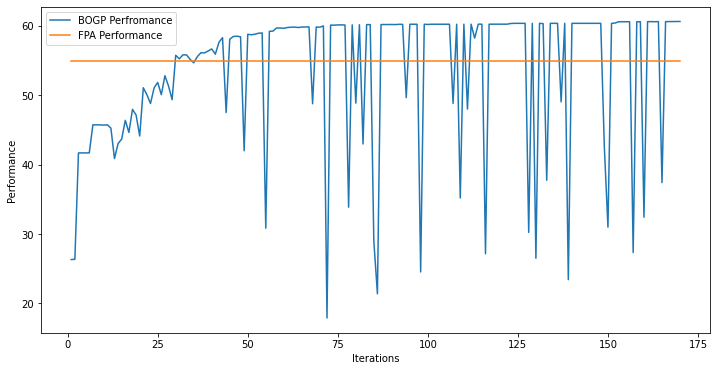

x_next is [ 26.11704506  29.99884806  29.94725398  26.98566912  29.99876342
  25.76483862  12.27262072 -27.64700026  29.98744347  29.99659187
 -30.41103279 -23.76038908  16.09519402  21.15415199 -25.18649139
  29.98083616  23.05089066  14.71198332  22.15928447  25.16250447]
f()=60.592702, actual=60.587
169


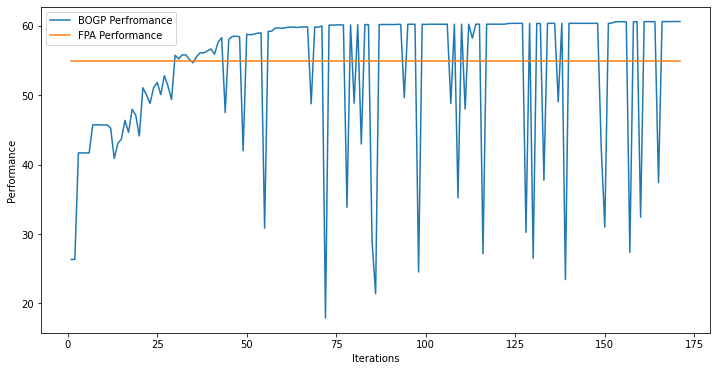

x_next is [-18.89902433   4.6250761   29.55095864 -30.8722525  -30.4358805
  12.80609017   3.46739749  25.65802829 -12.04586544   9.23438002
  29.08428472  19.1766816  -15.62065861  -3.42310411   9.20591095
 -11.31399189  10.72058418 -11.40539797  10.88833212 -30.76561951]
f()=53.490924, actual=31.815
170


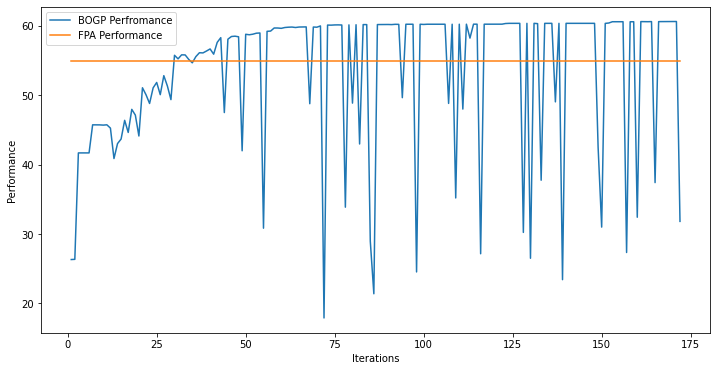

x_next is [ 26.29422768  29.95349685  29.91986535  27.22047298  29.98986033
  25.67461184  12.40096282 -27.48455531  29.99492926  29.95876717
 -30.22405992 -23.35175569  16.2096119   20.91878988 -24.93349606
  29.97689233  23.07019615  14.42576489  21.6450477   25.16397069]
f()=60.579525, actual=60.587
171


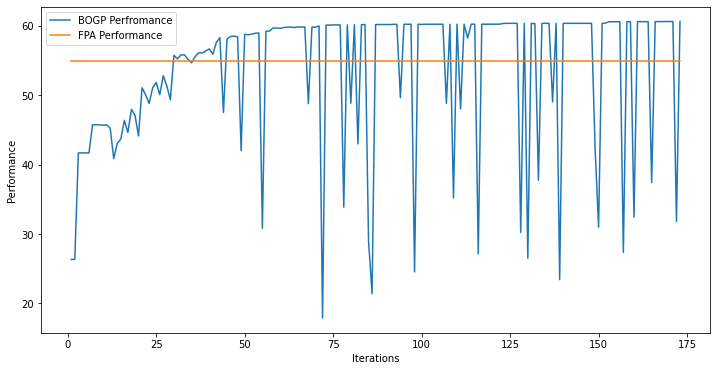

x_next is [ 26.34261114  30.          29.99999998  27.16419025  30.
  25.67367414  12.49474585 -27.38056159  30.          30.
 -30.22138302 -23.51482722  16.16768332  20.98899712 -25.18445859
  30.          23.22063597  14.51649707  21.91841104  25.00505679]
f()=60.601931, actual=60.597
172


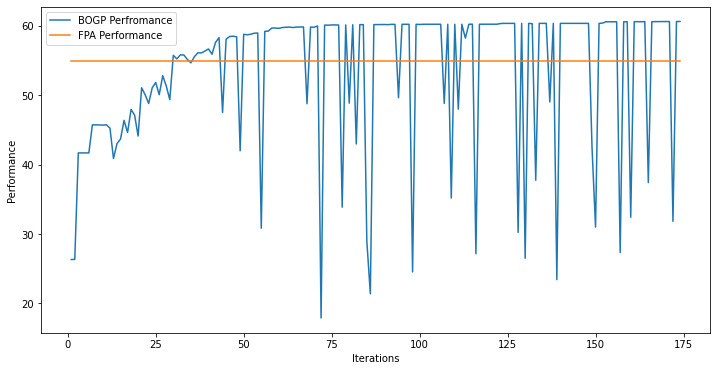

x_next is [ 26.38688804  29.98714741  29.96980186  27.14617321  29.98515505
  25.67092772  12.38853788 -27.19278034  29.96694866  29.95521505
 -30.57026019 -23.58155759  16.23574712  20.86381666 -25.10474526
  29.99960493  22.98557783  14.49564371  21.6839776   25.21914861]
f()=60.589694, actual=60.588
173


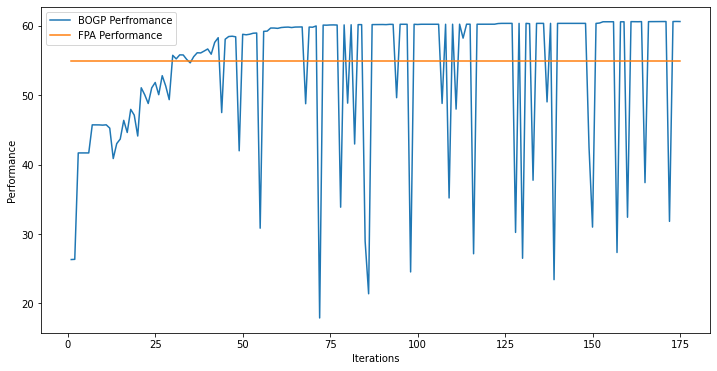

x_next is [ 26.22405156  30.          29.99999999  27.22183263  30.
  25.86838425  12.23379511 -27.34681361  30.          30.
 -30.3864947  -23.3869171   16.13528988  20.94774925 -25.06667359
  30.          23.063825    14.52154892  21.81052459  25.06444619]
f()=60.600561, actual=60.587
174


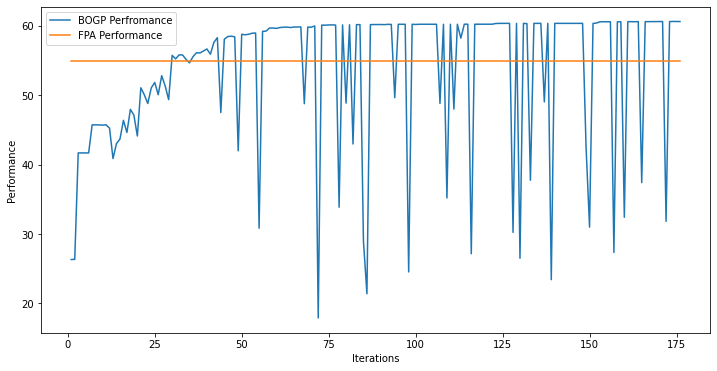

x_next is [ 24.11054533  -3.19685815   1.80969808  28.83910646  10.7354288
   6.27070064   2.8857642  -10.71564208 -10.76082982 -17.44808105
 -29.02384683 -21.90254499 -24.71664191 -18.36436449  10.72324205
  24.45512674  -2.2247425  -20.37491091 -18.43776569 -25.11510185]
f()=30.329469, actual=28.185
175


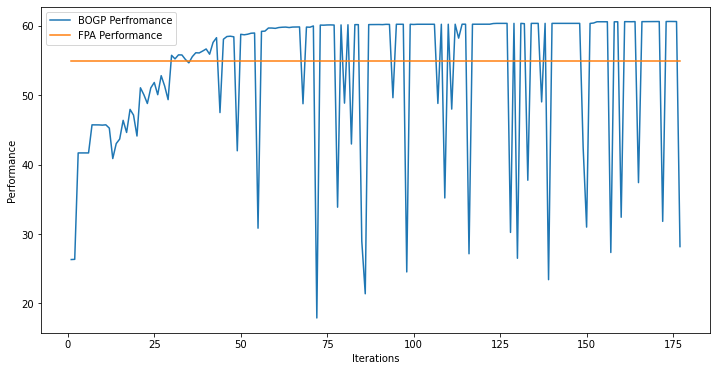

x_next is [ 25.25373954  29.82829013  29.93323654  26.66969269  29.97918048
  24.18133439  11.18729635 -27.67206401  29.77959863  29.63784783
 -30.80624411 -23.62355661  14.18357156  20.65019292 -24.10518137
  29.81746227  21.36610875  13.36594477  20.97871048  24.82968592]
f()=60.438721, actual=60.397
176


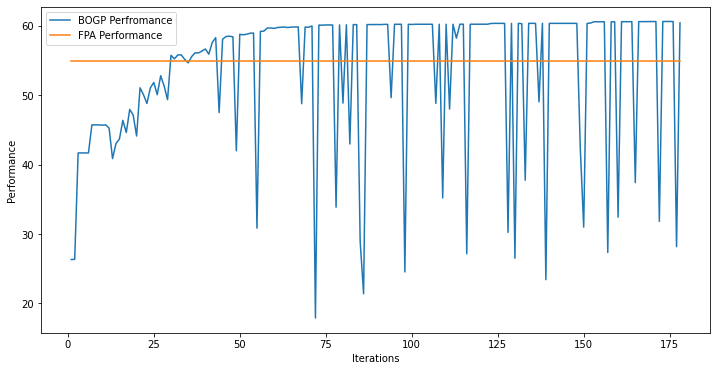

x_next is [ 26.13481119  29.96492056  29.95992847  27.25122617  29.99672436
  25.39710633  12.82212827 -27.47272856  29.99182867  29.97545243
 -30.30347168 -23.94357915  15.93002929  21.09482193 -25.05204337
  29.9830437   22.99516233  14.31702871  21.70386337  25.11603486]
f()=60.600588, actual=60.595
177


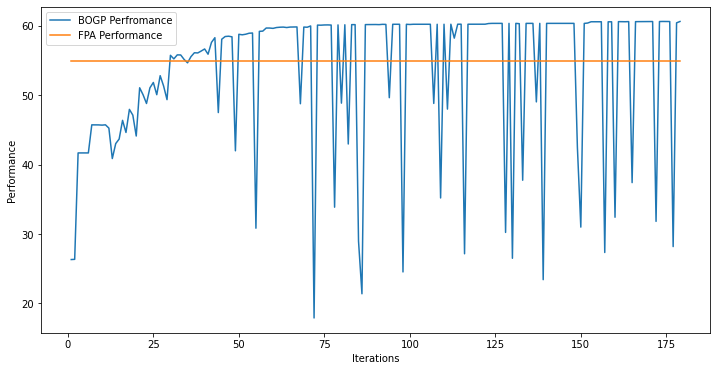

x_next is [ 26.26168801  30.          30.          27.23861645  30.
  25.4678734   12.68615171 -27.42535953  30.          30.
 -30.27706958 -23.85446179  16.13189278  20.94265209 -25.05858331
  30.          23.04780332  14.58209123  21.94920891  25.18162103]
f()=60.604744, actual=60.604
178


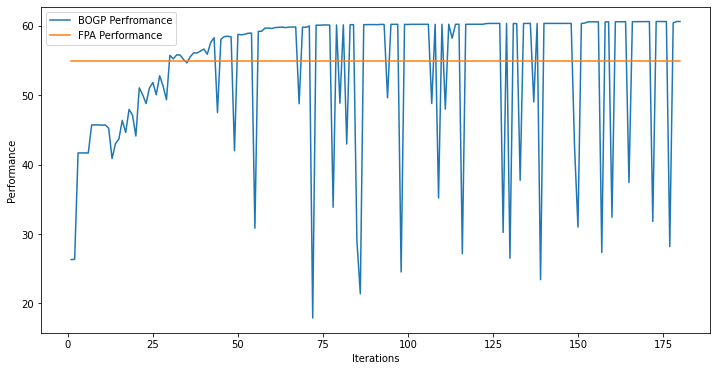

x_next is [ 26.28283577  30.          30.          27.19474831  30.
  25.49991322  12.7521271  -27.4269185   29.99999999  30.
 -30.2911517  -23.85543008  16.1181956   20.97858815 -25.29709111
  30.          23.06772256  14.57314072  21.92561763  25.12160693]
f()=60.603278, actual=60.604
179


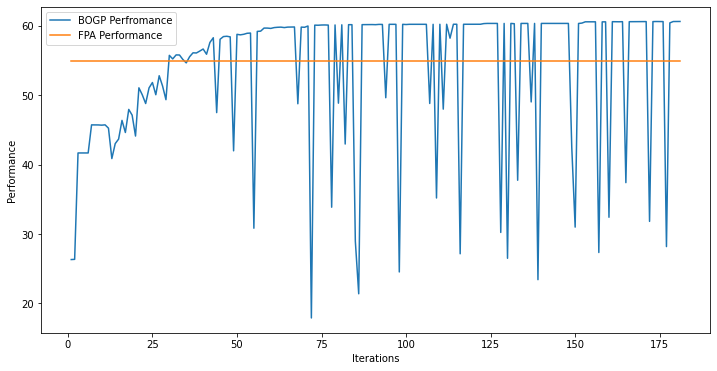

x_next is [-28.50923415 -30.67821443   6.19902842 -27.96213328   1.31178582
  -4.71525797 -20.73912283 -10.83017911  19.8208106   28.43164617
  15.44691959  29.97653425  -1.42190763  23.82653733  -6.54429061
 -14.38128649 -29.19508206 -28.32780624  17.92843428 -16.69102085]
f()=0.000000, actual=25.183
180


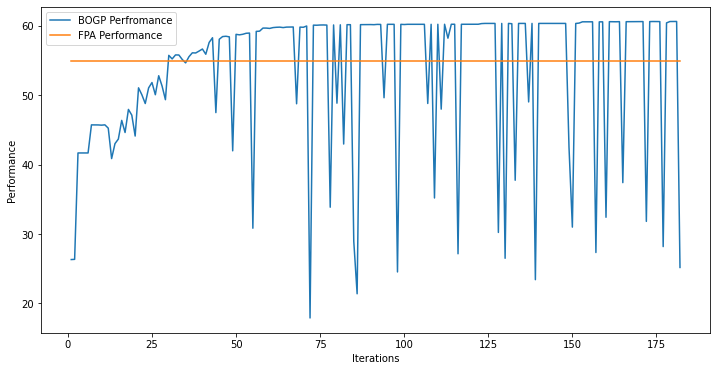

x_next is [ 29.99901475  29.999835    29.99907189 -30.99893434  29.999005
  29.99985852 -30.99968169  29.99873905  29.99902943  29.9983356
 -30.99951459  29.99859654  -7.07650762  29.99987788  29.99937552
  29.99938797  16.04435684 -30.99624113  29.99979667  29.99934342]
f()=52.798713, actual=45.521
181


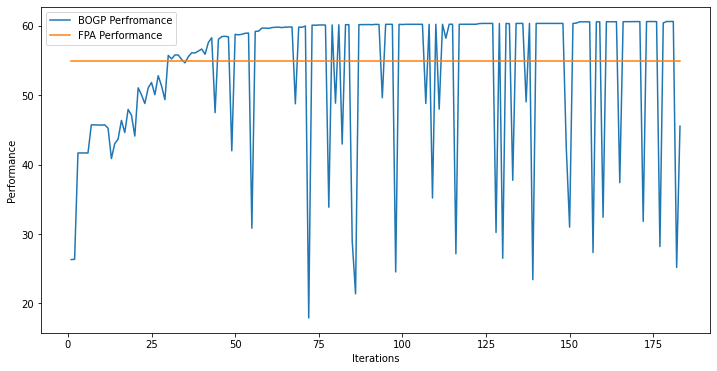

x_next is [ 26.26931908  29.99520406  29.97623796  27.07430745  29.98421368
  25.35013423  12.51454496 -27.50359501  29.8438139   29.97477884
 -30.37899792 -23.70278718  16.00459167  20.71435968 -24.89372428
  29.98331819  22.94572833  14.41551112  21.66948113  24.95735184]
f()=60.592882, actual=60.599
182


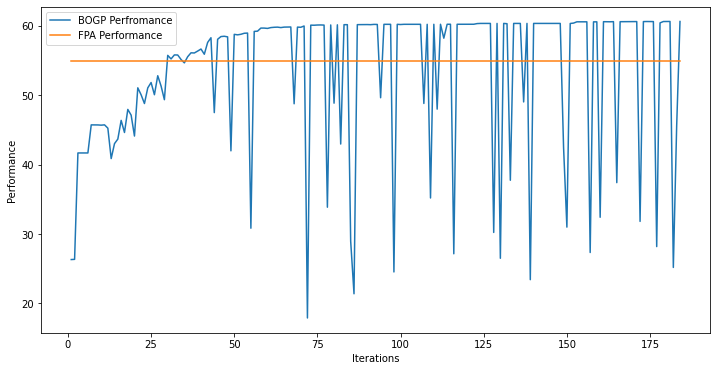

x_next is [ 26.25375766  29.974765    29.98985862  27.06633114  29.99264247
  25.40342242  12.62540811 -27.58151649  29.7913166   29.98849637
 -30.43285446 -23.73886124  16.08411442  20.7268328  -25.08772236
  29.98349595  22.82827283  14.40887519  21.8410885   24.92094483]
f()=60.599182, actual=60.610
183


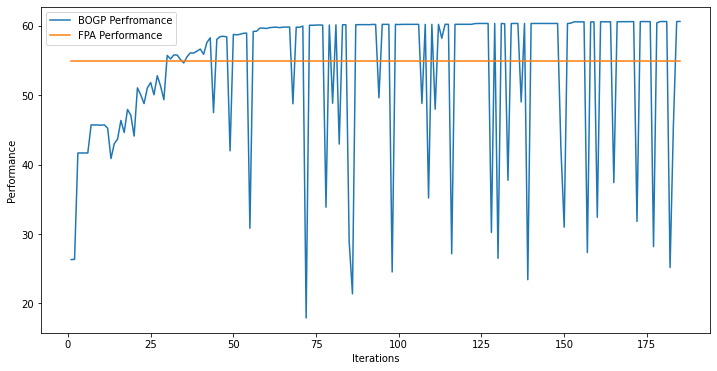

x_next is [ 25.88549946  29.89949943  29.99250382  26.91596408  29.99982047
  25.33172966  12.80101096 -27.57813737  29.43553153  29.98072728
 -30.38276305 -23.53295881  16.07729663  20.77876865 -25.25034882
  29.96029529  22.52532879  14.31686675  21.93015118  24.88018479]
f()=60.611949, actual=60.632
184


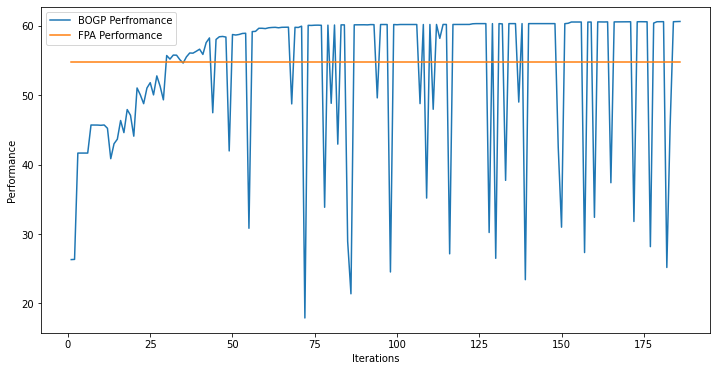

x_next is [ 25.6959316   30.          30.          26.98607971  30.
  25.30932167  12.89949763 -27.52822162  28.78899937  30.
 -30.34927521 -23.3744095   16.10909914  20.75112365 -25.19107072
  30.          22.57264975  14.37941878  21.97007177  25.0004068 ]
f()=60.651108, actual=60.653
185


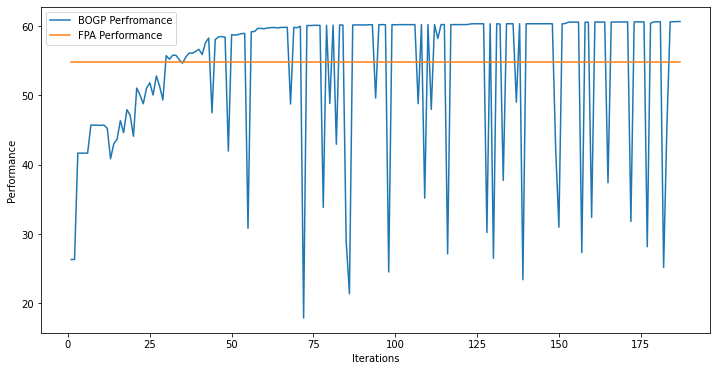

x_next is [ 25.59273516  29.94420684  30.          27.0789965   30.
  25.25860303  12.73092167 -27.31024167  28.56095822  30.
 -30.29653773 -23.20058783  15.93338668  20.73205901 -24.90371704
  30.          22.33612727  14.13735159  21.84979606  25.07227467]
f()=60.643679, actual=60.655
186


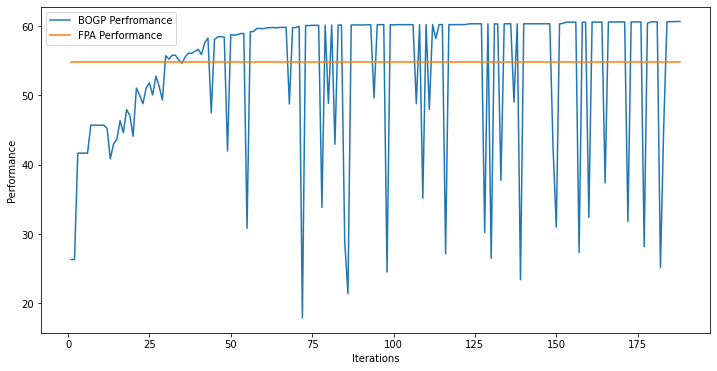

x_next is [ 25.55337314  30.          30.          26.99867945  30.
  25.27995231  12.73940947 -27.36625839  28.54652133  30.
 -30.27308325 -23.22269728  15.99072317  20.71494593 -24.9688577
  30.          22.35918398  14.20229658  21.87283133  25.03420603]
f()=60.656763, actual=60.653
187


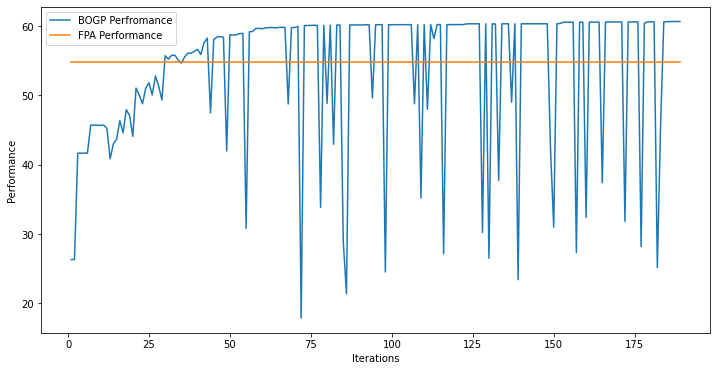

x_next is [ 25.75834588  29.61614873  30.          27.17919157  30.
  25.25390789  12.80808993 -27.35896503  28.59555091  30.
 -30.38770771 -23.29663789  15.97264342  20.78006362 -24.99561597
  30.          22.52938524  14.26095009  21.91623208  25.15836739]
f()=60.657738, actual=60.656
188


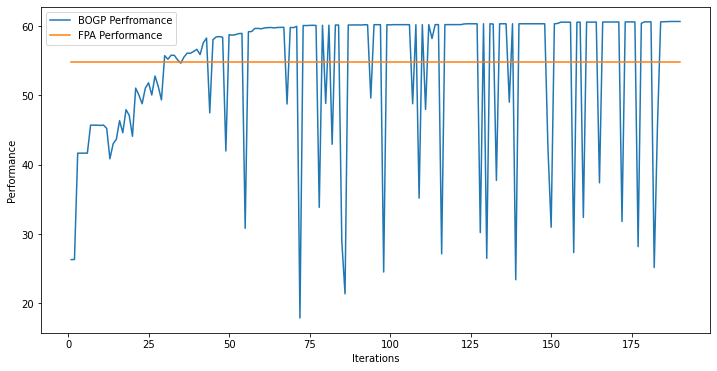

x_next is [ 25.7784619   29.87347427  30.          27.09802241  30.
  25.12245597  12.72900077 -27.36454343  28.50174474  30.
 -30.66931807 -23.30988999  16.00497903  20.75017657 -24.87294149
  30.          22.42553783  14.25447274  21.90285994  25.04393262]
f()=60.653900, actual=60.654
189


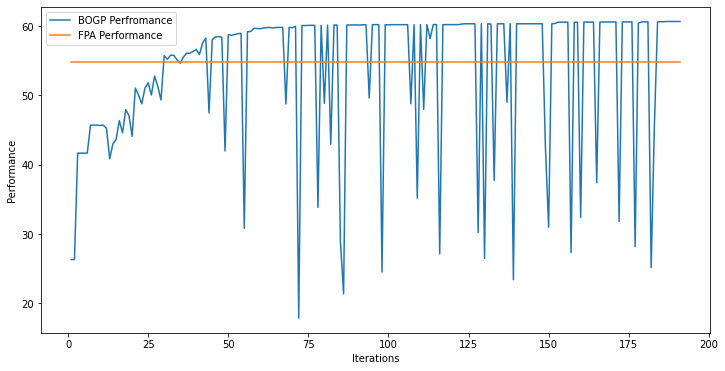

x_next is [ 25.76645721  29.88397679  30.          27.19246419  30.
  25.24917053  12.82361394 -27.35641268  28.61673052  30.
 -30.40149934 -23.28456657  15.96733729  20.77692266 -24.98367821
  30.          22.51392114  14.23847926  21.92276171  25.15198874]
f()=60.657630, actual=60.658
190


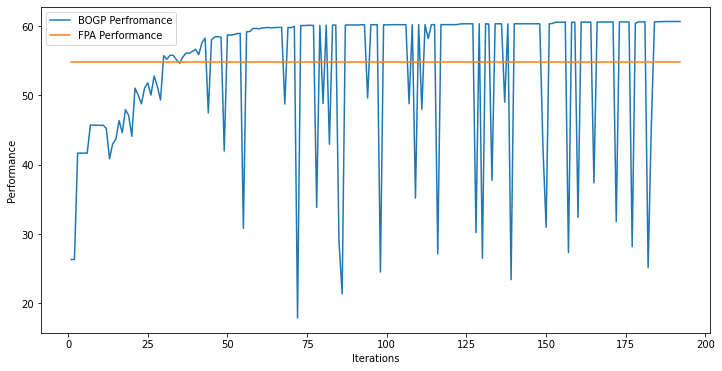

x_next is [-17.40913141  23.5937903  -16.13995185 -20.54203151   3.52293866
  27.70538137 -11.75266671   4.58793948 -29.84237807  -1.24177102
  -3.62444069 -10.47376483  10.04024452  -4.75322414 -19.06079183
 -29.73741235  -9.20419066   5.02474719  27.55261877  -0.85864695]
f()=53.687137, actual=23.599
191


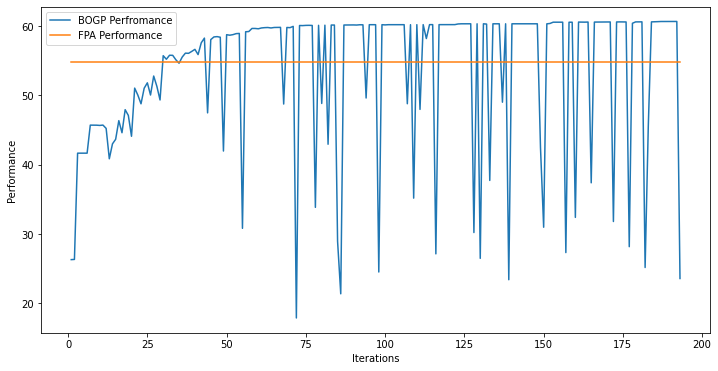

x_next is [ 29.90945944  29.96171433  29.97722794  29.9931806   29.99611851
  29.99394688  29.95284155 -30.9631411   29.99218069  29.9774069
 -30.99555451 -30.97384574  29.89127197  29.97965485 -30.9933212
  29.95506365  29.97349456  29.97634291  29.99421632  29.99217134]
f()=53.530809, actual=48.831
192


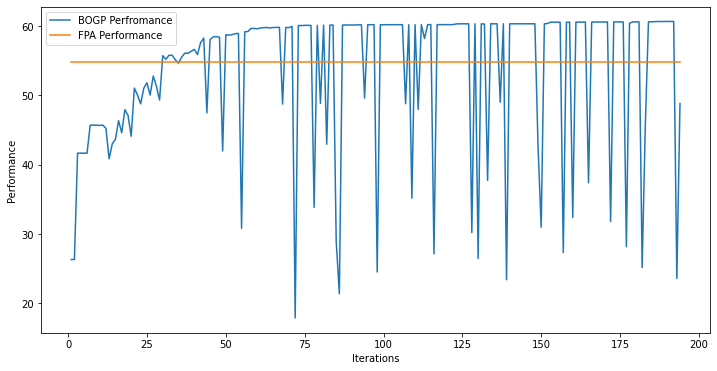

x_next is [ 24.32468698  29.39349918  28.96010343  27.06484798  29.85869385
  26.73649747  13.08530666 -27.91417508  29.7049717   29.86394225
 -29.47230041 -23.23520511  17.07377114  21.51029687 -26.39582485
  29.8853795   23.58103479  14.7458792   24.17429042  26.20702993]
f()=60.232155, actual=60.234
193


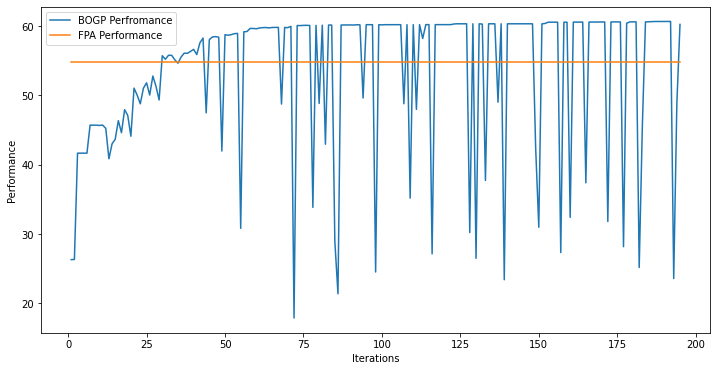

x_next is [  2.1057067   28.87720802  10.73300855   6.17193953  -8.78742246
  28.43076994  17.05563704  25.92286976  24.16150081 -23.76966501
  -6.29568532  25.67353478  23.61196821 -14.92214034   1.13603967
   8.49864711 -19.93519219  16.70549989  20.02846834  -1.38067672]
f()=35.050451, actual=43.096
194


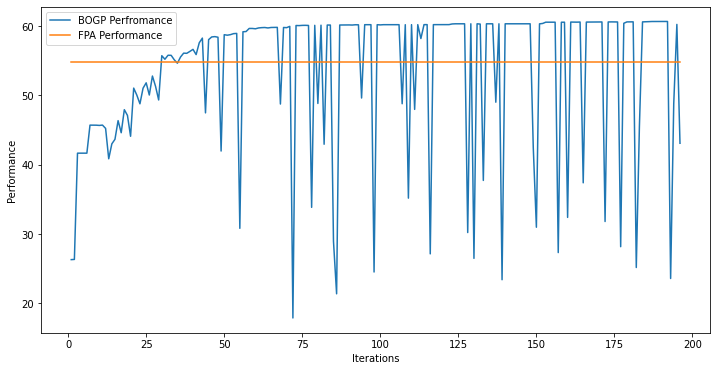

x_next is [ 25.88162443  29.915696    29.90775763  27.17166029  29.98929156
  25.17701965  12.8556652  -27.22781754  28.59459436  29.98728027
 -30.36382426 -23.19404556  15.95208532  20.70599714 -25.06669339
  29.97990546  22.56642202  14.10757531  21.8931518   25.13769725]
f()=60.650423, actual=60.653
195


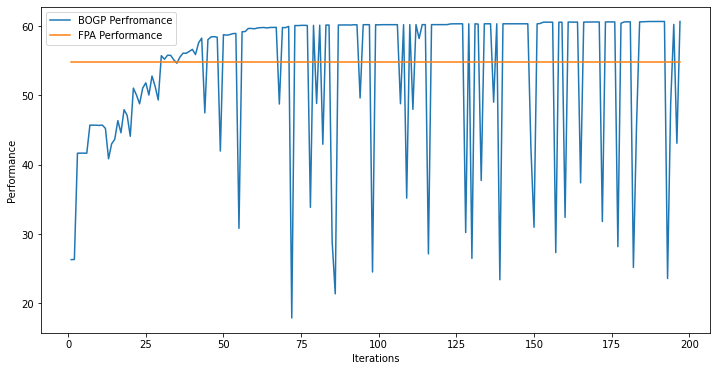

x_next is [-15.03796758 -24.73448611  20.15781257  -0.83450486   4.63651897
  -6.51724862  13.23202601  -9.65037582  28.34210116 -24.91644171
   2.88023004  27.70955782   3.68098026 -22.65196672   9.12422375
  -0.89372082  26.69943907 -26.8837987  -23.1210659   16.57262651]
f()=53.524277, actual=27.294
196


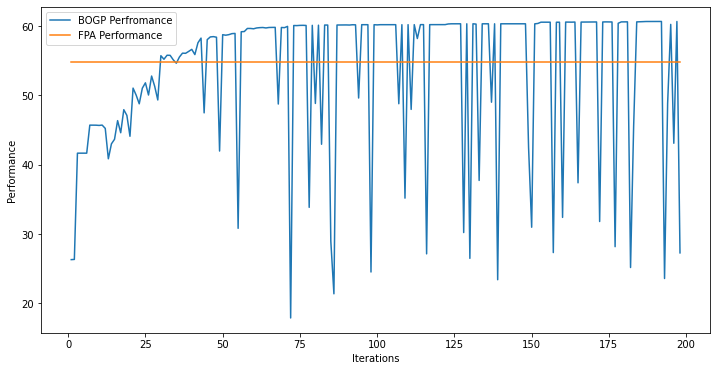

x_next is [ 25.83759352  29.93036947  30.          27.16806956  30.
  25.21253003  12.84341616 -27.29110323  28.61177347  30.
 -30.39013442 -23.24349762  15.97977598  20.74909129 -25.05314039
  30.          22.57272663  14.20044344  21.96129858  25.16252136]
f()=60.658833, actual=60.658
197


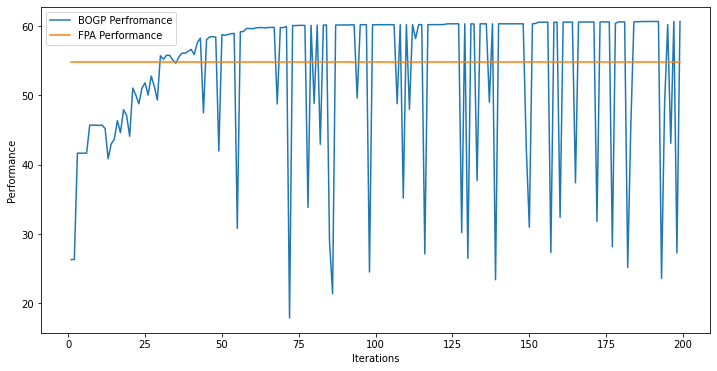

In [ ]:
from sklearn.gaussian_process.kernels import Matern, WhiteKernel, ConstantKernel

X = 0 * np.ones([1,var], dtype = "float")
y = np.array([[objective_FPA(X[0].reshape((int)(var/number_of_cells), number_of_cells))]])

tr_FPA = objective_FPA(P_max * np.ones([1,var], dtype = "float").reshape((int)(var/number_of_cells), number_of_cells))
y_FPA = np.array([[tr_FPA]])

kernels =  ConstantKernel(constant_value=200, constant_value_bounds = (1e-20, 1e20)) * Matern(length_scale=1, length_scale_bounds=(1e-20,1e20), nu=1.5) + WhiteKernel(noise_level=1, noise_level_bounds=(1e-20, 1e20)) 
model = GaussianProcessRegressor(kernel = kernels, n_restarts_optimizer=30)

model.fit(X, y)

for i in range(250):
  x_next = opt_acquisition(X, y, model, X.shape[0])

  np.save("/content/drive/MyDrive/trainingx_BOGP.npy",X)
  np.save("/content/drive/MyDrive/trainingy_BOGP.npy",y)
  np.save("/content/drive/MyDrive/grad_trainingyFPA_BOGP.npy",y_FPA)
  
  tr = 0
  for l in range(1):
    tr = tr + objective_FPA(x_next.reshape((int)(var/number_of_cells), number_of_cells))
  tr = tr/1.0  
  actual = tr

  tr_FPA = objective_FPA(P_max * np.ones([1,var], dtype = "float").reshape((int)(var/number_of_cells), number_of_cells))
  
  est, _ = surrogate(model, [x_next])
  print("x_next is", x_next)
  print('f()=%3f, actual=%.3f' % (est, actual))
  
  X = vstack((X, [x_next]))
  y = vstack((y, [[actual]]))
  y_FPA = vstack((y_FPA, [[tr_FPA]]))
  
  model.fit(X, y)
  
  print(i)
  pyplot.figure(figsize = (12, 6))

  pyplot.xlabel("Iterations")
  pyplot.ylabel("Performance")
  pyplot.plot(np.arange(1,X.shape[0]+1),y[:])
  pyplot.plot(np.arange(1,X.shape[0]+1), y_FPA[:])
  pyplot.legend(["BOGP Perfromance","FPA Performance"])
  pyplot.show()


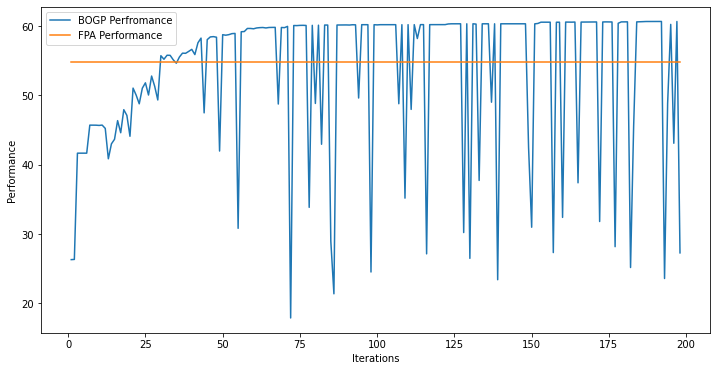

P_max = 30.000, Optimal_SE = 60.658
P_max = 30.000, Optimal_SE_FPA = 54.863


In [15]:
pyplot.figure(figsize = (12, 6))   
pyplot.xlabel("Iterations")
pyplot.ylabel("Performance")
pyplot.plot(np.arange(1,X.shape[0]+1),y[:])
pyplot.plot(np.arange(1,X.shape[0]+1), y_FPA[:])
pyplot.legend(["BOGP Perfromance","FPA Performance"])
pyplot.show() 
ix = 0
ix = argmax(y)
print('P_max = %.3f, Optimal_SE = %.3f' % (P_max, y[ix]))

ix_FPA=0
ix_FPA=argmax(y_FPA)
print('P_max = %.3f, Optimal_SE_FPA = %.3f' % (P_max, y_FPA[ix_FPA]))

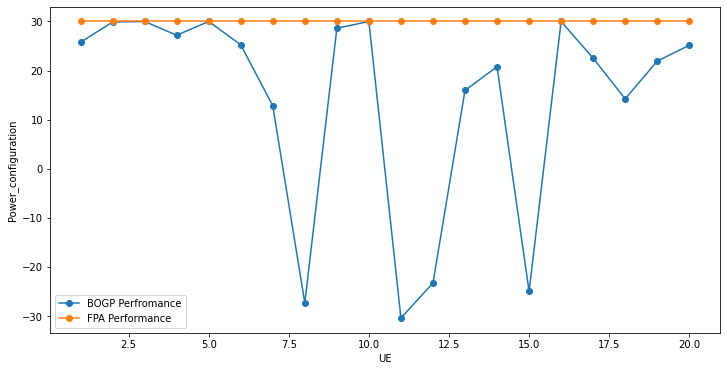

Power_configuration_BOGP is [ 25.76645721  29.88397679  30.          27.19246419  30.
  25.24917053  12.82361394 -27.35641268  28.61673052  30.
 -30.40149934 -23.28456657  15.96733729  20.77692266 -24.98367821
  30.          22.51392114  14.23847926  21.92276171  25.15198874]


In [31]:
import matplotlib.pyplot as plt
X_FPA = P_max * np.ones([1,var], dtype = "float").reshape((int)(20), 1)
plt.figure(figsize = (12, 6))   
plt.xlabel("UE")
plt.ylabel("Power_configuration")
plt.plot(np.arange(1,21),X[ix][:], '-o')
plt.plot(np.arange(1,21),X_FPA[:], '-o')
plt.legend(["BOGP Perfromance","FPA Performance"])
plt.show()
print("Power_configuration_BOGP is", X[ix])

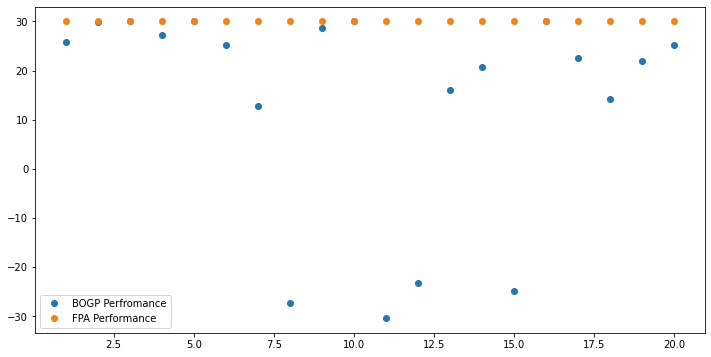

Power_configuration_BOGP is [ 25.76645721  29.88397679  30.          27.19246419  30.
  25.24917053  12.82361394 -27.35641268  28.61673052  30.
 -30.40149934 -23.28456657  15.96733729  20.77692266 -24.98367821
  30.          22.51392114  14.23847926  21.92276171  25.15198874]


In [36]:
import matplotlib.pyplot as plt
X_FPA=np.linspace(P_max,P_max,20)
plt.figure(figsize = (12, 6)) 
plt.plot(np.arange(1,21),X[ix][:], 'o')
plt.plot(np.arange(1,21),X_FPA[:], 'o')
plt.legend(["BOGP Perfromance","FPA Performance"])
plt.show()
print("Power_configuration_BOGP is", X[ix])